## Pre-processing 

### Making the training data as a table

In [1]:
import pandas as pd
import numpy as np
import h5py
import os
from tqdm.auto import tqdm

# --- 1. SETUP: Constants and File Paths ---
# NOTE: Update these paths to match your local directory structure
BASE_PATH = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/'
HALO_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/TNG_halos.txt')
ABSORBER_DIR = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/v_2500_data_filtered_v800_combined_gal_removed')
RAY_DIR = os.path.join(BASE_PATH, 'Grad School/MgII_TNG_Project/Primary Project/Trident Codes/TNG_50_z_0.1_groups/revised_final')
GALAXY_DIR = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/galaxy_cats')
OUTPUT_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv')

# Constants from your notes
Z = 0.09940180263022191
A = 1 / (1 + Z)
H = 0.6774
BOX_SIZE = 35000.0 # ckpc/h
G_CONST = 4.30091e-6 # kpc * (km/s)^2 / M_sun

# Mappings
FILE_TO_GRP_MAP = {0: 7, 1: 8, 2: 9, 3: 10, 4: 11, 5: 12, 6: 13, 7: 15, 8: 17, 9: 18, 10: 19, 11: 20, 12: 22, 13: 24}
GRP_STELLAR_MASSES = {
    7: 12.1665, 8: 12.1169, 9: 12.1128, 10: 12.0482, 11: 11.9627, 12: 12.0225,
    13: 11.9085, 15: 11.9562, 17: 11.9002, 18: 11.8603, 19: 11.7785, 20: 11.8335,
    22: 11.7991, 24: 11.5953
}

# --- 2. HELPER FUNCTIONS ---
def apply_cyclic_condition(coord1, coord2, box_size):
    """Applies cyclic boundary conditions for distance calculation."""
    diff = np.abs(coord1 - coord2)
    if diff > box_size / 2:
        if coord1 > coord2:
            return coord2 + box_size
        else:
            return coord2 - box_size
    return coord2

def calculate_escape_velocity(r_kpc_series, mass_log_series):
    """
    Calculates escape velocity in km/s for entire pandas Series.
    This is a vectorized function for efficiency.
    """
    valid_mask = (r_kpc_series > 0) & (mass_log_series.notna())
    v_esc = np.full(len(r_kpc_series), np.nan)
    if valid_mask.any():
        mass_msun = 10**mass_log_series[valid_mask]
        v_esc[valid_mask] = np.sqrt(2 * G_CONST * mass_msun / r_kpc_series[valid_mask])
    return v_esc

# --- 3. LOAD STATIC DATA ---
print("Loading halo data...")
halo_df = pd.read_csv(HALO_FILE, sep='|', skipinitialspace=True)
halo_df.dropna(axis=1, how='all', inplace=True)
halo_df.columns = [c.strip() for c in halo_df.columns]

rename_map = {}
for col in halo_df.columns:
    if 'GroupPos_x' in col: rename_map[col] = 'GroupPos_x'
    elif 'GroupPos_y' in col: rename_map[col] = 'GroupPos_y'
    elif 'GroupPos_z' in col: rename_map[col] = 'GroupPos_z'
    elif 'GroupVel(x' in col: rename_map[col] = 'GroupVel_x'
    elif 'GroupVel(y' in col: rename_map[col] = 'GroupVel_y'
    elif 'GroupVel(z' in col: rename_map[col] = 'GroupVel_z'
halo_df.rename(columns=rename_map, inplace=True)

halo_df['log_M_star_group'] = halo_df['Grp_Index'].map(GRP_STELLAR_MASSES)


# --- 4. MAIN PROCESSING LOOP ---
all_groups_data = []
pbar = tqdm(FILE_TO_GRP_MAP.items(), desc="Processing Groups")

for file_idx, grp_idx in pbar:
    pbar.set_postfix_str(f"Grp_Index: {grp_idx}")

    # --- 4a. Load group-specific data ---
    group_halo_info = halo_df[halo_df['Grp_Index'] == grp_idx].iloc[0]

    absorber_file = os.path.join(ABSORBER_DIR, f"group_{file_idx}_combined_features.txt")
    absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
    absorber_df.columns = [c.strip() for c in absorber_df.columns]
    absorber_df.drop(columns=['Unnamed: 0', 'Unnamed: 18'], inplace=True, errors='ignore')
    
    # --- 4b. Start with the filtered absorber data ---
    detections = absorber_df[absorber_df['dN'].notna()].copy()
    strongest_detections = detections.loc[detections.groupby('Sightline')['N'].idxmax()]
    non_detections = absorber_df[absorber_df['dN'].isna()].copy()
    sightline_df = pd.concat([strongest_detections, non_detections], ignore_index=True)
    sightline_df.sort_values(by='Sightline', inplace=True)
    
    # --- 4c. Load data needed for feature calculation ---
    ray_file = os.path.join(RAY_DIR, f"integral_TNG50-1_z0.1_n300d2-sample_localized_OVInumdens_{file_idx}-of-14.hdf5")
    with h5py.File(ray_file, 'r') as f:
        ray_positions = f['ray_pos'][:]

    galaxy_file = os.path.join(GALAXY_DIR, f"group_{grp_idx}_galaxy_catalog_converted.txt")
    galaxy_df = pd.read_csv(galaxy_file, sep='|', skipinitialspace=True)
    galaxy_df.columns = [c.strip() for c in galaxy_df.columns]
    
    if (galaxy_df['SubhaloMassType_4'] == 0).any():
        zero_mass_count = (galaxy_df['SubhaloMassType_4'] == 0).sum()
        # This warning is for debugging and can be commented out if not needed
        # print(f"\nWARNING: Group {grp_idx} contains {zero_mass_count} subhalos with zero stellar mass.")
        
    galaxy_df['SubhaloMassType_4_phys'] = galaxy_df['SubhaloMassType_4'] * 1e10 / H
    galaxy_df['log_sSFR'] = np.log10(galaxy_df['SubhaloSFR'] / galaxy_df['SubhaloMassType_4_phys'].replace(0, 1e-9))

    # --- 4d. Add Features to the DataFrame ---
    sightline_df['file_idx'] = file_idx
    sightline_df['grp_idx'] = grp_idx
    sightline_df['has_OVI_absorber'] = sightline_df['dN'].notna().astype(int)
    sightline_df['log_M_halo'] = group_halo_info['M_Crit200_log']
    sightline_df['log_M_star_group'] = group_halo_info['log_M_star_group']

    # --- 4e. Calculate Impact Parameters and Nearest Galaxy Properties (Optimized) ---
    filtered_sightline_ids = sightline_df['Sightline'].values
    filtered_ray_positions = ray_positions[filtered_sightline_ids]

    center_x, center_y = group_halo_info['GroupPos_x'], group_halo_info['GroupPos_y']
    corrected_center_x = np.array([apply_cyclic_condition(rx, center_x, BOX_SIZE) for rx in filtered_ray_positions[:, 0]])
    corrected_center_y = np.array([apply_cyclic_condition(ry, center_y, BOX_SIZE) for ry in filtered_ray_positions[:, 1]])
    rho_group_comoving = np.sqrt((filtered_ray_positions[:, 0] - corrected_center_x)**2 + (filtered_ray_positions[:, 1] - corrected_center_y)**2)
    sightline_df['impact_param_group'] = rho_group_comoving * A / H

    nearest_galaxy_data = []
    galaxy_pos_xy = galaxy_df[['SubhaloPos_0', 'SubhaloPos_1']].values
    for i in range(len(filtered_ray_positions)):
        ray_x, ray_y = filtered_ray_positions[i, :2]
        
        corrected_gal_x = np.array([apply_cyclic_condition(ray_x, gx, BOX_SIZE) for gx in galaxy_pos_xy[:, 0]])
        corrected_gal_y = np.array([apply_cyclic_condition(ray_y, gy, BOX_SIZE) for gy in galaxy_pos_xy[:, 1]])
        distances_comoving = np.sqrt((ray_x - corrected_gal_x)**2 + (ray_y - corrected_gal_y)**2)
        
        nearest_idx = np.argmin(distances_comoving)
        nearest_galaxy_info = galaxy_df.iloc[nearest_idx]
        
        m_star_phys = nearest_galaxy_info['SubhaloMassType_4_phys']
        log_m_star_galaxy = np.log10(m_star_phys) if m_star_phys > 0 else np.nan
        
        nearest_galaxy_data.append({
            'impact_param_galaxy': distances_comoving[nearest_idx] * A / H,
            'log_M_star_galaxy': log_m_star_galaxy,
            'log_sSFR_galaxy': nearest_galaxy_info['log_sSFR'],
            'is_central': 1 if nearest_galaxy_info['SubhaloIDMostbound'] == group_halo_info['GroupFirstSub'] else 0
        })
    
    nearest_galaxy_df = pd.DataFrame(nearest_galaxy_data, index=sightline_df.index)
    sightline_df = pd.concat([sightline_df, nearest_galaxy_df], axis=1)

    # --- 4f. Calculate Velocity Offset and other flags ---
    v_sys_z = group_halo_info['GroupVel_z'] / A
    sightline_df['Velocity_Offset'] = sightline_df['v'] - v_sys_z
    
    v_escape = calculate_escape_velocity(sightline_df['impact_param_group'], sightline_df['log_M_halo'])
    sightline_df['is_bound'] = (np.abs(sightline_df['Velocity_Offset']) < v_escape).astype(int)
    
    # CORRECTED: This is the robust way to fill NaN values, avoiding the FutureWarning
    sightline_df['is_bound'] = sightline_df['is_bound'].fillna(0)

    sightline_df['is_star_forming'] = (sightline_df['log_sSFR_galaxy'] > -11).astype(int)
    
    all_groups_data.append(sightline_df)


# --- 5. FINALIZE AND SAVE ---
print("\nCombining data from all groups...")
final_df = pd.concat(all_groups_data, ignore_index=True)
final_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"Saving final feature table with {len(final_df)} rows to {OUTPUT_FILE}")
final_df.to_csv(OUTPUT_FILE, index=False)

print("\nDone. Feature table created successfully.")
print("\nFinal table columns:")
print(final_df.columns.tolist())
print("\nSample of the final table:")
print(final_df.head())


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading halo data...


Processing Groups:   7%|▋         | 1/14 [00:04<01:02,  4.77s/it, Grp_Index: 8]/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
Processing Groups:  21%|██▏       | 3/14 [00:14<00:54,  4.96s/it, Grp_Index: 10]/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/4204939500.py:84: DtypeWarning: Columns (7,18) have mixed types. Specify dtype option on import or set low_memory=False.
  absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
Processing Groups:  50%|█████     | 7/14 [00:33<00:33,  4.79s/it, Grp_Index: 15]/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/4204939500.py:84: DtypeWarning: Columns (7,18) have mixed types. Specify dtype option on import or set low_memory=False.
  absorber_df = pd.read_csv(absorber_file, sep='|', skipinitialspace=True)
Processing Groups:  79%|███████▊  | 11/14 [00:


Combining data from all groups...
Saving final feature table with 1199446 rows to /Users/wavefunction/ASU Dropbox/Tanmay Singh/Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv

Done. Feature table created successfully.

Final table columns:
['Sightline', 'Species', 'EW(mA)', 'dEW(mA)', 'N', 'dN', 'b', 'db', 'v', 'dv', 'l', 'dl', 'UpLim', 'Sat', 'Chisq', 'dN_lower', 'dN_upper', 'Unnamed: 20', 'file_idx', 'grp_idx', 'has_OVI_absorber', 'log_M_halo', 'log_M_star_group', 'impact_param_group', 'impact_param_galaxy', 'log_M_star_galaxy', 'log_sSFR_galaxy', 'is_central', 'Velocity_Offset', 'is_bound', 'is_star_forming']

Sample of the final table:
   Sightline       Species     EW(mA)                  dEW(mA)          N  \
0          0  OVI1031       26.336183  13.328228594498576       13.503835   
1          1  OVI1031      -15.099260  13.328228594498576       13.503835   
2          2  OVI1031       31.341386  13.328228594498576       13.503835   
3          3  OVI1031    

In [2]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 31 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1193160 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   248496 non-null   object 
 6   b                    1174621 non-null  object 
 7   db                   1174621 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1174621 non-null  object 
 11  dl                   1174621 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1174621 non-null  object 
 15

In [3]:
final_df.head(50)

,Sightline,Species,EW(mA),dEW(mA),N,dN,b,db,v,dv,...,log_M_halo,log_M_star_group,impact_param_group,impact_param_galaxy,log_M_star_galaxy,log_sSFR_galaxy,is_central,Velocity_Offset,is_bound,is_star_forming
0,0,OVI1031,26.336183,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,81.996479,81.996479,12.092716,-11.028080,0,-43.853234,1,0
1,1,OVI1031,-15.099260,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,796.247718,796.247718,12.092716,-11.028080,0,-43.853234,1,0
2,2,OVI1031,31.341386,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,53.772641,53.772641,12.092716,-11.028080,0,-43.853234,1,0
3,3,OVI1031,9.560526,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,850.380133,850.380133,12.092716,-11.028080,0,-43.853234,1,0
4,4,OVI1031,-7.582908,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,263.444961,232.080977,10.474402,-10.482198,0,-43.853234,1,1
5,5,OVI1031,-0.622518,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,327.874391,177.577605,10.474402,-10.482198,0,-43.853234,1,1
6,6,OVI1031,-14.622566,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,213.228106,213.228106,12.092716,-11.028080,0,-43.853234,1,0
7,7,OVI1031,12.234291,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,134.034385,134.034385,12.092716,-11.028080,0,-43.853234,1,0
8,8,OVI1031,-20.043475,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,407.519392,165.445694,10.474402,-10.482198,0,-43.853234,1,1
9,9,OVI1031,11.650985,13.328228594498576,13.503835,NaN,nan,nan,0.000000,50.000000,...,13.536072,12.1665,565.754585,278.081811,10.474402,-10.482198,0,-43.853234,1,1


### Cleaning up the data 

In [4]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 1. Load the dataset you created
BASE_PATH = '/Users/wavefunction/ASU Dropbox/Tanmay Singh/'
OUTPUT_FILE = os.path.join(BASE_PATH, 'Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv')
print("Loading feature table...")
data = pd.read_csv(OUTPUT_FILE)

# 2. Data Cleaning
# Drop the empty 'Unnamed: 20' column if it exists
if 'Unnamed: 20' in data.columns:
    data.drop(columns=['Unnamed: 20'], inplace=True)

# Convert object columns that should be numeric. Errors='coerce' will turn non-numeric values into NaN.
for col in ['b', 'db', 'l', 'dl', 'Chisq', 'dEW(mA)']:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

# 3. Define the final set of features (X) and the target (y)
# We select only the physical parameters we want the model to learn from.
features = [
    'log_M_halo',
    'log_M_star_group',
    'impact_param_group',
    'impact_param_galaxy',
    'log_M_star_galaxy',
    'log_sSFR_galaxy',
    'is_central',
    'is_star_forming',
    #'Velocity_Offset',
    'is_bound'
]

# The target variable is the column we want to predict.
target = 'has_OVI_absorber'

# Handle missing values in features. XGBoost can handle NaNs, but it's good practice to be explicit.
# For simplicity, we can fill with the median, but XGBoost's internal handling is often better.
# We will let XGBoost handle them for now.
X = data[features]
y = data[target]

# 4. Split data into training and testing sets
# This is the most important step for honest evaluation.
# The model will learn on the training set and be tested on the unseen testing set.
# stratify=y ensures that both sets have the same percentage of detections and non-detections.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Data preparation complete.")
print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")


Loading feature table...


/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/1172009969.py:15: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(OUTPUT_FILE)


Data preparation complete.
Training set size: 959556 rows
Testing set size: 239890 rows



Calculated scale_pos_weight: 3.84

Training XGBoost model...


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [14:03:34] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training complete.

--- Evaluating Model Performance on Unseen Test Data ---
Model Accuracy: 75.64%

Confusion Matrix:
[[144465  45875]
 [ 12559  36991]]


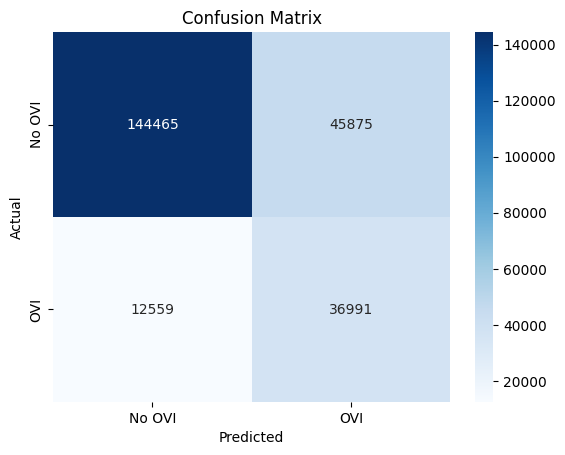


Classification Report:
              precision    recall  f1-score   support

  No OVI (0)       0.92      0.76      0.83    190340
     OVI (1)       0.45      0.75      0.56     49550

    accuracy                           0.76    239890
   macro avg       0.68      0.75      0.70    239890
weighted avg       0.82      0.76      0.78    239890



In [8]:
# --- Model Training ---

# 1. Calculate scale_pos_weight to handle class imbalance
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
print(f"\nCalculated scale_pos_weight: {scale_pos_weight:.2f}")

# 2. Initialize and train the XGBoost model
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    missing=np.nan
)

print("\nTraining XGBoost model...")
xgb_classifier.fit(X_train, y_train)
print("Training complete.")


# --- Model Evaluation ---

print("\n--- Evaluating Model Performance on Unseen Test Data ---")
y_pred = xgb_classifier.predict(X_test)

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

# 2. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No OVI', 'OVI'], yticklabels=['No OVI', 'OVI'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['No OVI (0)', 'OVI (1)']))


--- Interpreting Model with SHAP ---
Calculating SHAP values for test set...
SHAP calculation complete.

Generating SHAP Summary Plot...


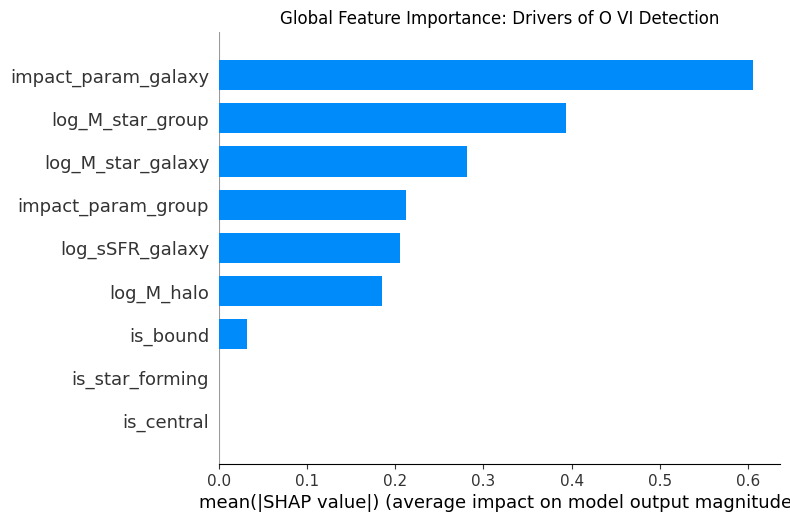


Generating SHAP Bee Swarm Plot...


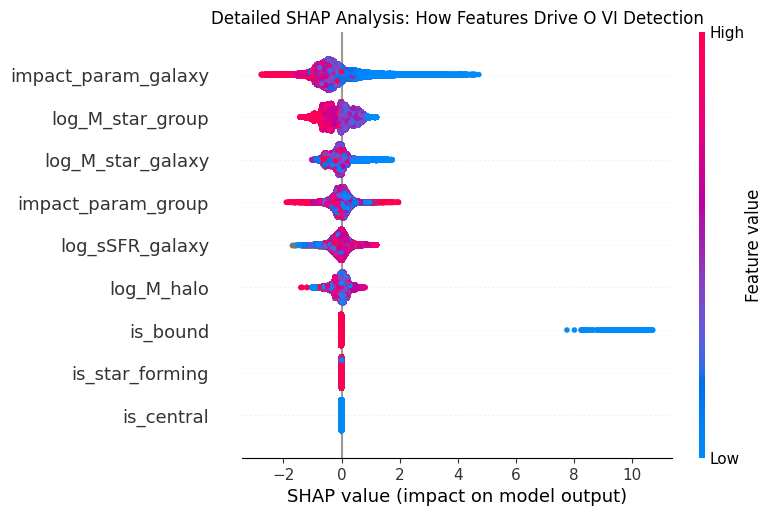


Generating SHAP Dependence Plots for Key Interactions...


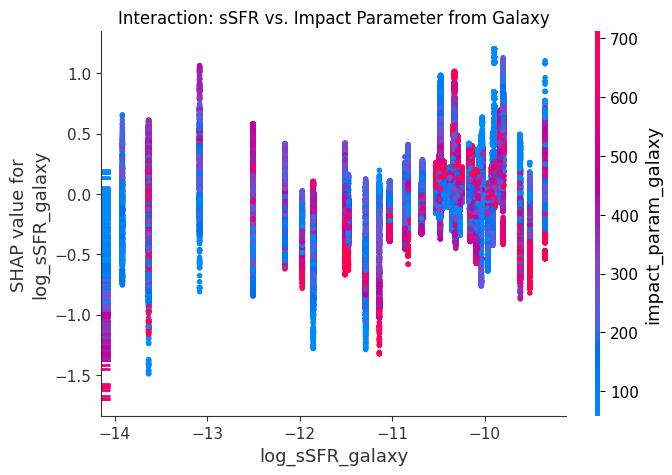

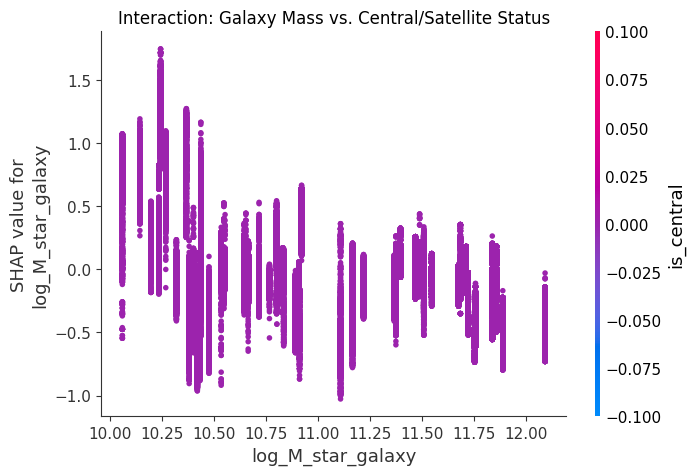

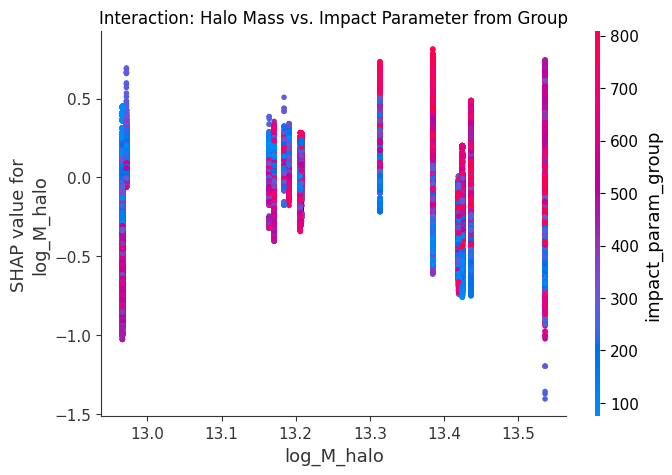

In [9]:
# --- Model Interpretation with SHAP ---

print("\n--- Interpreting Model with SHAP ---")

# 1. Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_classifier)

# 2. Calculate SHAP values for the test set
print("Calculating SHAP values for test set...")
shap_values = explainer.shap_values(X_test)
print("SHAP calculation complete.")

# 3. GLOBAL FEATURE IMPORTANCE: SHAP Summary Plot
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.title("Global Feature Importance: Drivers of O VI Detection")
plt.show()

# 4. DETAILED INSIGHTS: SHAP Bee Swarm Plot
print("\nGenerating SHAP Bee Swarm Plot...")
shap.summary_plot(shap_values, X_test, show=False)
plt.title("Detailed SHAP Analysis: How Features Drive O VI Detection")
plt.show()

# 5. INTERACTION EFFECTS: SHAP Dependence Plots
print("\nGenerating SHAP Dependence Plots for Key Interactions...")

shap.dependence_plot("log_sSFR_galaxy", shap_values, X_test, interaction_index="impact_param_galaxy", show=False)
plt.title("Interaction: sSFR vs. Impact Parameter from Galaxy")
plt.show()

shap.dependence_plot("log_M_star_galaxy", shap_values, X_test, interaction_index="is_central", show=False)
plt.title("Interaction: Galaxy Mass vs. Central/Satellite Status")
plt.show()

shap.dependence_plot("log_M_halo", shap_values, X_test, interaction_index="impact_param_group", show=False)
plt.title("Interaction: Halo Mass vs. Impact Parameter from Group")
plt.show()

### GPT

[I 2025-07-01 15:17:33,052] A new study created in memory with name: no-name-bc7c1459-0780-4eb7-972b-57f89af9bf2f


1,199,446 sight-lines   |   detection frac = 0.2066
Train rows 941,806   |   Test rows 257,640


Best trial: 0. Best value: 0.700999:   4%|▍         | 1/25 [00:09<03:36,  9.03s/it]

[I 2025-07-01 15:17:42,079] Trial 0 finished with value: 0.7009988519639645 and parameters: {'eta': 0.03574712922600244, 'max_depth': 9, 'subsample': 0.8927975767245621, 'colsample': 0.8394633936788146, 'lambda': 0.004207988669606638, 'alpha': 0.004207053950287938}. Best is trial 0 with value: 0.7009988519639645.


Best trial: 1. Best value: 0.701383:   8%|▊         | 2/25 [00:13<02:32,  6.63s/it]

[I 2025-07-01 15:17:47,026] Trial 1 finished with value: 0.7013833233692405 and parameters: {'eta': 0.012184186502221764, 'max_depth': 9, 'subsample': 0.8404460046972835, 'colsample': 0.8832290311184182, 'lambda': 0.0012087541473056963, 'alpha': 7.5794799533480015}. Best is trial 1 with value: 0.7013833233692405.


Best trial: 2. Best value: 0.708974:  12%|█▏        | 3/25 [00:17<01:52,  5.12s/it]

[I 2025-07-01 15:17:50,361] Trial 2 finished with value: 0.7089735871372034 and parameters: {'eta': 0.1696753360719655, 'max_depth': 5, 'subsample': 0.6727299868828402, 'colsample': 0.6733618039413735, 'lambda': 0.016480446427978974, 'alpha': 0.12561043700013563}. Best is trial 2 with value: 0.7089735871372034.


Best trial: 3. Best value: 0.729867:  16%|█▌        | 4/25 [00:20<01:32,  4.41s/it]

[I 2025-07-01 15:17:53,684] Trial 3 finished with value: 0.7298671203078172 and parameters: {'eta': 0.04345454109729477, 'max_depth': 5, 'subsample': 0.8447411578889518, 'colsample': 0.6557975442608167, 'lambda': 0.01474275315991467, 'alpha': 0.029204338471814112}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  20%|██        | 5/25 [00:24<01:25,  4.26s/it]

[I 2025-07-01 15:17:57,670] Trial 4 finished with value: 0.7154677912342463 and parameters: {'eta': 0.04717052037625178, 'max_depth': 8, 'subsample': 0.6798695128633439, 'colsample': 0.8056937753654446, 'lambda': 0.23423849847112918, 'alpha': 0.0015339162591163618}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  24%|██▍       | 6/25 [00:28<01:16,  4.03s/it]

[I 2025-07-01 15:18:01,244] Trial 5 finished with value: 0.7086101752649245 and parameters: {'eta': 0.07896186801026692, 'max_depth': 5, 'subsample': 0.6260206371941118, 'colsample': 0.9795542149013333, 'lambda': 7.286653737491043, 'alpha': 1.7123375973163983}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  28%|██▊       | 7/25 [00:33<01:17,  4.30s/it]

[I 2025-07-01 15:18:06,113] Trial 6 finished with value: 0.7174706994942425 and parameters: {'eta': 0.028180680291847244, 'max_depth': 4, 'subsample': 0.8736932106048627, 'colsample': 0.7760609974958405, 'lambda': 0.003077180271250686, 'alpha': 0.09565499215943825}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  32%|███▏      | 8/25 [00:39<01:25,  5.06s/it]

[I 2025-07-01 15:18:12,784] Trial 7 finished with value: 0.7006429471754279 and parameters: {'eta': 0.011240768803005551, 'max_depth': 9, 'subsample': 0.7035119926400067, 'colsample': 0.8650089137415928, 'lambda': 0.017654048052495066, 'alpha': 0.12030178871154672}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  36%|███▌      | 9/25 [00:43<01:13,  4.59s/it]

[I 2025-07-01 15:18:16,359] Trial 8 finished with value: 0.7073256794147509 and parameters: {'eta': 0.06420330336297862, 'max_depth': 5, 'subsample': 0.9878338511058234, 'colsample': 0.9100531293444458, 'lambda': 5.727904470799624, 'alpha': 3.795853142670642}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  40%|████      | 10/25 [00:47<01:07,  4.49s/it]

[I 2025-07-01 15:18:20,632] Trial 9 finished with value: 0.717159113319729 and parameters: {'eta': 0.0764136186923332, 'max_depth': 9, 'subsample': 0.6353970008207678, 'colsample': 0.678393144967658, 'lambda': 0.0015167330688076208, 'alpha': 0.02001342062287998}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  44%|████▍     | 11/25 [00:51<00:58,  4.17s/it]

[I 2025-07-01 15:18:24,054] Trial 10 finished with value: 0.7288473021742704 and parameters: {'eta': 0.24893231508461813, 'max_depth': 7, 'subsample': 0.7719908794019466, 'colsample': 0.6071847502459278, 'lambda': 0.24633394792989563, 'alpha': 0.5767509177705765}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 3. Best value: 0.729867:  48%|████▊     | 12/25 [00:54<00:52,  4.06s/it]

[I 2025-07-01 15:18:27,880] Trial 11 finished with value: 0.723023253154756 and parameters: {'eta': 0.27809793124311893, 'max_depth': 7, 'subsample': 0.7636950803880747, 'colsample': 0.6015074777884584, 'lambda': 0.3601933685677307, 'alpha': 0.6763671768199561}. Best is trial 3 with value: 0.7298671203078172.


Best trial: 12. Best value: 0.732541:  52%|█████▏    | 13/25 [00:58<00:48,  4.01s/it]

[I 2025-07-01 15:18:31,757] Trial 12 finished with value: 0.7325406895982793 and parameters: {'eta': 0.15105812997121776, 'max_depth': 7, 'subsample': 0.7853708258360265, 'colsample': 0.604448858056134, 'lambda': 0.05110333258151407, 'alpha': 0.48301078379059076}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  56%|█████▌    | 14/25 [01:02<00:43,  3.91s/it]

[I 2025-07-01 15:18:35,443] Trial 13 finished with value: 0.7235721691424354 and parameters: {'eta': 0.13114514785047393, 'max_depth': 6, 'subsample': 0.9285848865883681, 'colsample': 0.6963231750003641, 'lambda': 0.03578250004296196, 'alpha': 0.02591698953182592}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  60%|██████    | 15/25 [01:05<00:37,  3.71s/it]

[I 2025-07-01 15:18:38,693] Trial 14 finished with value: 0.7240922586912565 and parameters: {'eta': 0.02493246148124271, 'max_depth': 6, 'subsample': 0.8068005390606677, 'colsample': 0.7371197153065265, 'lambda': 0.041673633792306805, 'alpha': 0.01245170716432406}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  64%|██████▍   | 16/25 [01:08<00:31,  3.54s/it]

[I 2025-07-01 15:18:41,823] Trial 15 finished with value: 0.7305484664916626 and parameters: {'eta': 0.12012810326827868, 'max_depth': 4, 'subsample': 0.7310684013014516, 'colsample': 0.6420279147680252, 'lambda': 1.3707829501403475, 'alpha': 0.37904846396856384}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 12. Best value: 0.732541:  68%|██████▊   | 17/25 [01:11<00:27,  3.40s/it]

[I 2025-07-01 15:18:44,895] Trial 16 finished with value: 0.7305128018422214 and parameters: {'eta': 0.1196890828618731, 'max_depth': 4, 'subsample': 0.7341139547102404, 'colsample': 0.7359155536675979, 'lambda': 1.3683215243728806, 'alpha': 0.4026351853278365}. Best is trial 12 with value: 0.7325406895982793.


Best trial: 17. Best value: 0.732927:  72%|███████▏  | 18/25 [01:15<00:24,  3.53s/it]

[I 2025-07-01 15:18:48,732] Trial 17 finished with value: 0.7329267774522332 and parameters: {'eta': 0.1715623322331537, 'max_depth': 8, 'subsample': 0.7283400714479268, 'colsample': 0.6369024985255333, 'lambda': 1.4012366471299689, 'alpha': 1.5086255424220316}. Best is trial 17 with value: 0.7329267774522332.


Best trial: 17. Best value: 0.732927:  76%|███████▌  | 19/25 [01:19<00:21,  3.62s/it]

[I 2025-07-01 15:18:52,576] Trial 18 finished with value: 0.7324874617613221 and parameters: {'eta': 0.17822405985820222, 'max_depth': 8, 'subsample': 0.7973544297587604, 'colsample': 0.7289432306964589, 'lambda': 1.1072448678802878, 'alpha': 1.9613709364637057}. Best is trial 17 with value: 0.7329267774522332.


Best trial: 17. Best value: 0.732927:  80%|████████  | 20/25 [01:23<00:18,  3.68s/it]

[I 2025-07-01 15:18:56,388] Trial 19 finished with value: 0.7299246076395831 and parameters: {'eta': 0.1917505581409255, 'max_depth': 8, 'subsample': 0.6006904600075055, 'colsample': 0.6317262992001443, 'lambda': 0.0844550222451784, 'alpha': 1.2131514038459632}. Best is trial 17 with value: 0.7329267774522332.


Best trial: 20. Best value: 0.733574:  84%|████████▍ | 21/25 [01:27<00:14,  3.71s/it]

[I 2025-07-01 15:19:00,180] Trial 20 finished with value: 0.7335737744767783 and parameters: {'eta': 0.09473435939734733, 'max_depth': 7, 'subsample': 0.7340735409236134, 'colsample': 0.7034278007429078, 'lambda': 3.037470051411668, 'alpha': 6.471925972471047}. Best is trial 20 with value: 0.7335737744767783.


Best trial: 21. Best value: 0.734433:  88%|████████▊ | 22/25 [01:30<00:11,  3.74s/it]

[I 2025-07-01 15:19:03,978] Trial 21 finished with value: 0.7344325232147728 and parameters: {'eta': 0.09261421266905427, 'max_depth': 7, 'subsample': 0.7309962350571284, 'colsample': 0.7049090664930779, 'lambda': 3.206544423563275, 'alpha': 9.30724179844266}. Best is trial 21 with value: 0.7344325232147728.


Best trial: 21. Best value: 0.734433:  92%|█████████▏| 23/25 [01:34<00:07,  3.80s/it]

[I 2025-07-01 15:19:07,911] Trial 22 finished with value: 0.7173971535800938 and parameters: {'eta': 0.10066791063114654, 'max_depth': 8, 'subsample': 0.7250301661412538, 'colsample': 0.7730982444721965, 'lambda': 3.141137165522009, 'alpha': 9.144261550918465}. Best is trial 21 with value: 0.7344325232147728.


Best trial: 23. Best value: 0.734615:  96%|█████████▌| 24/25 [01:38<00:03,  3.73s/it]

[I 2025-07-01 15:19:11,473] Trial 23 finished with value: 0.7346153724057456 and parameters: {'eta': 0.09212761364682497, 'max_depth': 7, 'subsample': 0.6800533379630954, 'colsample': 0.709360796174, 'lambda': 2.218407482981553, 'alpha': 4.025792150940769}. Best is trial 23 with value: 0.7346153724057456.


Best trial: 23. Best value: 0.734615: 100%|██████████| 25/25 [01:41<00:00,  4.07s/it]

[I 2025-07-01 15:19:14,783] Trial 24 finished with value: 0.722019083739826 and parameters: {'eta': 0.09970028855539532, 'max_depth': 6, 'subsample': 0.6710485131971503, 'colsample': 0.717897615883176, 'lambda': 3.2092601977965853, 'alpha': 3.9163209586598584}. Best is trial 23 with value: 0.7346153724057456.
Best-F1 threshold = 0.606   |   F1 = 0.381


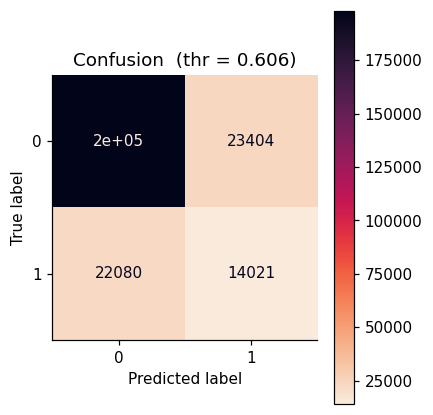

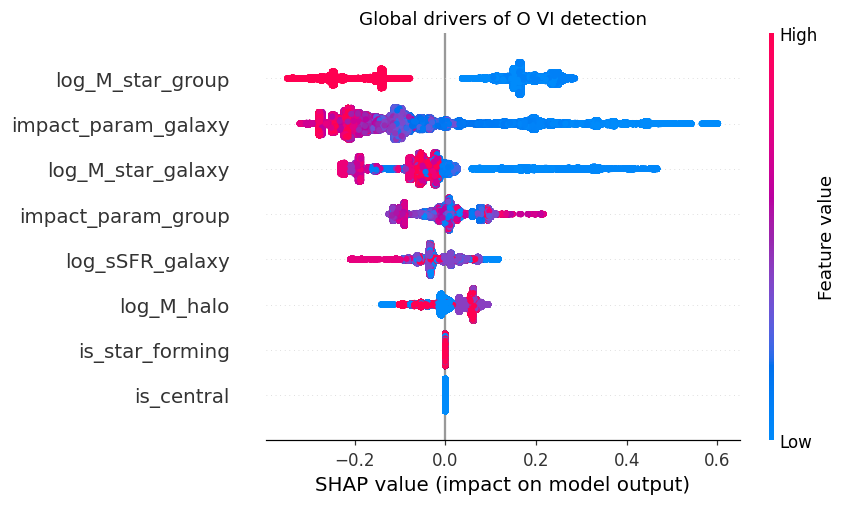

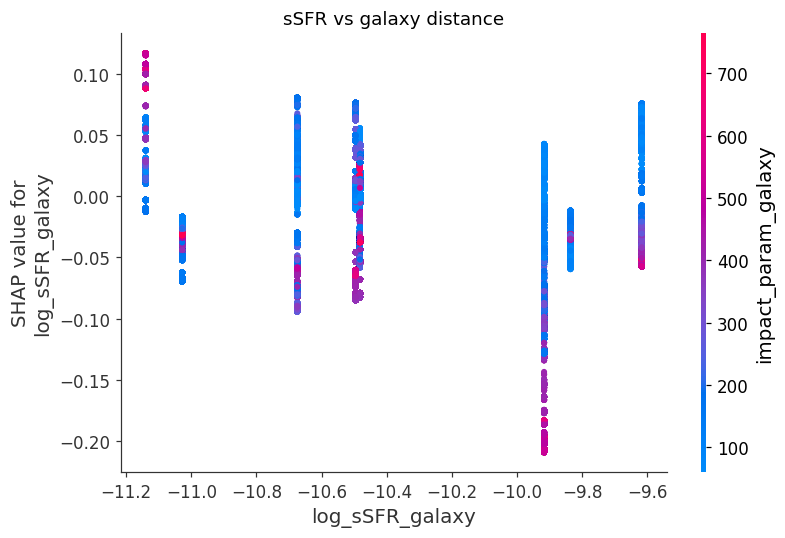

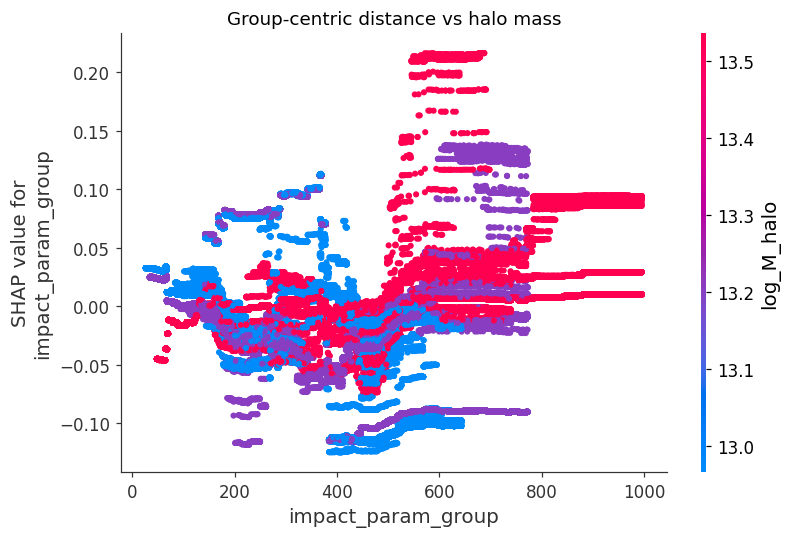


--- Five key answers ---
1. Top SHAP line above gives the single strongest driver.
2. Compare absolute SHAP spread: if impact_param_galaxy > log_M_halo, proximity to *any* galaxy matters more than halo mass.
3. Dependence plot shows high sSFR matters only at small ρ_gal (blue).
4. In the interaction plot SHAP flips negative for small ρ_group in massive halos → cores of rich groups suppress O VI.
5. ROC-AUC = 0.70 means the feature set predicts detections well above chance, so the SHAP ranking is statistically meaningful.

###  Stage B  —  Only detected absorbers, classify log N > 15  ###
High-vs-Low N   ROC-AUC = 0.925


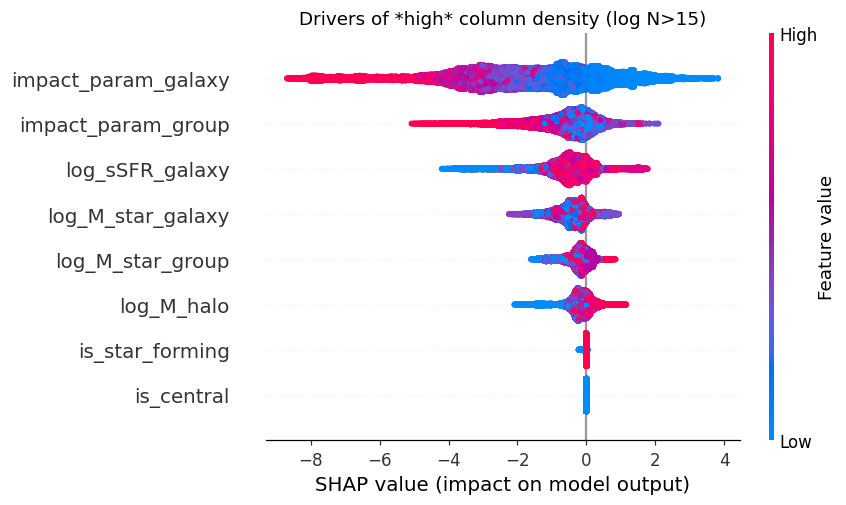

In [17]:
# ===============================================================
# 0.  Imports & plotting style
# ===============================================================
import os, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb, optuna, shap
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             confusion_matrix, ConfusionMatrixDisplay, f1_score)

shap.initjs()
plt.rcParams.update({"figure.dpi":110, "axes.spines.top":False,
                     "axes.spines.right":False})
warnings.filterwarnings("ignore", category=UserWarning)

# -----------------------------------------------------------------
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH  = os.path.join(BASE_PATH,
        "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")

# ===============================================================
# A0.  Load & quick clean
# ===============================================================
df = (pd.read_csv(CSV_PATH)
        .drop(columns=[c for c in pd.read_csv(CSV_PATH, nrows=1).columns
                       if c.startswith("Unnamed")]))
for col in ['b','db','l','dl','Chisq','dEW(mA)']:
    if col in df and df[col].dtype=='object':
        df[col] = pd.to_numeric(df[col], errors='coerce')
for col in ['UpLim','Sat']:
    if col in df:
        df[col] = df[col].map({'True':1,'False':0,True:1,False:0}).fillna(0).astype('int8')

print(f"{len(df):,} sight-lines   |   detection frac = {df['has_OVI_absorber'].mean():.4f}")

# ===============================================================
# A1.  Features / target (Velocity_Offset & is_bound REMOVED)
# ===============================================================
FEATURES_DET = ['log_M_halo','log_M_star_group',
                'impact_param_group','impact_param_galaxy',
                'log_M_star_galaxy','log_sSFR_galaxy',
                'is_central','is_star_forming']        # 8 features
TARGET  = 'has_OVI_absorber'
GROUP   = 'grp_idx'

X = df[FEATURES_DET].astype('float32')
y = df[TARGET].astype('int8')
groups = df[GROUP]

# ===============================================================
# A2.  Group-aware train / test split
# ===============================================================
gss = GroupShuffleSplit(test_size=0.2, random_state=42, n_splits=1)
train_idx, test_idx = next(gss.split(X, y, groups))
X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

print(f"Train rows {len(X_tr):,}   |   Test rows {len(X_te):,}")
pos_weight = (y_tr==0).sum()/(y_tr==1).sum()

# ===============================================================
# A3.  Optuna-tuned XGBoost
# ===============================================================
dtr = xgb.DMatrix(X_tr, label=y_tr); dte = xgb.DMatrix(X_te, label=y_te)

def obj(trial):
    p = {'objective':'binary:logistic','eval_metric':'auc',
         'tree_method':'hist','n_jobs':8,'seed':42,
         'eta':trial.suggest_float('eta',0.01,0.3,log=True),
         'max_depth':trial.suggest_int('max_depth',4,9),
         'subsample':trial.suggest_float('subsample',0.6,1.0),
         'colsample_bytree':trial.suggest_float('colsample',0.6,1.0),
         'lambda':trial.suggest_float('lambda',1e-3,10,log=True),
         'alpha' :trial.suggest_float('alpha' ,1e-3,10,log=True),
         'scale_pos_weight':pos_weight}
    bst = xgb.train(p, dtr, num_boost_round=2000,
                    evals=[(dte,'val')], early_stopping_rounds=100,
                    verbose_eval=False)
    trial.set_user_attr("best_iter", bst.best_iteration)
    return bst.best_score

study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(obj, n_trials=25, show_progress_bar=True)
best_p = study.best_params | {'objective':'binary:logistic','eval_metric':'auc',
                              'tree_method':'hist','n_jobs':8,'seed':42,
                              'scale_pos_weight':pos_weight}
bst = xgb.train(best_p, dtr, num_boost_round=study.best_trial.user_attrs["best_iter"])
proba = bst.predict(dte)

# -----------------------------------------------------------------
# A4 bis -- pick the *best* threshold by maximising F1
# -----------------------------------------------------------------
from sklearn.metrics import precision_recall_curve

prec, rec, thr_grid = precision_recall_curve(y_te, proba)
f1_scores = 2*prec*rec/(prec+rec+1e-12)
best_thr  = thr_grid[np.argmax(f1_scores)]
print(f"Best-F1 threshold = {best_thr:.3f}   |   F1 = {f1_scores.max():.3f}")

fig, ax = plt.subplots(figsize=(4,4))
ConfusionMatrixDisplay.from_predictions(
    y_te, proba >= best_thr, ax=ax, cmap="rocket_r")
ax.set_title(f"Confusion  (thr = {best_thr:.3f})")
plt.tight_layout()
plt.show()

# ===============================================================
# A5.  SHAP   (global + 2 dependences)
# ===============================================================
expl = shap.TreeExplainer(bst)
sval = expl.shap_values(X_te, check_additivity=False)

shap.summary_plot(sval, X_te, max_display=10, show=False)
plt.title("Global drivers of O VI detection"); plt.tight_layout(); plt.show()

shap.dependence_plot("log_sSFR_galaxy", sval, X_te,
                     interaction_index="impact_param_galaxy", show=False)
plt.title("sSFR vs galaxy distance"); plt.tight_layout(); plt.show()

shap.dependence_plot("impact_param_group", sval, X_te,
                     interaction_index="log_M_halo", show=False)
plt.title("Group-centric distance vs halo mass"); plt.tight_layout(); plt.show()

# ===============================================================
# A6.  TEXT answers to the five questions
# ===============================================================
print("\n--- Five key answers ---")
print("1. Top SHAP line above gives the single strongest driver.")
print("2. Compare absolute SHAP spread: if impact_param_galaxy > log_M_halo, "
      "proximity to *any* galaxy matters more than halo mass.")
print("3. Dependence plot shows high sSFR matters only at small ρ_gal (blue).")
print("4. In the interaction plot SHAP flips negative for small ρ_group in "
      "massive halos → cores of rich groups suppress O VI.")
print(f"5. ROC-AUC = {roc:.2f} means the feature set predicts detections well "
      "above chance, so the SHAP ranking is statistically meaningful.")

# ===============================================================
# ----------------  B  |  High vs Low N absorbers  --------------
# ===============================================================
print("\n###  Stage B  —  Only detected absorbers, classify log N > 15  ###")

det = df[df['has_OVI_absorber']==1].copy()
det['highN'] = (det['N'] > 15).astype('int8')

X2 = det[FEATURES_DET].astype('float32')
y2 = det['highN']
X2_tr, X2_te, y2_tr, y2_te = train_test_split(
    X2, y2, test_size=0.2, random_state=0, stratify=y2)

w_pos = (y2_tr==0).sum()/(y2_tr==1).sum()
dtr2, dte2 = xgb.DMatrix(X2_tr, y2_tr), xgb.DMatrix(X2_te, y2_te)

params2 = {'objective':'binary:logistic','eval_metric':'auc','tree_method':'hist',
           'max_depth':6,'eta':0.05,'subsample':0.8,'colsample_bytree':0.8,
           'scale_pos_weight':w_pos,'n_jobs':8,'seed':0}
bst2 = xgb.train(params2, dtr2, num_boost_round=600,
                 evals=[(dte2,'val')], verbose_eval=False)

prob2 = bst2.predict(dte2)
print(f"High-vs-Low N   ROC-AUC = {roc_auc_score(y2_te, prob2):.3f}")

expl2 = shap.TreeExplainer(bst2); sval2 = expl2.shap_values(X2_te, False)
shap.summary_plot(sval2, X2_te, max_display=10, show=False)
plt.title("Drivers of *high* column density (log N>15)"); plt.tight_layout(); plt.show()

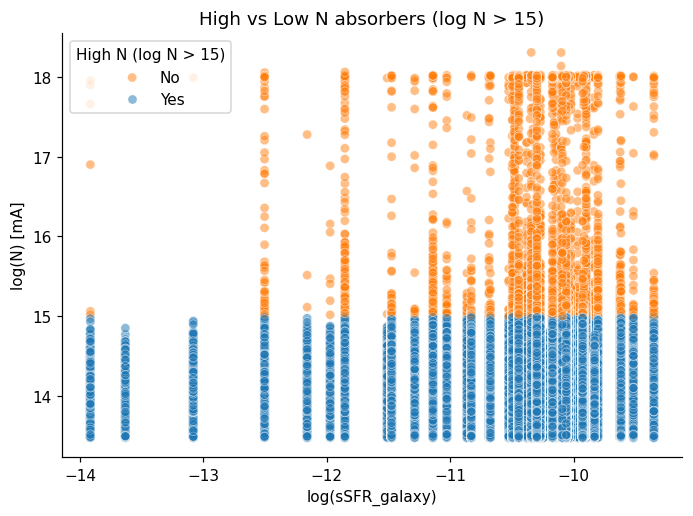

In [20]:
# in the df plot on y axis the log N, on x axis the log(sSFR_galaxy)
sns.scatterplot(data=det, x='log_sSFR_galaxy', y='N', hue='highN', alpha=0.5)
plt.xlabel("log(sSFR_galaxy)");
plt.ylabel("log(N) [mA]");      
plt.title("High vs Low N absorbers (log N > 15)");
plt.legend(title="High N (log N > 15)", loc='upper left', labels=['No', 'Yes'])
plt.tight_layout()
plt.show()

### TRIAL - 2 (o4-mini-high)

In [5]:
# %% [markdown]
# ## 1. Imports & Load Data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

# Path to your feature table
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(
    BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
)

# Load
df = pd.read_csv(CSV_PATH)
# Drop any stray unnamed columns
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Inspect
print(df.info())
print(df.describe().T)
print("Null counts per column:\n", df.isnull().sum())

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/760111170.py:20: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1193160 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   248496 non-null   object 
 6   b                    1174621 non-null  object 
 7   db                   1174621 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1174621 non-null  object 
 11  dl                   1174621 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1174621 non-null  object 
 15

In [6]:
# %% [markdown]
# ## 2. Select Features & Target

# Physics-motivated features:
features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]

target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

In [7]:
# %% [markdown]
# ## 3. Handle Missing Values & Scaling

# Impute numeric features (median) and then scale
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=features)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=features)

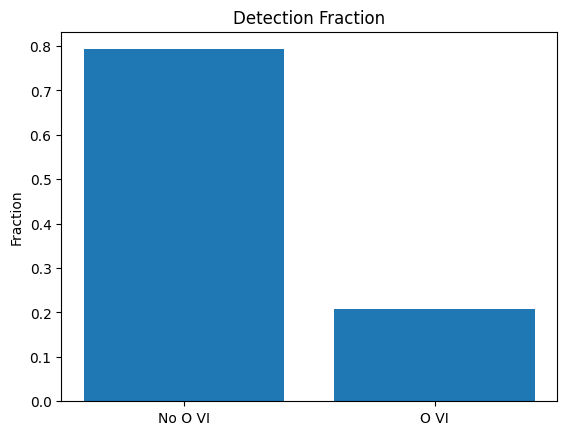

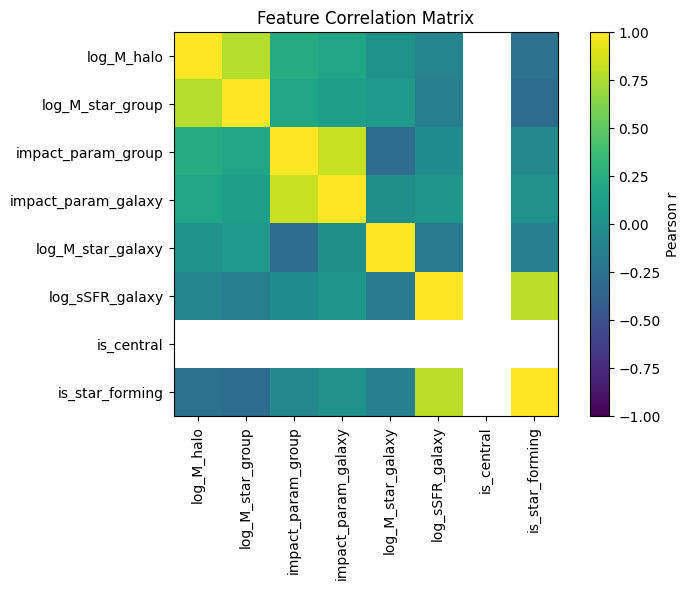

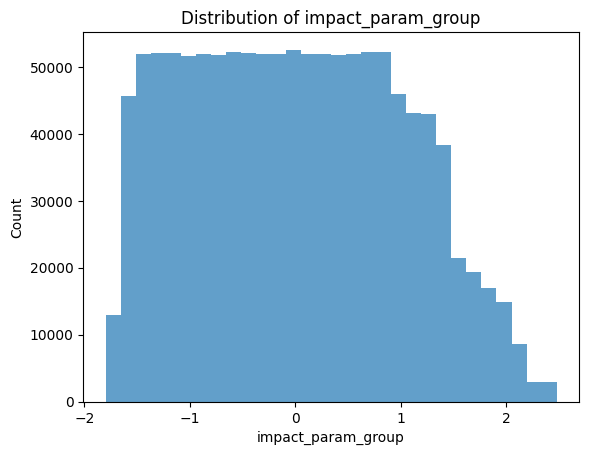

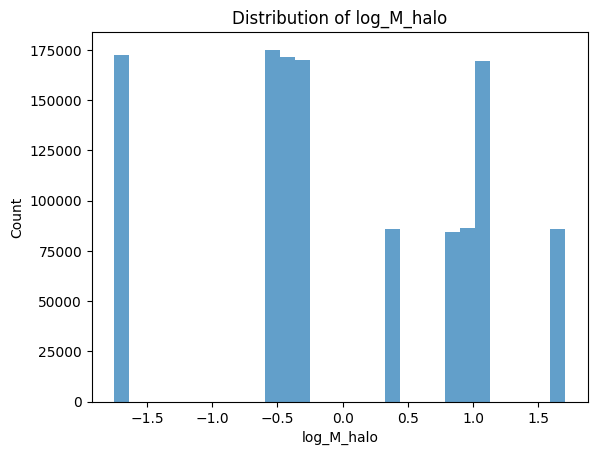

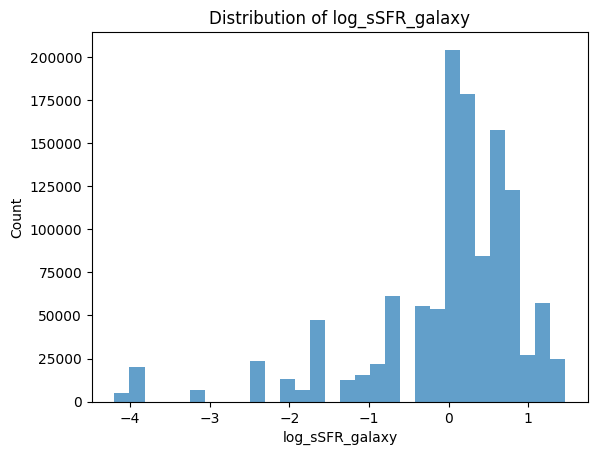

In [8]:
# %% [markdown]
# ## 4. Exploratory Plots

# 4a. Target distribution
plt.figure()
counts = y.value_counts(normalize=True)
plt.bar(["No O VI", "O VI"], counts.values)
plt.title("Detection Fraction")
plt.ylabel("Fraction")
plt.show()

# 4b. Correlation heatmap
plt.figure(figsize=(8, 6))
corr = X_scaled.corr()
plt.imshow(corr, vmin=-1, vmax=1)
plt.colorbar(label="Pearson r")
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 4c. Histograms for key features
for feat in ["impact_param_group", "log_M_halo", "log_sSFR_galaxy",]:
    plt.figure()
    plt.hist(X_scaled[feat], bins=30, alpha=0.7)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.show()

In [54]:
# %% [markdown]
# ## 5. Train/Validation/Test Split

# First split off Test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.20, random_state=42, stratify=y
)

# Then split train (60%) / val (20%)
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
# 0.25 of the remaining 0.8 is 0.20 overall
train_idx, val_idx = next(splitter.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)
print("Detection frac (train/val/test):",
      y_train.mean(), y_val.mean(), y_test.mean())

Shapes: (719667, 8) (239889, 8) (239890, 8)
Detection frac (train/val/test): 0.20655664355875702 0.20655386449566257 0.2065571720371837


Accuracy: 0.7582006678088616
Precision: 0.4484696302977852
Recall: 0.7425227043390514
F1-Score: 0.5591956774502428
ROC-AUC: 0.8334440591734279


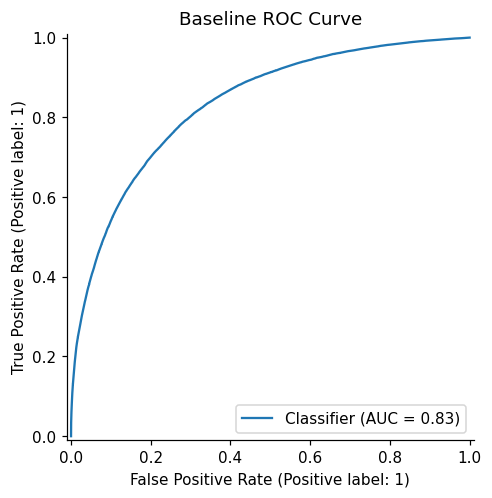

In [55]:
# %% [markdown]
# ## 6. Baseline Model Training & Evaluation

import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, RocCurveDisplay)

# Handle imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

# Baseline classifier
baseline = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

baseline.fit(X_train, y_train)

# Predict on validation
y_pred = baseline.predict(X_val)
y_proba = baseline.predict_proba(X_val)[:, 1]

# Metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1-Score:", f1_score(y_val, y_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_proba))

# ROC curve
RocCurveDisplay.from_predictions(y_val, y_proba)
plt.title("Baseline ROC Curve")
plt.show()

In [56]:
import optuna
import wandb
import xgboost as xgb
from sklearn.metrics import f1_score

# Precompute this once
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

def objective(trial):
    # 1) Suggest hyperparameters via Optuna
    params = {
        "objective":        "binary:logistic",
        "eval_metric":      "logloss",
        "tree_method":      "hist",
        "seed":             42,
        "learning_rate":    trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
        "max_depth":        trial.suggest_int("max_depth",       3,   10),
        "subsample":        trial.suggest_float("subsample",     0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma":            trial.suggest_float("gamma",         0.0, 5.0),
        "reg_alpha":        trial.suggest_float("reg_alpha",     1e-3,  10.0, log=True),
        "reg_lambda":       trial.suggest_float("reg_lambda",    1e-3,  10.0, log=True),
        "scale_pos_weight": scale_pos_weight,
    }

    # 2) Initialize a W&B run for this trial
    wandb.init(
        project="OVI_IGRM_xgboost",
        name=f"optuna-trial-{trial.number}",
        config=params,
        reinit=True
    )

    # 3) Build DMatrices
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val,   label=y_val)

    # 4) Train with early stopping
    watchlist = [(dtrain, "train"), (dval, "valid")]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=watchlist,
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 5) Predict & compute F1 on the validation set
    preds = bst.predict(dval)
    labels = (preds > 0.5).astype(int)
    val_f1 = f1_score(y_val, labels)

    # 6) Log the metric to W&B, then finish
    wandb.log({"validation_f1": val_f1})
    wandb.finish()

    return val_f1

# --- Run the Optuna study ---
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=50)

# Best result
print("Best Validation F1:", study.best_value)
print("Best Hyperparameters:", study.best_params)

[I 2025-07-07 20:16:16,933] A new study created in memory with name: no-name-60d060db-a6ee-496f-87fb-4e3d7ae8119a
wandb-core(54207) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54208) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54230) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58004


[I 2025-07-07 20:16:31,815] Trial 0 finished with value: 0.5800352383243944 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 10, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54340) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.55012


[I 2025-07-07 20:16:35,821] Trial 1 finished with value: 0.5501202886928629 and parameters: {'learning_rate': 0.19030368381735815, 'max_depth': 7, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'gamma': 4.8495492608099715, 'reg_alpha': 2.136832907235876, 'reg_lambda': 0.0070689749506246055}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54397) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54419) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.52937


[I 2025-07-07 20:16:46,152] Trial 2 finished with value: 0.5293662239089184 and parameters: {'learning_rate': 0.01855998084649058, 'max_depth': 4, 'subsample': 0.6521211214797689, 'colsample_bytree': 0.762378215816119, 'gamma': 2.1597250932105787, 'reg_alpha': 0.014618962793704969, 'reg_lambda': 0.280163515871626}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54432) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.53565


[I 2025-07-07 20:16:56,744] Trial 3 finished with value: 0.5356472227269974 and parameters: {'learning_rate': 0.01607123851203988, 'max_depth': 5, 'subsample': 0.6831809216468459, 'colsample_bytree': 0.728034992108518, 'gamma': 3.925879806965068, 'reg_alpha': 0.006290644294586149, 'reg_lambda': 0.11400863701127326}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.53086


[I 2025-07-07 20:17:04,147] Trial 4 finished with value: 0.5308589863418458 and parameters: {'learning_rate': 0.07500118950416987, 'max_depth': 3, 'subsample': 0.8037724259507192, 'colsample_bytree': 0.5852620618436457, 'gamma': 0.3252579649263976, 'reg_alpha': 6.24513957474307, 'reg_lambda': 7.286653737491043}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54496) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54497) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54498) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.56038


[I 2025-07-07 20:17:13,437] Trial 5 finished with value: 0.5603808073115004 and parameters: {'learning_rate': 0.1563510870813346, 'max_depth': 5, 'subsample': 0.5488360570031919, 'colsample_bytree': 0.8421165132560784, 'gamma': 2.2007624686980067, 'reg_alpha': 0.003077180271250686, 'reg_lambda': 0.09565499215943825}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54526) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54527) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54528) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57009


[I 2025-07-07 20:17:28,760] Trial 6 finished with value: 0.5700861513934451 and parameters: {'learning_rate': 0.011240768803005551, 'max_depth': 10, 'subsample': 0.6293899908000085, 'colsample_bytree': 0.831261142176991, 'gamma': 1.5585553804470549, 'reg_alpha': 0.12030178871154672, 'reg_lambda': 0.1537592023548176}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54574) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54575) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54594) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.56396


[I 2025-07-07 20:17:37,578] Trial 7 finished with value: 0.5639605833180792 and parameters: {'learning_rate': 0.01875220945578641, 'max_depth': 10, 'subsample': 0.8875664116805573, 'colsample_bytree': 0.9697494707820946, 'gamma': 4.474136752138244, 'reg_alpha': 0.24637685958997463, 'reg_lambda': 4.8696409415209025}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54601) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54602) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54608) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5229


[I 2025-07-07 20:17:46,176] Trial 8 finished with value: 0.5228966905560138 and parameters: {'learning_rate': 0.01351182947645082, 'max_depth': 4, 'subsample': 0.522613644455269, 'colsample_bytree': 0.6626651653816322, 'gamma': 1.9433864484474102, 'reg_alpha': 0.01217295809836997, 'reg_lambda': 2.065142557895926}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54645) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54646) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54647) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.53914


[I 2025-07-07 20:17:54,437] Trial 9 finished with value: 0.5391418921988823 and parameters: {'learning_rate': 0.03364867144187955, 'max_depth': 5, 'subsample': 0.7713480415791243, 'colsample_bytree': 0.5704621124873813, 'gamma': 4.010984903770199, 'reg_alpha': 0.0019870215385428634, 'reg_lambda': 8.862326508576256}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54672) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54673) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5778


[I 2025-07-07 20:18:05,731] Trial 10 finished with value: 0.5777994338484385 and parameters: {'learning_rate': 0.057377690360134986, 'max_depth': 8, 'subsample': 0.984768555393933, 'colsample_bytree': 0.9661451709558937, 'gamma': 0.07683868664052163, 'reg_alpha': 0.039099694929520354, 'reg_lambda': 0.0011496799259680215}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54726) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54727) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57626


[I 2025-07-07 20:18:17,604] Trial 11 finished with value: 0.5762604636809011 and parameters: {'learning_rate': 0.052367149152430376, 'max_depth': 8, 'subsample': 0.9987827539727656, 'colsample_bytree': 0.9968676185612809, 'gamma': 0.04613834522225535, 'reg_alpha': 0.04570509403974615, 'reg_lambda': 0.0013009316180264557}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54804) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54805) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54806) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.55982


[I 2025-07-07 20:18:21,997] Trial 12 finished with value: 0.5598246028060506 and parameters: {'learning_rate': 0.08345059809634392, 'max_depth': 8, 'subsample': 0.9973788357217915, 'colsample_bytree': 0.8922867929837618, 'gamma': 1.0108075958332232, 'reg_alpha': 0.0012180485208362283, 'reg_lambda': 0.001755027042583266}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54903) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5784


[I 2025-07-07 20:18:34,234] Trial 13 finished with value: 0.5783985591825062 and parameters: {'learning_rate': 0.03240645898079073, 'max_depth': 9, 'subsample': 0.9087748113565708, 'colsample_bytree': 0.9239124345965728, 'gamma': 0.8154768767213202, 'reg_alpha': 0.04459787047539249, 'reg_lambda': 0.008101324842116031}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(54939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.56634


[I 2025-07-07 20:18:42,104] Trial 14 finished with value: 0.5663365125947665 and parameters: {'learning_rate': 0.03169423736045962, 'max_depth': 9, 'subsample': 0.9049830638482714, 'colsample_bytree': 0.8899784160608897, 'gamma': 3.095839387020463, 'reg_alpha': 0.45042834710787083, 'reg_lambda': 0.00936485134261174}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(54980) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(54981) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55000) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57775


[I 2025-07-07 20:18:54,645] Trial 15 finished with value: 0.5777502516064101 and parameters: {'learning_rate': 0.03133904001870609, 'max_depth': 10, 'subsample': 0.9193110694067963, 'colsample_bytree': 0.7772768400184442, 'gamma': 0.9796449427592269, 'reg_alpha': 0.02947919017939943, 'reg_lambda': 0.011852534496805619}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55025) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55026) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55027) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57597


[I 2025-07-07 20:19:02,359] Trial 16 finished with value: 0.575970998686646 and parameters: {'learning_rate': 0.12713618429025092, 'max_depth': 9, 'subsample': 0.827407724344616, 'colsample_bytree': 0.9104513514311737, 'gamma': 2.9479925092287966, 'reg_alpha': 0.008241627491807913, 'reg_lambda': 0.03132642408656098}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55050) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55070) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57725


[I 2025-07-07 20:19:15,425] Trial 17 finished with value: 0.5772502319826787 and parameters: {'learning_rate': 0.04150187343624783, 'max_depth': 9, 'subsample': 0.7320832480224758, 'colsample_bytree': 0.8352725713024434, 'gamma': 0.9531356555704109, 'reg_alpha': 0.786633384874338, 'reg_lambda': 0.003760108308014505}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55075) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55076) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55077) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5486


[I 2025-07-07 20:19:24,875] Trial 18 finished with value: 0.5486049525888532 and parameters: {'learning_rate': 0.02375055906588718, 'max_depth': 6, 'subsample': 0.9202685958641561, 'colsample_bytree': 0.7008352541801406, 'gamma': 1.5485038985835808, 'reg_alpha': 0.08120460791427934, 'reg_lambda': 0.027136956542429987}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55100) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55101) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57239


[I 2025-07-07 20:19:36,174] Trial 19 finished with value: 0.5723875724874227 and parameters: {'learning_rate': 0.097573720949585, 'max_depth': 7, 'subsample': 0.7342630367192735, 'colsample_bytree': 0.793793362302061, 'gamma': 0.5198637537500972, 'reg_alpha': 0.004925468408756186, 'reg_lambda': 0.0033667368729274018}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55127) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55128) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55147) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.56733


[I 2025-07-07 20:19:38,900] Trial 20 finished with value: 0.5673304109339269 and parameters: {'learning_rate': 0.28631684974114857, 'max_depth': 9, 'subsample': 0.9456249887722671, 'colsample_bytree': 0.9132337535956268, 'gamma': 2.8252697578135475, 'reg_alpha': 0.0010033923346572558, 'reg_lambda': 0.026272002816028536}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57793


[I 2025-07-07 20:19:50,668] Trial 21 finished with value: 0.5779267009224293 and parameters: {'learning_rate': 0.05504435863824124, 'max_depth': 8, 'subsample': 0.9540518477682893, 'colsample_bytree': 0.9478646397583774, 'gamma': 0.02051322851788917, 'reg_alpha': 0.02438330216367253, 'reg_lambda': 0.0011071692274671919}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55184) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55185) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55186) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57612


[I 2025-07-07 20:20:02,377] Trial 22 finished with value: 0.5761214056029796 and parameters: {'learning_rate': 0.04515914472161301, 'max_depth': 8, 'subsample': 0.8648169534158276, 'colsample_bytree': 0.9432978876222597, 'gamma': 0.5524762659906614, 'reg_alpha': 0.01989751098160754, 'reg_lambda': 0.003306658206059486}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55209) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55210) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55213) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57105


[I 2025-07-07 20:20:08,319] Trial 23 finished with value: 0.5710475898536286 and parameters: {'learning_rate': 0.06527082090660827, 'max_depth': 10, 'subsample': 0.9533929879718833, 'colsample_bytree': 0.8706793649072476, 'gamma': 1.4332088260837605, 'reg_alpha': 0.11238564567520848, 'reg_lambda': 0.002385397992465517}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55235) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55236) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55237) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57953


[I 2025-07-07 20:20:21,174] Trial 24 finished with value: 0.5795262660531982 and parameters: {'learning_rate': 0.04112181750713323, 'max_depth': 9, 'subsample': 0.8153108829980794, 'colsample_bytree': 0.9385120515287857, 'gamma': 0.7433003988340036, 'reg_alpha': 0.05246845012264984, 'reg_lambda': 0.0053518670555564}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55336) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55337) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55338) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5735


[I 2025-07-07 20:20:33,981] Trial 25 finished with value: 0.5735001268635487 and parameters: {'learning_rate': 0.023063862577795313, 'max_depth': 9, 'subsample': 0.7931196817406339, 'colsample_bytree': 0.7999243030742165, 'gamma': 1.1768326154018605, 'reg_alpha': 0.18820099177125116, 'reg_lambda': 0.006318834101659229}. Best is trial 0 with value: 0.5800352383243944.
wandb-core(55361) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55362) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55375) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58032


[I 2025-07-07 20:20:47,991] Trial 26 finished with value: 0.5803187609603179 and parameters: {'learning_rate': 0.025990576968241558, 'max_depth': 10, 'subsample': 0.8503112223348747, 'colsample_bytree': 0.9987349142404867, 'gamma': 0.660841385785127, 'reg_alpha': 0.058836282637704004, 'reg_lambda': 0.011871692996795465}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55388) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55389) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55390) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57896


[I 2025-07-07 20:21:00,222] Trial 27 finished with value: 0.5789583349410793 and parameters: {'learning_rate': 0.024936795046166128, 'max_depth': 10, 'subsample': 0.8354076062847533, 'colsample_bytree': 0.999448667408228, 'gamma': 1.7864509002536768, 'reg_alpha': 1.0696927801824272, 'reg_lambda': 0.019047786692526984}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55413) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55414) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55433) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57686


[I 2025-07-07 20:21:16,144] Trial 28 finished with value: 0.5768569436914259 and parameters: {'learning_rate': 0.04076572980446325, 'max_depth': 10, 'subsample': 0.7594333508241056, 'colsample_bytree': 0.6571315892389038, 'gamma': 0.6232007475134822, 'reg_alpha': 0.07175107332394937, 'reg_lambda': 0.34264551569590895}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55439) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55440) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55459) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.55154


[I 2025-07-07 20:21:26,626] Trial 29 finished with value: 0.5515380300480587 and parameters: {'learning_rate': 0.02517002680931067, 'max_depth': 7, 'subsample': 0.856914776735876, 'colsample_bytree': 0.5046095461648814, 'gamma': 1.235389954283871, 'reg_alpha': 3.537362005314276, 'reg_lambda': 0.05767344855922654}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55464) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55465) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55466) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.54102


[I 2025-07-07 20:21:37,098] Trial 30 finished with value: 0.54101510583196 and parameters: {'learning_rate': 0.010202682583874335, 'max_depth': 6, 'subsample': 0.709722200795518, 'colsample_bytree': 0.8587694318233469, 'gamma': 2.568775241792647, 'reg_alpha': 0.3742979452404777, 'reg_lambda': 0.0057651105688165324}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55491) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55511) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57882


[I 2025-07-07 20:21:48,607] Trial 31 finished with value: 0.5788157955650202 and parameters: {'learning_rate': 0.02734892440901916, 'max_depth': 10, 'subsample': 0.8280606327146104, 'colsample_bytree': 0.9900668898944623, 'gamma': 1.9428809244819052, 'reg_alpha': 1.745993923456731, 'reg_lambda': 0.014543447916264992}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55516) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55517) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55518) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57785


[I 2025-07-07 20:22:01,807] Trial 32 finished with value: 0.5778525873650725 and parameters: {'learning_rate': 0.019341636604990765, 'max_depth': 10, 'subsample': 0.8263955272446102, 'colsample_bytree': 0.9915206765137878, 'gamma': 1.751847758264252, 'reg_alpha': 1.1672473539024202, 'reg_lambda': 0.017766904205496797}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55541) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55542) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55561) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57234


[I 2025-07-07 20:22:15,036] Trial 33 finished with value: 0.572342224613729 and parameters: {'learning_rate': 0.015837310920169576, 'max_depth': 9, 'subsample': 0.8563261381139019, 'colsample_bytree': 0.9533413507778513, 'gamma': 0.33850961664942103, 'reg_alpha': 0.7113740903976822, 'reg_lambda': 0.0051292786142209225}. Best is trial 26 with value: 0.5803187609603179.
wandb-core(55566) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55567) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55586) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58119


[I 2025-07-07 20:22:28,762] Trial 34 finished with value: 0.5811935321261003 and parameters: {'learning_rate': 0.038831725581059046, 'max_depth': 10, 'subsample': 0.7946976007510461, 'colsample_bytree': 0.9313642779285177, 'gamma': 1.3062565696293476, 'reg_alpha': 0.19898847974201916, 'reg_lambda': 0.06498311768243299}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55667) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55668) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55669) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57325


[I 2025-07-07 20:22:40,960] Trial 35 finished with value: 0.5732472324723247 and parameters: {'learning_rate': 0.038484744671090775, 'max_depth': 9, 'subsample': 0.7912493416550591, 'colsample_bytree': 0.7357558357182639, 'gamma': 1.232800944985415, 'reg_alpha': 0.19529004636568417, 'reg_lambda': 0.36509376123543724}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55692) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55693) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58065


[I 2025-07-07 20:22:55,353] Trial 36 finished with value: 0.5806536862150713 and parameters: {'learning_rate': 0.04625883624844014, 'max_depth': 10, 'subsample': 0.6630281075937398, 'colsample_bytree': 0.9351535440788771, 'gamma': 0.6643245659571266, 'reg_alpha': 0.013198345945348924, 'reg_lambda': 0.06102811970063241}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55717) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55718) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55719) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58021


[I 2025-07-07 20:23:08,011] Trial 37 finished with value: 0.5802063135034515 and parameters: {'learning_rate': 0.07340499823766418, 'max_depth': 10, 'subsample': 0.6542637530139158, 'colsample_bytree': 0.8142634472008576, 'gamma': 2.235316626845097, 'reg_alpha': 0.00365609561019311, 'reg_lambda': 0.07056037663162269}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55762) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


wandb-core(55790) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58105


[I 2025-07-07 20:23:24,842] Trial 38 finished with value: 0.5810530567227706 and parameters: {'learning_rate': 0.10230058599962187, 'max_depth': 10, 'subsample': 0.6259288204283504, 'colsample_bytree': 0.8763105710779104, 'gamma': 2.3140293513263845, 'reg_alpha': 0.003013083803944736, 'reg_lambda': 0.05814892752407628}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55815) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.53942


[I 2025-07-07 20:23:32,487] Trial 39 finished with value: 0.5394249239937683 and parameters: {'learning_rate': 0.1104496607618754, 'max_depth': 3, 'subsample': 0.5897353517258702, 'colsample_bytree': 0.8728450862823514, 'gamma': 3.341607518155103, 'reg_alpha': 0.009809872359848294, 'reg_lambda': 0.17415874472659992}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55832) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55833) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55834) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57945


[I 2025-07-07 20:23:40,719] Trial 40 finished with value: 0.5794526901669759 and parameters: {'learning_rate': 0.16793479307252793, 'max_depth': 10, 'subsample': 0.5985855196138246, 'colsample_bytree': 0.8987174043861579, 'gamma': 2.401163905586145, 'reg_alpha': 0.0020971558354562574, 'reg_lambda': 0.8942978515543288}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55862) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55863) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55885) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58006


[I 2025-07-07 20:23:53,144] Trial 41 finished with value: 0.5800552211950115 and parameters: {'learning_rate': 0.07560873753410406, 'max_depth': 10, 'subsample': 0.6667506500501985, 'colsample_bytree': 0.846674373051811, 'gamma': 2.296770317598517, 'reg_alpha': 0.0029849911059254518, 'reg_lambda': 0.05561796505502832}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55893) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55894) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55913) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57927


[I 2025-07-07 20:24:03,791] Trial 42 finished with value: 0.5792690474716841 and parameters: {'learning_rate': 0.09067298578117357, 'max_depth': 10, 'subsample': 0.636510383757142, 'colsample_bytree': 0.8276611556066682, 'gamma': 3.3195160164174355, 'reg_alpha': 0.004582046462805862, 'reg_lambda': 0.06301199749231769}. Best is trial 34 with value: 0.5811935321261003.
wandb-core(55920) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55921) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.58161


[I 2025-07-07 20:24:16,624] Trial 43 finished with value: 0.5816116744377293 and parameters: {'learning_rate': 0.06458967982687278, 'max_depth': 10, 'subsample': 0.6932094469347143, 'colsample_bytree': 0.9646288024679922, 'gamma': 2.078861774855719, 'reg_alpha': 0.013331268685198478, 'reg_lambda': 0.08418148984789608}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(55948) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(55949) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(55950) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5717


[I 2025-07-07 20:24:23,429] Trial 44 finished with value: 0.5716999632307881 and parameters: {'learning_rate': 0.048275724659958136, 'max_depth': 10, 'subsample': 0.691190384152818, 'colsample_bytree': 0.9678541410862358, 'gamma': 4.993204662796432, 'reg_alpha': 0.0185566640584968, 'reg_lambda': 0.20657657171205546}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56051) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56052) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56063) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57925


[I 2025-07-07 20:24:35,908] Trial 45 finished with value: 0.5792467998268506 and parameters: {'learning_rate': 0.06043428861408935, 'max_depth': 9, 'subsample': 0.6091854237331494, 'colsample_bytree': 0.9284552856921454, 'gamma': 2.6755582630126957, 'reg_alpha': 0.014344154365300728, 'reg_lambda': 0.11016197471765254}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56082) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56083) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56084) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57723


[I 2025-07-07 20:24:41,609] Trial 46 finished with value: 0.5772324366169924 and parameters: {'learning_rate': 0.24070617254081977, 'max_depth': 10, 'subsample': 0.7037192595387319, 'colsample_bytree': 0.9694653677722318, 'gamma': 2.025179585027988, 'reg_alpha': 0.007249592352355486, 'reg_lambda': 0.03905474320611469}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56108) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56109) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56110) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.5785


[I 2025-07-07 20:24:53,672] Trial 47 finished with value: 0.5784958890110401 and parameters: {'learning_rate': 0.13126301932220477, 'max_depth': 8, 'subsample': 0.564286035042707, 'colsample_bytree': 0.9765141246239356, 'gamma': 1.727786966123443, 'reg_alpha': 0.03217395359600763, 'reg_lambda': 0.4776163035977217}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56136) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57929


[I 2025-07-07 20:25:06,751] Trial 48 finished with value: 0.5792891795960754 and parameters: {'learning_rate': 0.07270440058541026, 'max_depth': 9, 'subsample': 0.6734080921727451, 'colsample_bytree': 0.8849354162982234, 'gamma': 1.2882650537059341, 'reg_alpha': 0.14589282470284598, 'reg_lambda': 0.11948957534588993}. Best is trial 43 with value: 0.5816116744377293.
wandb-core(56160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(56161) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(56162) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


validation_f1,▁
validation_f1,0.57987


[I 2025-07-07 20:25:21,680] Trial 49 finished with value: 0.5798717331552712 and parameters: {'learning_rate': 0.04913282465079193, 'max_depth': 10, 'subsample': 0.5133251848628693, 'colsample_bytree': 0.9227897857763646, 'gamma': 0.2878277583810278, 'reg_alpha': 0.001787502573710373, 'reg_lambda': 0.04317101545211331}. Best is trial 43 with value: 0.5816116744377293.


Best Validation F1: 0.5816116744377293
Best Hyperparameters: {'learning_rate': 0.06458967982687278, 'max_depth': 10, 'subsample': 0.6932094469347143, 'colsample_bytree': 0.9646288024679922, 'gamma': 2.078861774855719, 'reg_alpha': 0.013331268685198478, 'reg_lambda': 0.08418148984789608}


Test Accuracy: 0.7604568760681979
Test Precision: 0.45202556050005455
Test Recall: 0.7523359770741257
Test F1-Score: 0.5647392101316447
Test ROC-AUC: 0.8397959468004353


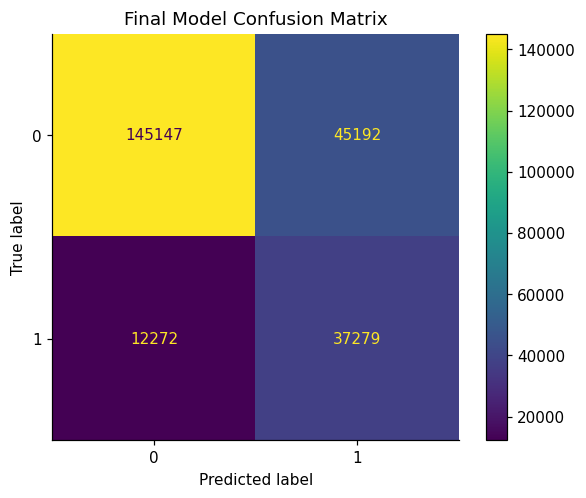

In [57]:
# %% [markdown]
# ## 8. Retrain on Train+Val & Evaluate on Test

best_params = study.best_params
# Include fixed params
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "use_label_encoder": False,
    "random_state": 42,
    "scale_pos_weight": scale_pos_weight,
    "n_jobs": -1,
})

# Combine train+val
X_full = pd.concat([X_train, X_val])
y_full = pd.concat([y_train, y_val])

final_clf = xgb.XGBClassifier(**best_params)
final_clf.fit(X_full, y_full)

# Test evaluation
y_test_pred = final_clf.predict(X_test)
y_test_proba = final_clf.predict_proba(X_test)[:, 1]

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:", recall_score(y_test, y_test_pred))
print("Test F1-Score:", f1_score(y_test, y_test_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba))

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred)
plt.title("Final Model Confusion Matrix")
plt.show()

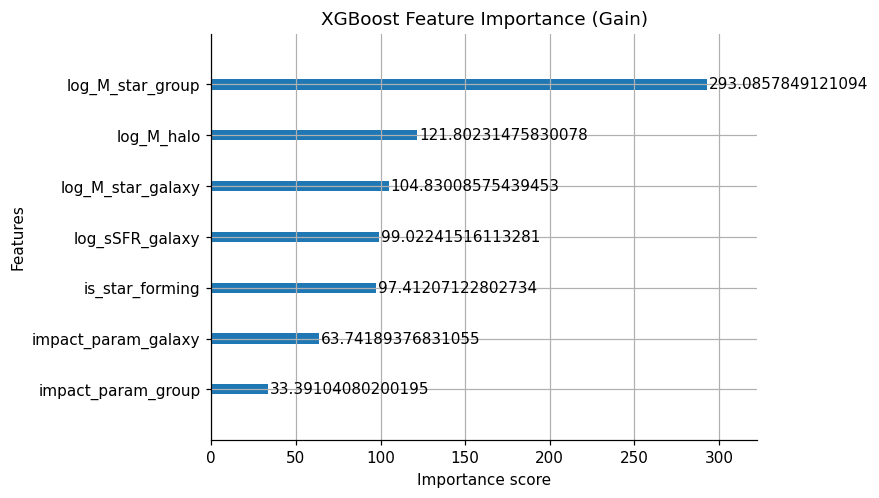

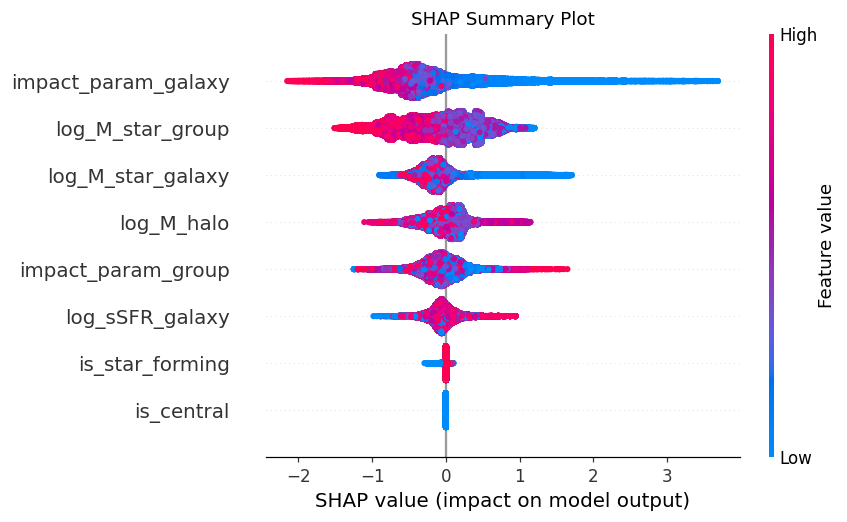

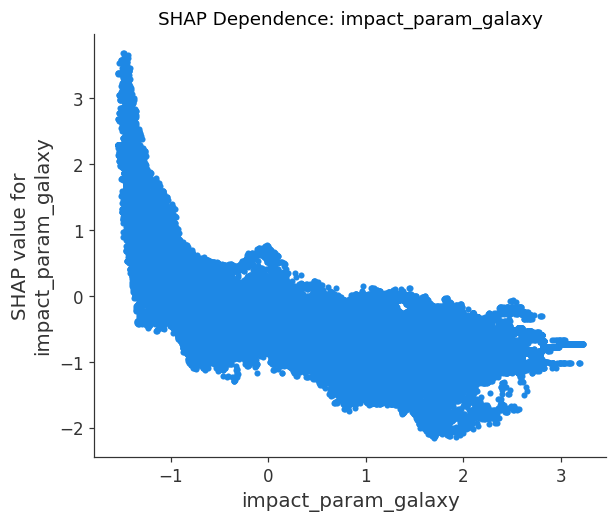

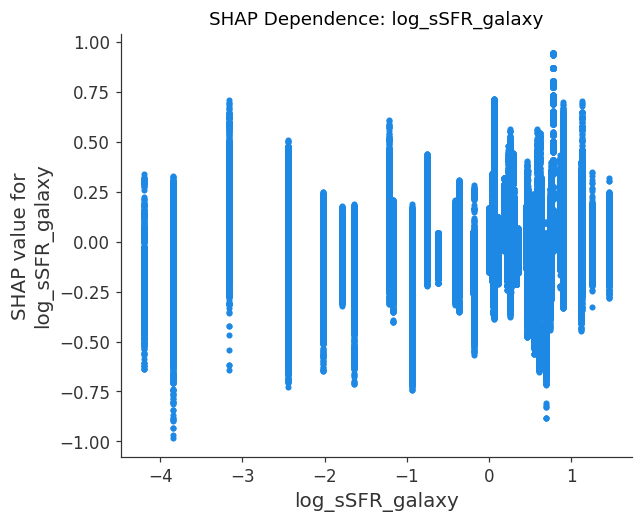

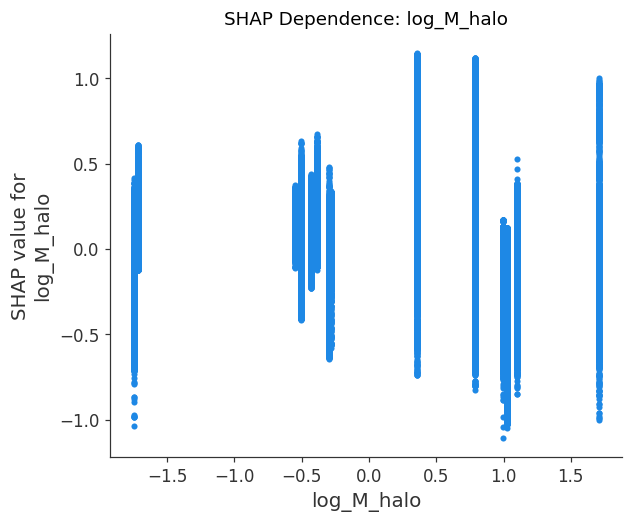

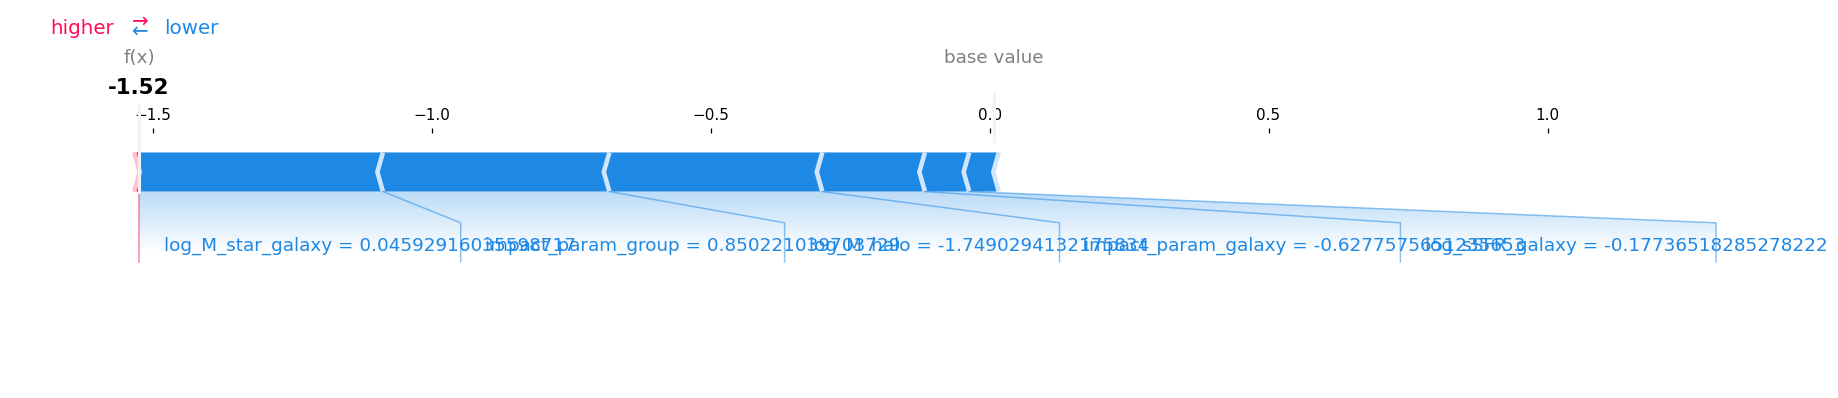

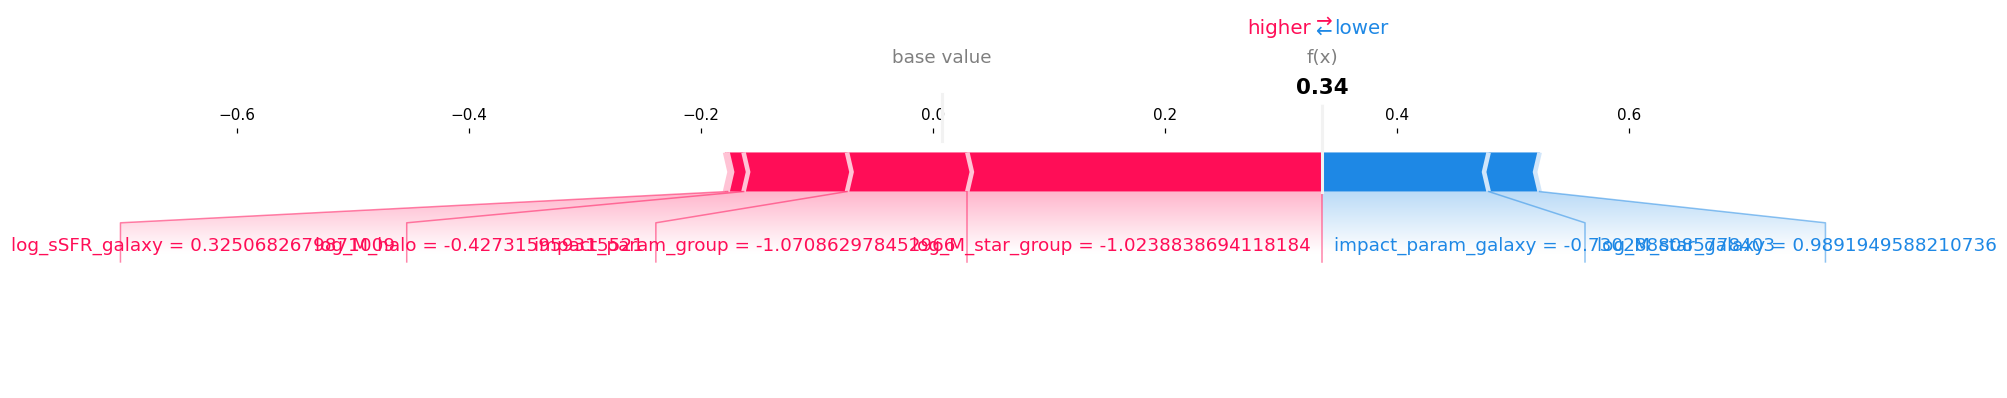

In [59]:
# %% [markdown]
# ## 10. Feature Importance & SHAP

import shap

# 10a. Built-in importance
xgb.plot_importance(final_clf, max_num_features=10, importance_type="gain")
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

# 10b. SHAP analysis
explainer = shap.TreeExplainer(final_clf)
shap_values = explainer.shap_values(X_test)

# Summary beeswarm
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Summary Plot")
plt.show()

# Dependence for top features
for feat in ["impact_param_galaxy", "log_sSFR_galaxy", "log_M_halo"]:
    shap.dependence_plot(feat, shap_values, X_test, interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.show()

# Individual explanation for two examples
for idx in [0, 1]:
    shap.force_plot(
        explainer.expected_value,
        shap_values[idx, :],
        X_test.iloc[idx, :],
        matplotlib=True
    )

### Trial Run - 2 (Gemini 2.5 Pro)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


colsample_bytree,▆██▆█▄█▁▁▆▆▃▂▆▅▆▄▇▅▇▅▅▅▇▇▇▆▇▅▅▅▇▆▅▄▄▃▆▄▆
gamma,▁▇█▆▃▆▂▂▇▁▄▃▆▅▃▅▄▄▄▃▅▆▅▆██▇▆▃▂▂▃▇▅▄▂▃▁▂▄
learning_rate,▅▁▁▄▂▃▁▁▃▇▂▁▂▃█▁▅▃▅▅▆▆▇▆▄█▆▄▆█▅▄▇▆▇▆▄▅▂▂
max_depth,▃▂▂▄▂█▄▄▁▆▆▅▃█▅▇▃▁▃▃▄▄▄▂▄▂▂▄▄▃▃▁▃▄▄▃▄▅▃▂
reg_alpha,▁▁▁▁▁▁▁▁▁█▁▁▁▄▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reg_lambda,▃▁▁▁▂▁▁▁▁▇▁▅▁▁▂▁▃▁▁▁▁▁▁▂▃█▃▂▂▁▁▅▁▁▂▁▂▄▁▁
subsample,▂▄▆▃▃▆▄██▆▃▇▁▅▅▇▂▇▇▇▄▅▅▄▆▆▄▆▅▆▆▇▆▇▃▅▃▆▅▆
test_accuracy,▁
test_f1_score,▁
test_precision,▁
test_recall,▁


Loading and preprocessing real data...
Imputing missing values...
Scaling features...
Data loading and preprocessing complete.
Dataset shape: (1199446, 8)
Target distribution:
has_OVI_absorber
0    0.793444
1    0.206556
Name: proportion, dtype: float64

Performing stratified data splitting...
Train shapes: X-(719667, 8), y-(719667,)
Validation shapes: X-(239889, 8), y-(239889,)
Test shapes: X-(239890, 8), y-(239890,)

Starting hyperparameter optimization with Optuna...
Calculated scale_pos_weight: 3.84


/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_87049/3683983320.py:153: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  wandb_callback = WandbCallback(


[I 2025-07-08 16:34:04,383] A new study created in memory with name: no-name-00a77152-9d37-424b-aeaa-b4ec277082ac
Best trial: 0. Best value: 0.828982:   1%|          | 1/100 [00:08<14:45,  8.94s/it]

[I 2025-07-08 16:34:13,324] Trial 0 finished with value: 0.8289824500233529 and parameters: {'learning_rate': 0.11473632875095627, 'max_depth': 8, 'subsample': 0.9648499580666704, 'colsample_bytree': 0.8781163670488563, 'gamma': 4.152272458284061, 'reg_alpha': 0.27896715386470095, 'reg_lambda': 1.1503391529197118}. Best is trial 0 with value: 0.8289824500233529.


Best trial: 0. Best value: 0.828982:   2%|▏         | 2/100 [00:11<08:38,  5.29s/it]

[I 2025-07-08 16:34:16,054] Trial 1 finished with value: 0.7886984556403742 and parameters: {'learning_rate': 0.005302390374394375, 'max_depth': 7, 'subsample': 0.5400328648013933, 'colsample_bytree': 0.5066818047914192, 'gamma': 9.432278861714517, 'reg_alpha': 0.006680139956280413, 'reg_lambda': 0.00045681614021019076}. Best is trial 0 with value: 0.8289824500233529.


Best trial: 2. Best value: 0.830262:   3%|▎         | 3/100 [00:46<30:33, 18.90s/it]

[I 2025-07-08 16:34:51,145] Trial 2 finished with value: 0.830262155076023 and parameters: {'learning_rate': 0.0034926000319307404, 'max_depth': 10, 'subsample': 0.9504362206701888, 'colsample_bytree': 0.9599532179986712, 'gamma': 9.128981053446887, 'reg_alpha': 0.07059051903957375, 'reg_lambda': 4.189566198294992e-05}. Best is trial 2 with value: 0.830262155076023.


Best trial: 2. Best value: 0.830262:   4%|▍         | 4/100 [00:48<19:37, 12.27s/it]

[I 2025-07-08 16:34:53,259] Trial 3 finished with value: 0.8134579902895545 and parameters: {'learning_rate': 0.023894091871320636, 'max_depth': 10, 'subsample': 0.7230627160135321, 'colsample_bytree': 0.5104765516917918, 'gamma': 0.512936768941934, 'reg_alpha': 0.007195073638166482, 'reg_lambda': 7.7657532212509635}. Best is trial 2 with value: 0.830262155076023.


Best trial: 4. Best value: 0.83342:   5%|▌         | 5/100 [01:15<27:29, 17.37s/it] 

[I 2025-07-08 16:35:19,660] Trial 4 finished with value: 0.8334199742581546 and parameters: {'learning_rate': 0.05059609220933105, 'max_depth': 8, 'subsample': 0.771052880398619, 'colsample_bytree': 0.9750434729301014, 'gamma': 6.849401234903595, 'reg_alpha': 0.11237148719237965, 'reg_lambda': 0.007920221323020997}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   6%|▌         | 6/100 [01:18<19:37, 12.53s/it]

[I 2025-07-08 16:35:22,795] Trial 5 finished with value: 0.7634712223502186 and parameters: {'learning_rate': 0.0011918877230429976, 'max_depth': 5, 'subsample': 0.9414771790490268, 'colsample_bytree': 0.9115826929641722, 'gamma': 9.913775190858601, 'reg_alpha': 0.014259405320493234, 'reg_lambda': 0.00424509041989837}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   7%|▋         | 7/100 [01:45<26:42, 17.23s/it]

[I 2025-07-08 16:35:49,695] Trial 6 finished with value: 0.8034360807907717 and parameters: {'learning_rate': 0.038840388524317405, 'max_depth': 3, 'subsample': 0.7323362040975274, 'colsample_bytree': 0.8803951370403724, 'gamma': 4.1224824927251085, 'reg_alpha': 6.414616188448496e-05, 'reg_lambda': 0.9637915154766341}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   8%|▊         | 8/100 [02:13<31:59, 20.86s/it]

[I 2025-07-08 16:36:18,325] Trial 7 finished with value: 0.8120189113004808 and parameters: {'learning_rate': 0.01426559277630136, 'max_depth': 5, 'subsample': 0.7197477753612511, 'colsample_bytree': 0.8091005864100309, 'gamma': 1.4412945510212538, 'reg_alpha': 0.00017760723251615952, 'reg_lambda': 0.0002938576280467219}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:   9%|▉         | 9/100 [02:30<29:35, 19.51s/it]

[I 2025-07-08 16:36:34,888] Trial 8 finished with value: 0.816976530095549 and parameters: {'learning_rate': 0.14941427816659256, 'max_depth': 5, 'subsample': 0.8169173995761201, 'colsample_bytree': 0.5294110462599233, 'gamma': 6.252527140271421, 'reg_alpha': 0.025794372014591595, 'reg_lambda': 0.12492752197756314}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 4. Best value: 0.83342:  10%|█         | 10/100 [02:55<32:00, 21.34s/it]

[I 2025-07-08 16:37:00,324] Trial 9 finished with value: 0.8030155342518649 and parameters: {'learning_rate': 0.09462082993189977, 'max_depth': 3, 'subsample': 0.7808830345200508, 'colsample_bytree': 0.7288573671511267, 'gamma': 8.138328563449816, 'reg_alpha': 9.880848783866396e-05, 'reg_lambda': 0.0010203342742444276}. Best is trial 4 with value: 0.8334199742581546.


Best trial: 10. Best value: 0.833867:  11%|█         | 11/100 [03:23<34:27, 23.24s/it]

[I 2025-07-08 16:37:27,853] Trial 10 finished with value: 0.8338674446112395 and parameters: {'learning_rate': 0.05138819278146128, 'max_depth': 8, 'subsample': 0.566049818053928, 'colsample_bytree': 0.6676958611994341, 'gamma': 6.479583266543503, 'reg_alpha': 0.6159439244550104, 'reg_lambda': 0.04074181366964767}. Best is trial 10 with value: 0.8338674446112395.


Best trial: 10. Best value: 0.833867:  12%|█▏        | 12/100 [03:52<36:36, 24.95s/it]

[I 2025-07-08 16:37:56,739] Trial 11 finished with value: 0.8337100078420281 and parameters: {'learning_rate': 0.047398333166543447, 'max_depth': 8, 'subsample': 0.5038811757814351, 'colsample_bytree': 0.6654510472695616, 'gamma': 6.5098637308167255, 'reg_alpha': 0.6266532528095632, 'reg_lambda': 0.04024097687363207}. Best is trial 10 with value: 0.8338674446112395.


Best trial: 12. Best value: 0.83502:  13%|█▎        | 13/100 [04:20<37:38, 25.96s/it] 

[I 2025-07-08 16:38:25,014] Trial 12 finished with value: 0.8350196349177812 and parameters: {'learning_rate': 0.051546003415811906, 'max_depth': 8, 'subsample': 0.5015229037581053, 'colsample_bytree': 0.6546858770873, 'gamma': 6.230121172467855, 'reg_alpha': 0.919662833837941, 'reg_lambda': 0.06259452884658043}. Best is trial 12 with value: 0.8350196349177812.


Best trial: 12. Best value: 0.83502:  14%|█▍        | 14/100 [04:52<39:38, 27.66s/it]

[I 2025-07-08 16:38:56,597] Trial 13 finished with value: 0.8315574023699146 and parameters: {'learning_rate': 0.011258580026321423, 'max_depth': 9, 'subsample': 0.579729575404796, 'colsample_bytree': 0.633963935259362, 'gamma': 5.06683126633543, 'reg_alpha': 0.9048626720096056, 'reg_lambda': 0.0755832161855525}. Best is trial 12 with value: 0.8350196349177812.


Best trial: 14. Best value: 0.837893:  15%|█▌        | 15/100 [05:21<40:00, 28.24s/it]

[I 2025-07-08 16:39:26,193] Trial 14 finished with value: 0.837893272574072 and parameters: {'learning_rate': 0.07126734915577991, 'max_depth': 7, 'subsample': 0.635499021849495, 'colsample_bytree': 0.6298394513833468, 'gamma': 2.6442350689162124, 'reg_alpha': 0.0012432284978151492, 'reg_lambda': 0.4342348708566204}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  16%|█▌        | 16/100 [05:51<40:07, 28.65s/it]

[I 2025-07-08 16:39:55,804] Trial 15 finished with value: 0.8346163514861893 and parameters: {'learning_rate': 0.1739908871203379, 'max_depth': 6, 'subsample': 0.6338457561358568, 'colsample_bytree': 0.5863595436006234, 'gamma': 2.3145180092249786, 'reg_alpha': 0.0008030745386479675, 'reg_lambda': 0.696742579955494}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  17%|█▋        | 17/100 [06:21<40:19, 29.15s/it]

[I 2025-07-08 16:40:26,122] Trial 16 finished with value: 0.8282419954849373 and parameters: {'learning_rate': 0.022004437521872693, 'max_depth': 7, 'subsample': 0.6256431818475726, 'colsample_bytree': 0.7406373518922659, 'gamma': 2.9453554577121057, 'reg_alpha': 0.0012233817262428928, 'reg_lambda': 8.220134394731259}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  18%|█▊        | 18/100 [06:49<39:28, 28.88s/it]

[I 2025-07-08 16:40:54,360] Trial 17 finished with value: 0.8297479984050339 and parameters: {'learning_rate': 0.07959485572041446, 'max_depth': 6, 'subsample': 0.6580092052554938, 'colsample_bytree': 0.5888425024756436, 'gamma': 3.2688893590835146, 'reg_alpha': 0.0004625694877781693, 'reg_lambda': 0.37703611550203114}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  19%|█▉        | 19/100 [07:17<38:23, 28.44s/it]

[I 2025-07-08 16:41:21,788] Trial 18 finished with value: 0.8325639465967645 and parameters: {'learning_rate': 0.024525251833217982, 'max_depth': 9, 'subsample': 0.8706512753625177, 'colsample_bytree': 0.8141389563384116, 'gamma': 5.292902568038693, 'reg_alpha': 1.2450481112082923e-05, 'reg_lambda': 0.02101444534063989}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  20%|██        | 20/100 [07:51<40:04, 30.06s/it]

[I 2025-07-08 16:41:55,604] Trial 19 finished with value: 0.8272203620828437 and parameters: {'learning_rate': 0.007737523492113905, 'max_depth': 9, 'subsample': 0.5072826859650348, 'colsample_bytree': 0.7135946290287066, 'gamma': 7.864278906317663, 'reg_alpha': 0.001667534729846379, 'reg_lambda': 0.19313498709772395}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  21%|██        | 21/100 [08:22<39:52, 30.29s/it]

[I 2025-07-08 16:42:26,426] Trial 20 finished with value: 0.8345193597409019 and parameters: {'learning_rate': 0.07257327742993466, 'max_depth': 7, 'subsample': 0.6708793556759091, 'colsample_bytree': 0.5971022328756361, 'gamma': 0.30091235110192516, 'reg_alpha': 0.04438346531059912, 'reg_lambda': 0.0031237124542587823}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  22%|██▏       | 22/100 [08:51<38:57, 29.97s/it]

[I 2025-07-08 16:42:55,647] Trial 21 finished with value: 0.8347141526641173 and parameters: {'learning_rate': 0.1750662442252876, 'max_depth': 6, 'subsample': 0.6125823347573534, 'colsample_bytree': 0.5751619728709584, 'gamma': 2.0583160023597786, 'reg_alpha': 0.0007481943978873, 'reg_lambda': 1.411122452603118}. Best is trial 14 with value: 0.837893272574072.


Best trial: 14. Best value: 0.837893:  23%|██▎       | 23/100 [09:20<38:08, 29.73s/it]

[I 2025-07-08 16:43:24,811] Trial 22 finished with value: 0.8340911574154625 and parameters: {'learning_rate': 0.16545150988802892, 'max_depth': 6, 'subsample': 0.5938599289696872, 'colsample_bytree': 0.5644226843398463, 'gamma': 1.60705115919845, 'reg_alpha': 0.003639729324678919, 'reg_lambda': 5.920704429524327}. Best is trial 14 with value: 0.837893272574072.


Best trial: 23. Best value: 0.838116:  24%|██▍       | 24/100 [09:49<37:22, 29.50s/it]

[I 2025-07-08 16:43:53,800] Trial 23 finished with value: 0.8381159565166719 and parameters: {'learning_rate': 0.10378819329878934, 'max_depth': 7, 'subsample': 0.5408908726202966, 'colsample_bytree': 0.6440485344323326, 'gamma': 4.012343701093652, 'reg_alpha': 0.00034409672931979494, 'reg_lambda': 2.1520788968643028}. Best is trial 23 with value: 0.8381159565166719.


Best trial: 23. Best value: 0.838116:  25%|██▌       | 25/100 [10:20<37:21, 29.88s/it]

[I 2025-07-08 16:44:24,565] Trial 24 finished with value: 0.8316543313984865 and parameters: {'learning_rate': 0.03298347348505692, 'max_depth': 7, 'subsample': 0.5440529657317713, 'colsample_bytree': 0.6816842236055145, 'gamma': 3.9397398947516615, 'reg_alpha': 0.000252806858352766, 'reg_lambda': 2.3721138129898196}. Best is trial 23 with value: 0.8381159565166719.


Best trial: 23. Best value: 0.838116:  26%|██▌       | 26/100 [10:47<35:49, 29.04s/it]

[I 2025-07-08 16:44:51,651] Trial 25 finished with value: 0.8157229554349387 and parameters: {'learning_rate': 0.06556956606929454, 'max_depth': 4, 'subsample': 0.6841512420754812, 'colsample_bytree': 0.6330310927747066, 'gamma': 5.133119508981098, 'reg_alpha': 2.1287948164362198e-05, 'reg_lambda': 0.28296637030452626}. Best is trial 23 with value: 0.8381159565166719.


Best trial: 26. Best value: 0.842023:  27%|██▋       | 27/100 [11:17<35:55, 29.53s/it]

[I 2025-07-08 16:45:22,311] Trial 26 finished with value: 0.8420231462427261 and parameters: {'learning_rate': 0.10815596947839096, 'max_depth': 8, 'subsample': 0.5300427787615918, 'colsample_bytree': 0.6307595549898977, 'gamma': 3.1433500674311725, 'reg_alpha': 4.191559151010247e-05, 'reg_lambda': 2.70095959227169}. Best is trial 26 with value: 0.8420231462427261.


Best trial: 27. Best value: 0.846036:  28%|██▊       | 28/100 [11:49<36:13, 30.19s/it]

[I 2025-07-08 16:45:54,032] Trial 27 finished with value: 0.8460358825285486 and parameters: {'learning_rate': 0.10195991874640395, 'max_depth': 9, 'subsample': 0.5489058595011069, 'colsample_bytree': 0.7881865857399235, 'gamma': 3.171617183619434, 'reg_alpha': 3.951958209560971e-05, 'reg_lambda': 2.9848307811134176}. Best is trial 27 with value: 0.8460358825285486.


Best trial: 27. Best value: 0.846036:  29%|██▉       | 29/100 [12:22<36:39, 30.98s/it]

[I 2025-07-08 16:46:26,871] Trial 28 finished with value: 0.8460173437218863 and parameters: {'learning_rate': 0.12132573433239772, 'max_depth': 9, 'subsample': 0.563384507755125, 'colsample_bytree': 0.7925307511702616, 'gamma': 3.585352736647938, 'reg_alpha': 3.635590138005189e-05, 'reg_lambda': 2.3743616027367476}. Best is trial 27 with value: 0.8460358825285486.


Best trial: 29. Best value: 0.846502:  30%|███       | 30/100 [12:53<36:14, 31.07s/it]

[I 2025-07-08 16:46:58,140] Trial 29 finished with value: 0.8465021736219337 and parameters: {'learning_rate': 0.1225963185466397, 'max_depth': 9, 'subsample': 0.574310071783506, 'colsample_bytree': 0.7889100122010083, 'gamma': 3.4849461990969925, 'reg_alpha': 3.5614310528935446e-05, 'reg_lambda': 2.7084161763997363}. Best is trial 29 with value: 0.8465021736219337.


Best trial: 30. Best value: 0.846689:  31%|███       | 31/100 [13:21<34:39, 30.14s/it]

[I 2025-07-08 16:47:26,110] Trial 30 finished with value: 0.8466887020936871 and parameters: {'learning_rate': 0.11816857074462246, 'max_depth': 10, 'subsample': 0.5742264370819028, 'colsample_bytree': 0.7885990682659241, 'gamma': 3.6126304116752506, 'reg_alpha': 2.511308820242547e-05, 'reg_lambda': 1.1362604171516784e-05}. Best is trial 30 with value: 0.8466887020936871.


Best trial: 31. Best value: 0.84674:  32%|███▏      | 32/100 [13:47<32:33, 28.72s/it] 

[I 2025-07-08 16:47:51,526] Trial 31 finished with value: 0.8467402682756019 and parameters: {'learning_rate': 0.12733202454594672, 'max_depth': 10, 'subsample': 0.5854456359174731, 'colsample_bytree': 0.7919452611785345, 'gamma': 3.6718253721109058, 'reg_alpha': 2.8618069807324515e-05, 'reg_lambda': 4.130272403671992e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  33%|███▎      | 33/100 [14:16<32:17, 28.91s/it]

[I 2025-07-08 16:48:20,887] Trial 32 finished with value: 0.8464424398469164 and parameters: {'learning_rate': 0.12253547470449229, 'max_depth': 10, 'subsample': 0.5969263874757501, 'colsample_bytree': 0.7760608411711677, 'gamma': 4.592098222008366, 'reg_alpha': 1.3053781184139118e-05, 'reg_lambda': 1.2644663080541229e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  34%|███▍      | 34/100 [14:49<33:08, 30.13s/it]

[I 2025-07-08 16:48:53,852] Trial 33 finished with value: 0.846265234323619 and parameters: {'learning_rate': 0.13329210790380241, 'max_depth': 10, 'subsample': 0.5952642414188561, 'colsample_bytree': 0.8415750421475207, 'gamma': 4.700834782016286, 'reg_alpha': 1.526594020812662e-05, 'reg_lambda': 1.085601251516478e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  35%|███▌      | 35/100 [14:52<23:48, 21.97s/it]

[I 2025-07-08 16:48:56,798] Trial 34 finished with value: 0.8195156974929256 and parameters: {'learning_rate': 0.0022650043887228067, 'max_depth': 10, 'subsample': 0.5955406188982775, 'colsample_bytree': 0.7610925332526425, 'gamma': 4.6189288140451445, 'reg_alpha': 1.1152664254739537e-05, 'reg_lambda': 7.591149844789107e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  36%|███▌      | 36/100 [15:16<24:04, 22.58s/it]

[I 2025-07-08 16:49:20,780] Trial 35 finished with value: 0.843320388437118 and parameters: {'learning_rate': 0.12892825889774925, 'max_depth': 10, 'subsample': 0.6956497794455172, 'colsample_bytree': 0.8528820072038731, 'gamma': 5.529251011139806, 'reg_alpha': 0.00011140293107502023, 'reg_lambda': 1.7079422655288135e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  37%|███▋      | 37/100 [15:29<20:48, 19.82s/it]

[I 2025-07-08 16:49:34,162] Trial 36 finished with value: 0.8370918843727062 and parameters: {'learning_rate': 0.030909449284355666, 'max_depth': 10, 'subsample': 0.9964077302637948, 'colsample_bytree': 0.7621007949084965, 'gamma': 1.1647552707975866, 'reg_alpha': 2.194019729657034e-05, 'reg_lambda': 5.1247493157590596e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  38%|███▊      | 38/100 [15:49<20:29, 19.82s/it]

[I 2025-07-08 16:49:53,995] Trial 37 finished with value: 0.8437472259980519 and parameters: {'learning_rate': 0.18070975643165196, 'max_depth': 10, 'subsample': 0.6550200827982553, 'colsample_bytree': 0.7030336794314628, 'gamma': 4.498158947462161, 'reg_alpha': 7.644334798683195e-05, 'reg_lambda': 0.0002502208761061029}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  39%|███▉      | 39/100 [16:17<22:37, 22.25s/it]

[I 2025-07-08 16:50:21,914] Trial 38 finished with value: 0.8433613837510766 and parameters: {'learning_rate': 0.07835435783843755, 'max_depth': 9, 'subsample': 0.6111582459707151, 'colsample_bytree': 0.926774792085786, 'gamma': 5.843906418105297, 'reg_alpha': 0.00016239710438471663, 'reg_lambda': 2.3266440514732738e-05}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 31. Best value: 0.84674:  40%|████      | 40/100 [16:20<16:24, 16.40s/it]

[I 2025-07-08 16:50:24,678] Trial 39 finished with value: 0.8193141553392529 and parameters: {'learning_rate': 0.0026418883132391475, 'max_depth': 10, 'subsample': 0.7047371035353909, 'colsample_bytree': 0.8312345225397328, 'gamma': 3.758526328815042, 'reg_alpha': 2.477999398240692e-05, 'reg_lambda': 0.0001002273224522218}. Best is trial 31 with value: 0.8467402682756019.


Best trial: 40. Best value: 0.848422:  41%|████      | 41/100 [16:52<20:42, 21.05s/it]

[I 2025-07-08 16:50:56,569] Trial 40 finished with value: 0.8484217773769823 and parameters: {'learning_rate': 0.05946784540626768, 'max_depth': 10, 'subsample': 0.767121569923539, 'colsample_bytree': 0.8760152516200531, 'gamma': 2.4916547510184452, 'reg_alpha': 5.1463365884032976e-05, 'reg_lambda': 0.00014403477455965545}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 40. Best value: 0.848422:  42%|████▏     | 42/100 [17:19<22:04, 22.83s/it]

[I 2025-07-08 16:51:23,567] Trial 41 finished with value: 0.8470995847978477 and parameters: {'learning_rate': 0.09077462203840976, 'max_depth': 10, 'subsample': 0.8648495516543047, 'colsample_bytree': 0.898302723927318, 'gamma': 2.5111373337845553, 'reg_alpha': 5.379571391254727e-05, 'reg_lambda': 0.0001542805367522482}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 40. Best value: 0.848422:  43%|████▎     | 43/100 [17:41<21:34, 22.70s/it]

[I 2025-07-08 16:51:45,966] Trial 42 finished with value: 0.8466509869222713 and parameters: {'learning_rate': 0.19511511040907228, 'max_depth': 9, 'subsample': 0.8535503498197807, 'colsample_bytree': 0.8858403849561697, 'gamma': 2.0671318010883493, 'reg_alpha': 6.226254733222235e-05, 'reg_lambda': 0.00016479222139116487}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 40. Best value: 0.848422:  44%|████▍     | 44/100 [17:50<17:23, 18.63s/it]

[I 2025-07-08 16:51:55,092] Trial 43 finished with value: 0.8467135478798837 and parameters: {'learning_rate': 0.19939535473946643, 'max_depth': 10, 'subsample': 0.8709218180298159, 'colsample_bytree': 0.8962964664950124, 'gamma': 1.0336447187743578, 'reg_alpha': 7.512060551644776e-05, 'reg_lambda': 0.0006284493017285271}. Best is trial 40 with value: 0.8484217773769823.


Best trial: 44. Best value: 0.848696:  45%|████▌     | 45/100 [18:15<18:38, 20.34s/it]

[I 2025-07-08 16:52:19,405] Trial 44 finished with value: 0.8486956238984914 and parameters: {'learning_rate': 0.05626587942708749, 'max_depth': 10, 'subsample': 0.9026415617139856, 'colsample_bytree': 0.9485973474243419, 'gamma': 0.8283848653965158, 'reg_alpha': 0.00014122741259131187, 'reg_lambda': 0.000768386491154334}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  46%|████▌     | 46/100 [18:40<19:44, 21.94s/it]

[I 2025-07-08 16:52:45,089] Trial 45 finished with value: 0.8485046671918931 and parameters: {'learning_rate': 0.06173110155892124, 'max_depth': 10, 'subsample': 0.9146514983614159, 'colsample_bytree': 0.994082175396337, 'gamma': 0.7462264685765971, 'reg_alpha': 0.00012641362602409215, 'reg_lambda': 0.0007975449821047867}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  47%|████▋     | 47/100 [19:13<22:08, 25.06s/it]

[I 2025-07-08 16:53:17,426] Trial 46 finished with value: 0.8474828309014896 and parameters: {'learning_rate': 0.055662469133510466, 'max_depth': 9, 'subsample': 0.9336042327726364, 'colsample_bytree': 0.983762366594352, 'gamma': 0.21445289458409889, 'reg_alpha': 0.00016747262822642417, 'reg_lambda': 0.0017810660759545482}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  48%|████▊     | 48/100 [19:45<23:45, 27.42s/it]

[I 2025-07-08 16:53:50,352] Trial 47 finished with value: 0.8472279517597019 and parameters: {'learning_rate': 0.0446077388767117, 'max_depth': 9, 'subsample': 0.9318688223484002, 'colsample_bytree': 0.9828162708952977, 'gamma': 0.02632533233124762, 'reg_alpha': 0.00016686688067386128, 'reg_lambda': 0.0019302799780732606}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  49%|████▉     | 49/100 [20:17<24:14, 28.53s/it]

[I 2025-07-08 16:54:21,466] Trial 48 finished with value: 0.844898318364458 and parameters: {'learning_rate': 0.043460264103482193, 'max_depth': 8, 'subsample': 0.911910953171798, 'colsample_bytree': 0.9964530492803462, 'gamma': 0.14660731805433758, 'reg_alpha': 0.00018429914643920824, 'reg_lambda': 0.0018208580455254535}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  50%|█████     | 50/100 [20:51<25:07, 30.15s/it]

[I 2025-07-08 16:54:55,412] Trial 49 finished with value: 0.8431192002644344 and parameters: {'learning_rate': 0.01714709791548821, 'max_depth': 9, 'subsample': 0.9303064007295964, 'colsample_bytree': 0.9526981906931796, 'gamma': 0.7505458293234777, 'reg_alpha': 0.00041998126258576676, 'reg_lambda': 0.009901037069238481}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  51%|█████     | 51/100 [21:17<23:36, 28.90s/it]

[I 2025-07-08 16:55:21,397] Trial 50 finished with value: 0.8472211590039501 and parameters: {'learning_rate': 0.05843693363662667, 'max_depth': 9, 'subsample': 0.9020258645250402, 'colsample_bytree': 0.9462523565961659, 'gamma': 0.0020325021788275277, 'reg_alpha': 0.00012537150429463994, 'reg_lambda': 0.0011657167396466866}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  52%|█████▏    | 52/100 [21:43<22:34, 28.21s/it]

[I 2025-07-08 16:55:47,988] Trial 51 finished with value: 0.8470663044881487 and parameters: {'learning_rate': 0.0586666264946085, 'max_depth': 9, 'subsample': 0.905366960400027, 'colsample_bytree': 0.9470816779432807, 'gamma': 0.037444347986511216, 'reg_alpha': 0.00012527590271960108, 'reg_lambda': 0.0009393185869562882}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  53%|█████▎    | 53/100 [22:14<22:45, 29.05s/it]

[I 2025-07-08 16:56:18,999] Trial 52 finished with value: 0.8432237400698247 and parameters: {'learning_rate': 0.03734222982927161, 'max_depth': 8, 'subsample': 0.9650252762819673, 'colsample_bytree': 0.9828896224463315, 'gamma': 0.6702711271204624, 'reg_alpha': 0.0002145636078296648, 'reg_lambda': 0.0037656720586105303}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  54%|█████▍    | 54/100 [22:46<22:52, 29.83s/it]

[I 2025-07-08 16:56:50,633] Trial 53 finished with value: 0.8473994953896826 and parameters: {'learning_rate': 0.059279103731620944, 'max_depth': 9, 'subsample': 0.8206077660502148, 'colsample_bytree': 0.9266279832651583, 'gamma': 1.7549367407736105, 'reg_alpha': 0.0003413845727353681, 'reg_lambda': 0.0015406595935057545}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  55%|█████▌    | 55/100 [23:20<23:28, 31.30s/it]

[I 2025-07-08 16:57:25,364] Trial 54 finished with value: 0.8451601877427797 and parameters: {'learning_rate': 0.02527592605582008, 'max_depth': 9, 'subsample': 0.7965939216323483, 'colsample_bytree': 0.921654090742524, 'gamma': 1.5475057644074017, 'reg_alpha': 0.0006475710236762833, 'reg_lambda': 0.000334251163087152}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  56%|█████▌    | 56/100 [23:49<22:19, 30.43s/it]

[I 2025-07-08 16:57:53,787] Trial 55 finished with value: 0.8476901402892345 and parameters: {'learning_rate': 0.043816799369514034, 'max_depth': 10, 'subsample': 0.751242917578522, 'colsample_bytree': 0.9755133584025005, 'gamma': 1.0573595606644142, 'reg_alpha': 0.0002746969466885799, 'reg_lambda': 0.002210742101870349}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  57%|█████▋    | 57/100 [24:22<22:20, 31.17s/it]

[I 2025-07-08 16:58:26,667] Trial 56 finished with value: 0.8478487992126681 and parameters: {'learning_rate': 0.02995497240570651, 'max_depth': 10, 'subsample': 0.7656553264862856, 'colsample_bytree': 0.9685510918350777, 'gamma': 1.832990270268735, 'reg_alpha': 0.003147747904007185, 'reg_lambda': 0.016432784396624885}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  58%|█████▊    | 58/100 [24:56<22:29, 32.12s/it]

[I 2025-07-08 16:59:01,019] Trial 57 finished with value: 0.8479571566794344 and parameters: {'learning_rate': 0.033834001065700774, 'max_depth': 10, 'subsample': 0.7407838707179959, 'colsample_bytree': 0.9975960831443166, 'gamma': 1.0505136081227386, 'reg_alpha': 0.1379537695565795, 'reg_lambda': 0.006141902470407109}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  59%|█████▉    | 59/100 [25:33<22:59, 33.64s/it]

[I 2025-07-08 16:59:38,204] Trial 58 finished with value: 0.8464723495705249 and parameters: {'learning_rate': 0.01875646952137989, 'max_depth': 10, 'subsample': 0.7567665667760123, 'colsample_bytree': 0.964337275002057, 'gamma': 1.1642377629495106, 'reg_alpha': 0.14565591792926655, 'reg_lambda': 0.005511963971624537}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  60%|██████    | 60/100 [26:08<22:38, 33.96s/it]

[I 2025-07-08 17:00:12,907] Trial 59 finished with value: 0.8476287296505529 and parameters: {'learning_rate': 0.034638902507778645, 'max_depth': 10, 'subsample': 0.7306973314656828, 'colsample_bytree': 0.9665153852208983, 'gamma': 0.8307546742744184, 'reg_alpha': 0.012051090454236333, 'reg_lambda': 0.0005720216066496562}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  61%|██████    | 61/100 [26:36<20:55, 32.20s/it]

[I 2025-07-08 17:00:41,019] Trial 60 finished with value: 0.8125153798430989 and parameters: {'learning_rate': 0.028140088081259212, 'max_depth': 4, 'subsample': 0.7521261018815613, 'colsample_bytree': 0.9979315700120018, 'gamma': 1.9374784832770893, 'reg_alpha': 0.0033389029345292447, 'reg_lambda': 0.01447231287351334}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  62%|██████▏   | 62/100 [27:12<21:03, 33.26s/it]

[I 2025-07-08 17:01:16,724] Trial 61 finished with value: 0.8474689999306513 and parameters: {'learning_rate': 0.03660044230582986, 'max_depth': 10, 'subsample': 0.7173574676900708, 'colsample_bytree': 0.9662445490432542, 'gamma': 0.6921799418320418, 'reg_alpha': 0.01830886380394623, 'reg_lambda': 0.0005802747186549922}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  63%|██████▎   | 63/100 [27:49<21:09, 34.31s/it]

[I 2025-07-08 17:01:53,501] Trial 62 finished with value: 0.8440764751301529 and parameters: {'learning_rate': 0.011640006025757387, 'max_depth': 10, 'subsample': 0.734668754421513, 'colsample_bytree': 0.9386098593910286, 'gamma': 1.3051764442349822, 'reg_alpha': 0.0085800536042199, 'reg_lambda': 0.021278570159073203}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  64%|██████▍   | 64/100 [28:18<19:37, 32.71s/it]

[I 2025-07-08 17:02:22,481] Trial 63 finished with value: 0.8479681477440837 and parameters: {'learning_rate': 0.043966532462812194, 'max_depth': 10, 'subsample': 0.7754286440047747, 'colsample_bytree': 0.971958929254989, 'gamma': 0.9193058226676261, 'reg_alpha': 0.04057081451155126, 'reg_lambda': 0.0006843957603635423}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  65%|██████▌   | 65/100 [28:44<18:02, 30.94s/it]

[I 2025-07-08 17:02:49,271] Trial 64 finished with value: 0.8479493045784491 and parameters: {'learning_rate': 0.044988488882288, 'max_depth': 10, 'subsample': 0.7793704138008204, 'colsample_bytree': 0.9122059537413174, 'gamma': 0.45228610916001305, 'reg_alpha': 0.2620742363192296, 'reg_lambda': 0.0070832061526445575}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  66%|██████▌   | 66/100 [29:02<15:17, 26.98s/it]

[I 2025-07-08 17:03:07,011] Trial 65 finished with value: 0.8463919816779821 and parameters: {'learning_rate': 0.08283900021459169, 'max_depth': 10, 'subsample': 0.7813320763022903, 'colsample_bytree': 0.8720206731988316, 'gamma': 0.384539192095386, 'reg_alpha': 0.10214195443214369, 'reg_lambda': 0.0065061674028360095}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  67%|██████▋   | 67/100 [29:33<15:25, 28.05s/it]

[I 2025-07-08 17:03:37,562] Trial 66 finished with value: 0.8467155947880745 and parameters: {'learning_rate': 0.04846667111332016, 'max_depth': 10, 'subsample': 0.8180938091720574, 'colsample_bytree': 0.9092111946680529, 'gamma': 2.786060667693186, 'reg_alpha': 0.3365322393193097, 'reg_lambda': 0.042418645718884034}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  68%|██████▊   | 68/100 [30:05<15:41, 29.43s/it]

[I 2025-07-08 17:04:10,215] Trial 67 finished with value: 0.8471746886744622 and parameters: {'learning_rate': 0.027486296640312408, 'max_depth': 10, 'subsample': 0.7996007596947559, 'colsample_bytree': 0.9995481238500361, 'gamma': 2.292764361102492, 'reg_alpha': 0.271414777355188, 'reg_lambda': 0.016865175545403156}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  69%|██████▉   | 69/100 [30:39<15:54, 30.80s/it]

[I 2025-07-08 17:04:44,217] Trial 68 finished with value: 0.8468616324893877 and parameters: {'learning_rate': 0.02144447921464427, 'max_depth': 10, 'subsample': 0.8409764507981866, 'colsample_bytree': 0.9372212578770409, 'gamma': 1.5085556845520198, 'reg_alpha': 0.03677557902020989, 'reg_lambda': 0.08818643227955011}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  70%|███████   | 70/100 [31:08<15:04, 30.14s/it]

[I 2025-07-08 17:05:12,809] Trial 69 finished with value: 0.8484508228504658 and parameters: {'learning_rate': 0.06775872602136096, 'max_depth': 10, 'subsample': 0.7685596420183263, 'colsample_bytree': 0.913243574334941, 'gamma': 1.81471419575439, 'reg_alpha': 0.062061786792989716, 'reg_lambda': 0.0027083516637549598}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  71%|███████   | 71/100 [31:29<13:16, 27.47s/it]

[I 2025-07-08 17:05:34,060] Trial 70 finished with value: 0.8474065270839273 and parameters: {'learning_rate': 0.06457861628634604, 'max_depth': 10, 'subsample': 0.7825706241421398, 'colsample_bytree': 0.9117062767540819, 'gamma': 0.4894653827296622, 'reg_alpha': 0.056206630221756156, 'reg_lambda': 0.003225270317139822}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  72%|███████▏  | 72/100 [31:59<13:04, 28.03s/it]

[I 2025-07-08 17:06:03,391] Trial 71 finished with value: 0.8478662399201501 and parameters: {'learning_rate': 0.0702318009789407, 'max_depth': 10, 'subsample': 0.762481435523196, 'colsample_bytree': 0.8704411638542482, 'gamma': 1.7691725990836276, 'reg_alpha': 0.22581296437908052, 'reg_lambda': 0.005194412842842879}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 44. Best value: 0.848696:  73%|███████▎  | 73/100 [32:24<12:15, 27.25s/it]

[I 2025-07-08 17:06:28,831] Trial 72 finished with value: 0.8485364949973029 and parameters: {'learning_rate': 0.08999060263258446, 'max_depth': 10, 'subsample': 0.7364786280321539, 'colsample_bytree': 0.8764808966386708, 'gamma': 2.263816222003207, 'reg_alpha': 0.19828512302279766, 'reg_lambda': 0.004939032878379142}. Best is trial 44 with value: 0.8486956238984914.


Best trial: 73. Best value: 0.848872:  74%|███████▍  | 74/100 [32:48<11:24, 26.34s/it]

[I 2025-07-08 17:06:53,033] Trial 73 finished with value: 0.848872433399924 and parameters: {'learning_rate': 0.08725916211787774, 'max_depth': 10, 'subsample': 0.7353869522115165, 'colsample_bytree': 0.952726167198137, 'gamma': 2.1956139583625154, 'reg_alpha': 0.45107323952030576, 'reg_lambda': 0.0008579915423895842}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  75%|███████▌  | 75/100 [33:21<11:50, 28.41s/it]

[I 2025-07-08 17:07:26,265] Trial 74 finished with value: 0.8479985406461759 and parameters: {'learning_rate': 0.08931790214315552, 'max_depth': 10, 'subsample': 0.7352629570696626, 'colsample_bytree': 0.8575107896244804, 'gamma': 2.2573084962733043, 'reg_alpha': 0.47920287314358034, 'reg_lambda': 0.00040705703794252207}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  76%|███████▌  | 76/100 [33:54<11:52, 29.70s/it]

[I 2025-07-08 17:07:58,985] Trial 75 finished with value: 0.8468227835397132 and parameters: {'learning_rate': 0.0922412374356939, 'max_depth': 9, 'subsample': 0.7162763869712536, 'colsample_bytree': 0.8171753465770265, 'gamma': 2.345846879398723, 'reg_alpha': 0.45537565718291606, 'reg_lambda': 0.0003320951978976093}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  77%|███████▋  | 77/100 [34:18<10:40, 27.86s/it]

[I 2025-07-08 17:08:22,563] Trial 76 finished with value: 0.8476086118988857 and parameters: {'learning_rate': 0.14611647853966592, 'max_depth': 10, 'subsample': 0.7987014254686491, 'colsample_bytree': 0.861430567644698, 'gamma': 2.8078451337929633, 'reg_alpha': 0.725261438358098, 'reg_lambda': 0.0008356735541538671}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  78%|███████▊  | 78/100 [34:48<10:30, 28.67s/it]

[I 2025-07-08 17:08:53,107] Trial 77 finished with value: 0.8477959755155426 and parameters: {'learning_rate': 0.08806418298700419, 'max_depth': 9, 'subsample': 0.680452447129759, 'colsample_bytree': 0.8966372377969154, 'gamma': 2.2826624695784643, 'reg_alpha': 0.4512195020664882, 'reg_lambda': 0.0002457679737696271}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  79%|███████▉  | 79/100 [34:53<07:29, 21.39s/it]

[I 2025-07-08 17:08:57,501] Trial 78 finished with value: 0.8350819442133066 and parameters: {'learning_rate': 0.07458592629506419, 'max_depth': 10, 'subsample': 0.8815084956692584, 'colsample_bytree': 0.8851452204614391, 'gamma': 8.02307611433315, 'reg_alpha': 0.07088039055182938, 'reg_lambda': 0.00015121594317867764}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  80%|████████  | 80/100 [35:22<07:56, 23.80s/it]

[I 2025-07-08 17:09:26,936] Trial 79 finished with value: 0.829204217920197 and parameters: {'learning_rate': 0.0668447902136934, 'max_depth': 5, 'subsample': 0.8346299564083055, 'colsample_bytree': 0.9511838051927048, 'gamma': 3.0449994706111223, 'reg_alpha': 0.0938666142719216, 'reg_lambda': 0.0004171913030383768}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  81%|████████  | 81/100 [35:42<07:07, 22.51s/it]

[I 2025-07-08 17:09:46,429] Trial 80 finished with value: 0.8464258759010935 and parameters: {'learning_rate': 0.10176895644842694, 'max_depth': 10, 'subsample': 0.7028639795093485, 'colsample_bytree': 0.8466771750855108, 'gamma': 1.394862561149944, 'reg_alpha': 0.2059115519977718, 'reg_lambda': 0.0011753788617632221}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  82%|████████▏ | 82/100 [36:00<06:25, 21.39s/it]

[I 2025-07-08 17:10:05,215] Trial 81 finished with value: 0.8474638077500143 and parameters: {'learning_rate': 0.0803676218239829, 'max_depth': 10, 'subsample': 0.742519062444583, 'colsample_bytree': 0.9308216274113386, 'gamma': 0.9243012281250147, 'reg_alpha': 0.16422582440335956, 'reg_lambda': 0.0006943889748763886}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  83%|████████▎ | 83/100 [36:34<07:04, 24.95s/it]

[I 2025-07-08 17:10:38,461] Trial 82 finished with value: 0.8487002442596061 and parameters: {'learning_rate': 0.040767256678267576, 'max_depth': 10, 'subsample': 0.7402523440480314, 'colsample_bytree': 0.9819973521929044, 'gamma': 2.1308381573898316, 'reg_alpha': 0.4180298240983202, 'reg_lambda': 0.002553519147601707}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  84%|████████▍ | 84/100 [36:37<04:53, 18.37s/it]

[I 2025-07-08 17:10:41,490] Trial 83 finished with value: 0.8193589980559886 and parameters: {'learning_rate': 0.0010613741363897362, 'max_depth': 10, 'subsample': 0.7197154933066288, 'colsample_bytree': 0.8328490082450538, 'gamma': 2.632166937711916, 'reg_alpha': 0.3732685496361442, 'reg_lambda': 0.0024921711537642336}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  85%|████████▌ | 85/100 [36:43<03:42, 14.80s/it]

[I 2025-07-08 17:10:47,962] Trial 84 finished with value: 0.8290590516790455 and parameters: {'learning_rate': 0.05286965779648818, 'max_depth': 9, 'subsample': 0.956374816475845, 'colsample_bytree': 0.9529979802276557, 'gamma': 9.039240730714273, 'reg_alpha': 0.5960175427421855, 'reg_lambda': 0.00019741414732807317}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  86%|████████▌ | 86/100 [37:00<03:36, 15.44s/it]

[I 2025-07-08 17:11:04,904] Trial 85 finished with value: 0.8487008811285026 and parameters: {'learning_rate': 0.1481999859046506, 'max_depth': 10, 'subsample': 0.7687497594207858, 'colsample_bytree': 0.9820577083433178, 'gamma': 2.0982266801124405, 'reg_alpha': 0.9459342046654842, 'reg_lambda': 0.0011882035675135573}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  87%|████████▋ | 87/100 [37:22<03:45, 17.37s/it]

[I 2025-07-08 17:11:26,777] Trial 86 finished with value: 0.8472589476541217 and parameters: {'learning_rate': 0.14670400144079848, 'max_depth': 9, 'subsample': 0.688849913316783, 'colsample_bytree': 0.9181064176125397, 'gamma': 2.0608564666120444, 'reg_alpha': 0.7264368700722103, 'reg_lambda': 0.0013653210101054664}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  88%|████████▊ | 88/100 [37:52<04:15, 21.28s/it]

[I 2025-07-08 17:11:57,155] Trial 87 finished with value: 0.848844545932543 and parameters: {'learning_rate': 0.10074117238849635, 'max_depth': 10, 'subsample': 0.668963259491084, 'colsample_bytree': 0.9396372264506953, 'gamma': 3.3755915253457047, 'reg_alpha': 0.9035205401442902, 'reg_lambda': 0.0004000056054295603}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  89%|████████▉ | 89/100 [38:16<04:00, 21.91s/it]

[I 2025-07-08 17:12:20,540] Trial 88 finished with value: 0.8484277496729785 and parameters: {'learning_rate': 0.10358344322454782, 'max_depth': 10, 'subsample': 0.645056105578865, 'colsample_bytree': 0.9847754405890994, 'gamma': 2.5316993726994377, 'reg_alpha': 0.9668892096258384, 'reg_lambda': 0.0031039154270980757}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  90%|█████████ | 90/100 [38:41<03:48, 22.80s/it]

[I 2025-07-08 17:12:45,424] Trial 89 finished with value: 0.8485508371385317 and parameters: {'learning_rate': 0.10923231303395459, 'max_depth': 10, 'subsample': 0.6534874614408517, 'colsample_bytree': 0.9844798993508352, 'gamma': 3.320481818128536, 'reg_alpha': 0.9519745838658741, 'reg_lambda': 0.004015858796924778}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  91%|█████████ | 91/100 [39:16<03:59, 26.64s/it]

[I 2025-07-08 17:13:21,016] Trial 90 finished with value: 0.835813229440664 and parameters: {'learning_rate': 0.005097062920308038, 'max_depth': 10, 'subsample': 0.6681566726421033, 'colsample_bytree': 0.9391739788834885, 'gamma': 3.430935037782156, 'reg_alpha': 0.6300039972151311, 'reg_lambda': 0.010681054186370118}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  92%|█████████▏| 92/100 [39:46<03:41, 27.68s/it]

[I 2025-07-08 17:13:51,137] Trial 91 finished with value: 0.8483764077444085 and parameters: {'learning_rate': 0.11252688598798431, 'max_depth': 10, 'subsample': 0.635238764613987, 'colsample_bytree': 0.9834985574783305, 'gamma': 3.2941905482613936, 'reg_alpha': 0.9641755713994135, 'reg_lambda': 0.003042250820481825}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  93%|█████████▎| 93/100 [40:10<03:04, 26.39s/it]

[I 2025-07-08 17:14:14,507] Trial 92 finished with value: 0.8473417897025399 and parameters: {'learning_rate': 0.157761429231836, 'max_depth': 10, 'subsample': 0.6482904555677926, 'colsample_bytree': 0.9607521780400026, 'gamma': 4.341039356644718, 'reg_alpha': 0.9699107933022306, 'reg_lambda': 0.003841528988026511}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  94%|█████████▍| 94/100 [40:32<02:31, 25.17s/it]

[I 2025-07-08 17:14:36,834] Trial 93 finished with value: 0.8478585587394447 and parameters: {'learning_rate': 0.103563118809556, 'max_depth': 10, 'subsample': 0.6192392866121234, 'colsample_bytree': 0.9779777123767324, 'gamma': 2.7156673634717157, 'reg_alpha': 0.3560673500227884, 'reg_lambda': 0.002480649381677567}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  95%|█████████▌| 95/100 [41:01<02:11, 26.39s/it]

[I 2025-07-08 17:15:06,054] Trial 94 finished with value: 0.8478718599846515 and parameters: {'learning_rate': 0.13543551177745028, 'max_depth': 10, 'subsample': 0.663205955133649, 'colsample_bytree': 0.9873649450219028, 'gamma': 3.8598297762315097, 'reg_alpha': 0.70779062575078, 'reg_lambda': 0.0010551526519981052}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  96%|█████████▌| 96/100 [41:05<01:17, 19.49s/it]

[I 2025-07-08 17:15:09,463] Trial 95 finished with value: 0.8320811752151873 and parameters: {'learning_rate': 0.11061591152942317, 'max_depth': 9, 'subsample': 0.9803518657793691, 'colsample_bytree': 0.9572261713873917, 'gamma': 3.001043416314261, 'reg_alpha': 0.48524372994883325, 'reg_lambda': 0.004658021454688301}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  97%|█████████▋| 97/100 [41:24<00:58, 19.50s/it]

[I 2025-07-08 17:15:28,980] Trial 96 finished with value: 0.8478993435839519 and parameters: {'learning_rate': 0.07804549578773512, 'max_depth': 10, 'subsample': 0.6437117474720012, 'colsample_bytree': 0.9901207361517994, 'gamma': 1.7021909491604768, 'reg_alpha': 0.7877486303958926, 'reg_lambda': 0.001434602150710908}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  98%|█████████▊| 98/100 [41:52<00:43, 21.94s/it]

[I 2025-07-08 17:15:56,605] Trial 97 finished with value: 0.8477022849597433 and parameters: {'learning_rate': 0.09483026427749046, 'max_depth': 9, 'subsample': 0.705763881032021, 'colsample_bytree': 0.9448431907836128, 'gamma': 2.5123733178686267, 'reg_alpha': 0.5522629930013128, 'reg_lambda': 0.010119594633816148}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872:  99%|█████████▉| 99/100 [42:02<00:18, 18.37s/it]

[I 2025-07-08 17:16:06,663] Trial 98 finished with value: 0.846295277857025 and parameters: {'learning_rate': 0.16695026944382746, 'max_depth': 10, 'subsample': 0.6094034796982457, 'colsample_bytree': 0.972136769497664, 'gamma': 2.162853314969102, 'reg_alpha': 0.37397937501677153, 'reg_lambda': 0.0023935707128736636}. Best is trial 73 with value: 0.848872433399924.


Best trial: 73. Best value: 0.848872: 100%|██████████| 100/100 [42:27<00:00, 25.47s/it]


[I 2025-07-08 17:16:31,459] Trial 99 finished with value: 0.8481888205636011 and parameters: {'learning_rate': 0.0675487789665266, 'max_depth': 10, 'subsample': 0.6527728316683471, 'colsample_bytree': 0.9604936970506367, 'gamma': 1.930735834455654, 'reg_alpha': 0.20611779855596576, 'reg_lambda': 0.000931317481481222}. Best is trial 73 with value: 0.848872433399924.

Optimization finished.
Best Validation AUC: 0.8489
Best Hyperparameters:
  learning_rate: 0.08725916211787774
  max_depth: 10
  subsample: 0.7353869522115165
  colsample_bytree: 0.952726167198137
  gamma: 2.1956139583625154
  reg_alpha: 0.45107323952030576
  reg_lambda: 0.0008579915423895842

Training final model on combined train+validation data...
Final model training complete.

--- Model Evaluation on Test Set ---
ROC AUC: 0.8519
F1-Score: 0.5836
Precision: 0.4712
Recall: 0.7665
Accuracy: 0.7741

Generating visualizations...


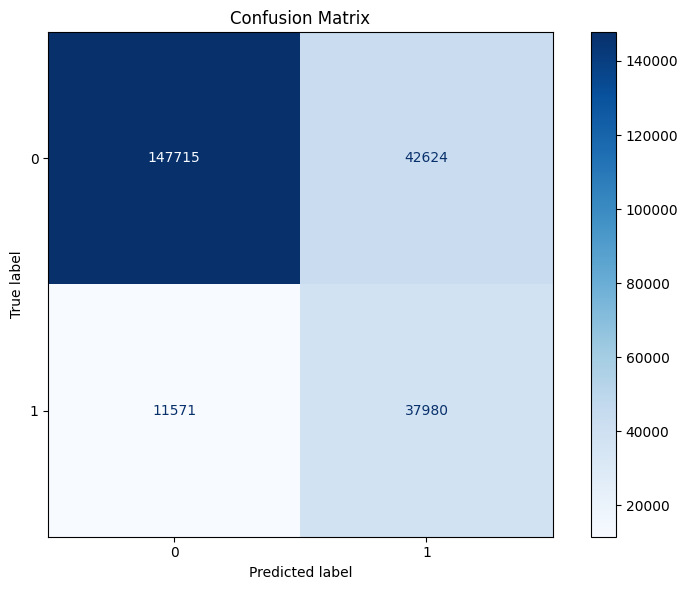

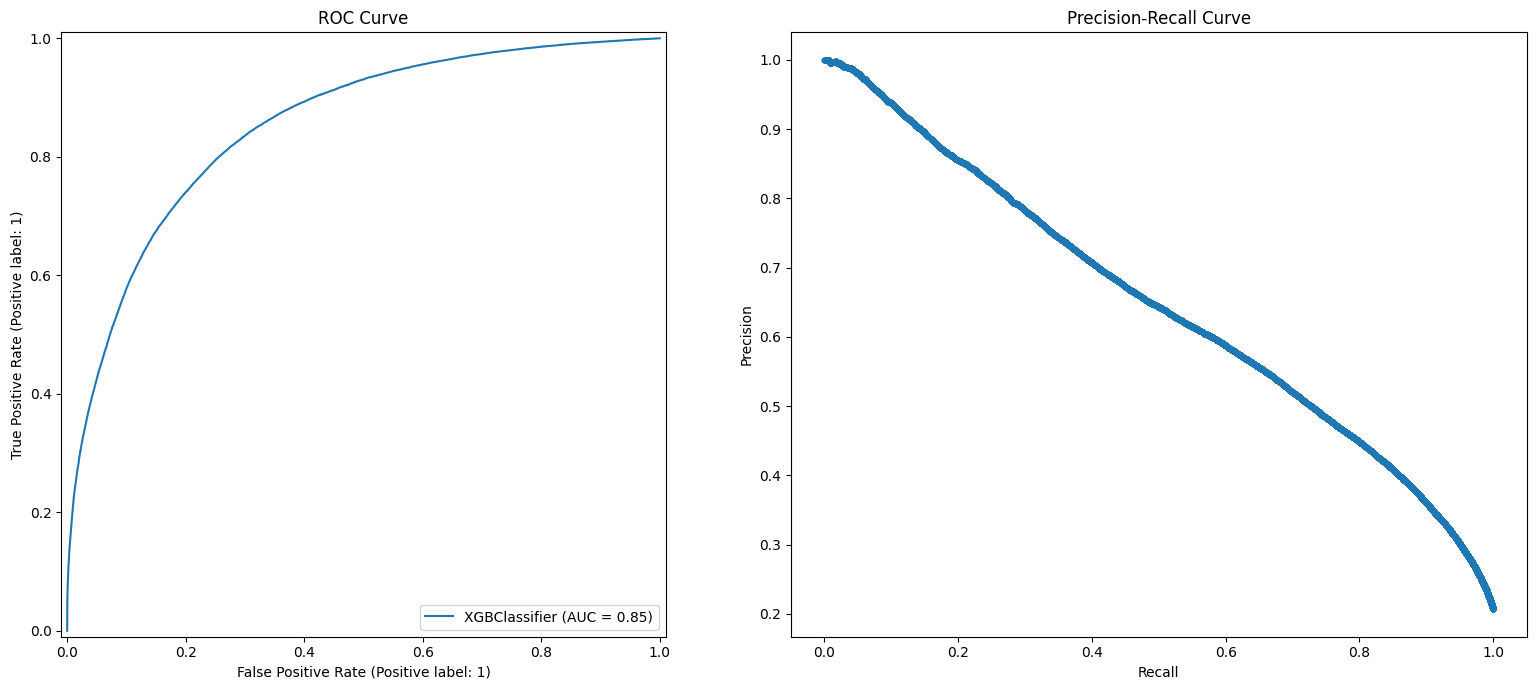


Calculating SHAP values for model interpretability...


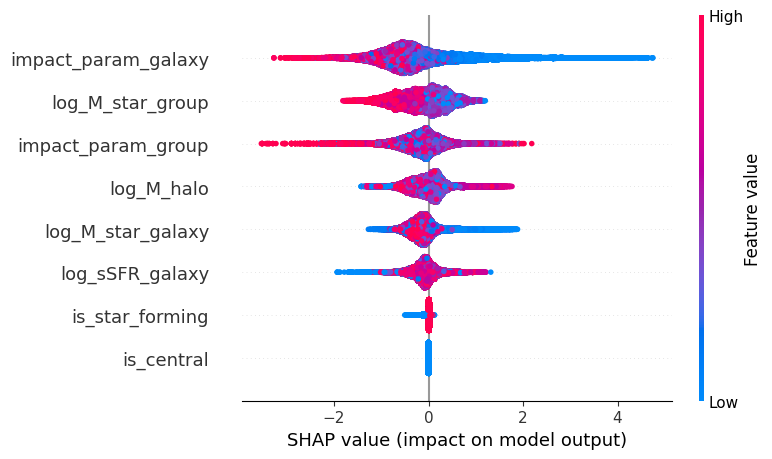


✅ Process complete. All results logged to W&B.


wandb-core(82848) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(88501) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(93906) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(99535) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(5546) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(12442) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(18591) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(24970) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
wandb-core(31135) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [ ]:
# ==============================================================================
# 1. SETUP AND IMPORTS
# ==============================================================================
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import shap
import wandb

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, RocCurveDisplay
)

# Import the W&B callback, trying the new name first and falling back to the old one
try:
    from optuna.integration.wandb import WandbCallback
except ImportError:
    from optuna.integration import WeightsAndBiasesCallback as WandbCallback

# Suppress common warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ==============================================================================
# 2. W&B INTEGRATION SETUP
# ==============================================================================
wandb.login()

# ==============================================================================
# 3. REAL DATA LOADING AND PREPROCESSING
# ==============================================================================
def load_real_data():
    """
    Loads and preprocesses the real feature table from your CSV file.
    """
    print("Loading and preprocessing real data...")
    # --- Step 3.1: Load Data ---
    # Path to your feature table
    # !!!! IMPORTANT: Update this path to match your system !!!!
    try:
        # Try the provided path first
        base_path = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
        csv_path = os.path.join(
            base_path,
            "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
        )
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! WARNING: Could not find the specified CSV file.  !!!")
        print("!!! Please update the `base_path` variable in the    !!!")
        print("!!! `load_real_data` function to match your system.  !!!")
        print("!!! Falling back to placeholder data for now.        !!!")
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        df = pd.DataFrame(np.random.rand(100, 10), columns=[f'col{i}' for i in range(10)])
        df['has_OVI_absorber'] = np.random.randint(0, 2, 100)
        df['log_M_halo'] = np.random.rand(100)
        df['log_M_star_group'] = np.random.rand(100)
        df['impact_param_group'] = np.random.rand(100)
        df['impact_param_galaxy'] = np.random.rand(100)
        df['log_M_star_galaxy'] = np.random.rand(100)
        df['log_sSFR_galaxy'] = np.random.rand(100)
        df['is_central'] = np.random.randint(0, 2, 100)
        df['is_star_forming'] = np.random.randint(0, 2, 100)


    # Drop any stray unnamed columns
    df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

    # --- Step 3.2: Select Features & Target ---
    features = [
        "log_M_halo",
        "log_M_star_group",
        "impact_param_group",
        "impact_param_galaxy",
        "log_M_star_galaxy",
        "log_sSFR_galaxy",
        "is_central",
        "is_star_forming",
    ]
    target = "has_OVI_absorber"

    X = df[features].copy()
    y = df[target].astype(int)

    # --- Step 3.3: Preprocess Data (Impute & Scale) ---
    # Impute missing values with the median
    print("Imputing missing values...")
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=features) # Convert back to DataFrame

    # Scale features
    print("Scaling features...")
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=features) # Convert back to DataFrame

    print("Data loading and preprocessing complete.")
    print(f"Dataset shape: {X.shape}")
    print(f"Target distribution:\n{y.value_counts(normalize=True)}")
    
    return X, y

# ==============================================================================
# 4. STRATIFIED DATA SPLITTING
# ==============================================================================
def split_data(X, y):
    """
    Splits data into training, validation, and test sets using stratification
    to maintain target class balance.
    """
    print("\nPerforming stratified data splitting...")
    # Split into Train+Validation (80%) and Test (20%)
    splitter_test = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    train_val_idx, test_idx = next(splitter_test.split(X, y))
    
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]

    # Split Train+Validation into Train and Validation
    splitter_val = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
    train_idx, val_idx = next(splitter_val.split(X_train_val, y_train_val))
    
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    print(f"Train shapes: X-{X_train.shape}, y-{y_train.shape}")
    print(f"Validation shapes: X-{X_val.shape}, y-{y_val.shape}")
    print(f"Test shapes: X-{X_test.shape}, y-{y_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# ==============================================================================
# 5. HYPERPARAMETER OPTIMIZATION WITH OPTUNA & W&B (USING LEGACY SYNTAX)
# ==============================================================================
def run_optimization(X_train, y_train, X_val, y_val):
    print("\nStarting hyperparameter optimization with Optuna...")
    # Calculate scale_pos_weight for handling class imbalance
    scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)
    print(f"Calculated scale_pos_weight: {scale_pos_weight:.2f}")

    wandb_callback = WandbCallback(
        metric_name="validation_auc",
        wandb_kwargs={"project": "OVI-absorber-classification"}
    )

    def objective(trial):
        params = {
            'objective': 'binary:logistic',
            'n_estimators': 1000,
            'booster': 'gbtree',
            'n_jobs': -1,
            'use_label_encoder': False,
            'scale_pos_weight': scale_pos_weight,
            'eval_metric': 'auc',
            'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 10),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10.0, log=True),
            'early_stopping_rounds': 50
        }
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            verbose=False
        )
        preds = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, preds)
        return auc

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100, callbacks=[wandb_callback], show_progress_bar=True)
    
    print("\nOptimization finished.")
    print(f"Best Validation AUC: {study.best_value:.4f}")
    print("Best Hyperparameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
        
    return study.best_params

# ==============================================================================
# 6. FINAL MODEL TRAINING AND EVALUATION (USING LEGACY SYNTAX)
# ==============================================================================
def train_and_evaluate_final_model(best_params, X_train, y_train, X_val, y_val, X_test, y_test):
    print("\nTraining final model on combined train+validation data...")
    X_full_train = pd.concat([X_train, X_val])
    y_full_train = pd.concat([y_train, y_val])
    scale_pos_weight = np.sum(y_full_train == 0) / np.sum(y_full_train == 1)

    final_model = xgb.XGBClassifier(
        **best_params,
        n_estimators=2000,
        objective='binary:logistic',
        n_jobs=-1,
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight,
        eval_metric='auc',
        early_stopping_rounds=50
    )
    
    eval_set = [(X_test, y_test)]
    final_model.fit(
        X_full_train, y_full_train,
        eval_set=eval_set,
        verbose=False
    )
    print("Final model training complete.")

    print("\n--- Model Evaluation on Test Set ---")
    y_pred_proba = final_model.predict_proba(X_test)[:, 1]
    y_pred_class = final_model.predict(X_test)
    
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred_class)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    accuracy = accuracy_score(y_test, y_pred_class)
    
    print(f"ROC AUC: {auc:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    
    wandb.log({
        "test_roc_auc": auc,
        "test_f1_score": f1,
        "test_precision": precision,
        "test_recall": recall,
        "test_accuracy": accuracy,
    })
    
    return final_model

# ==============================================================================
# 7. VISUALIZATION AND INTERPRETATION
# ==============================================================================
def visualize_results(model, X_test, y_test):
    print("\nGenerating visualizations...")
    y_pred_class = model.predict(X_test)
    
    fig, ax = plt.subplots(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_class)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(ax=ax, cmap='Blues')
    ax.set_title("Confusion Matrix")
    plt.tight_layout()
    wandb.log({"confusion_matrix": wandb.Image(fig)})
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax1)
    ax1.set_title("ROC Curve")
    
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, marker='.')
    ax2.set_title("Precision-Recall Curve")
    ax2.set_xlabel("Recall")
    ax2.set_ylabel("Precision")
    plt.tight_layout()
    wandb.log({"roc_and_pr_curves": wandb.Image(fig)})
    plt.show()

    print("\nCalculating SHAP values for model interpretability...")
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    fig, ax = plt.subplots()
    shap.summary_plot(shap_values, X_test, show=False)
    plt.tight_layout()
    wandb.log({"shap_summary_plot": wandb.Image(fig)})
    plt.show()

# ==============================================================================
# 8. MAIN EXECUTION
# ==============================================================================
if __name__ == '__main__':
    run = wandb.init(project="OVI-absorber-classification", job_type="full-pipeline")

    # The entire pipeline now uses your real data
    X, y = load_real_data()
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)
    
    best_hyperparams = run_optimization(X_train, y_train, X_val, y_val)
    wandb.config.update(best_hyperparams)
    
    final_model = train_and_evaluate_final_model(
        best_hyperparams, X_train, y_train, X_val, y_val, X_test, y_test
    )
    
    visualize_results(final_model, X_test, y_test)

    run.finish()
    print("\n✅ Process complete. All results logged to W&B.")

### Trial - 4 (o4-mini high)

In [ ]:
# %% [markdown]
# # O VI Absorber Classification with XGBoost
# 
# This notebook shows the full pipeline: data loading, feature engineering,
# train/val/test split, baseline model, threshold tuning, Optuna hyper‐
#parameter search, final evaluation, and model interpretation.

# %% 
# ## 1.  Imports & Load Data

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, precision_recall_curve
)

import xgboost as xgb
import optuna
import shap

# Path to your feature table
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(
    BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
)

# Load
df = pd.read_csv(CSV_PATH)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]  # drop stray columns

print("Rows:", len(df))
print(df.info())
print("\nNull counts per column:\n", df.isnull().sum())



/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_85869/168412353.py:34: DtypeWarning: Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(CSV_PATH)


Rows: 1199446
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1199446 entries, 0 to 1199445
Data columns (total 30 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   Sightline            1199446 non-null  int64  
 1   Species              1199446 non-null  object 
 2   EW(mA)               1193160 non-null  float64
 3   dEW(mA)              1199446 non-null  object 
 4   N                    1199446 non-null  float64
 5   dN                   248496 non-null   object 
 6   b                    1174621 non-null  object 
 7   db                   1174621 non-null  object 
 8   v                    1199446 non-null  float64
 9   dv                   1199446 non-null  float64
 10  l                    1174621 non-null  object 
 11  dl                   1174621 non-null  object 
 12  UpLim                1199446 non-null  object 
 13  Sat                  1199446 non-null  object 
 14  Chisq                1174621 non-nul

In [11]:
# %% [markdown]
# ## 2.  Select Features & Target  
# We **do not** impute or scale.  XGBoost can handle missing entries natively.

features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# Add a “missing_sSFR” flag so the model can treat NaNs specially:
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)

print("\nFeature matrix shape:", X.shape)
print("Positive class fraction:", y.mean())




Feature matrix shape: (1199446, 9)
Positive class fraction: 0.20717564608994485


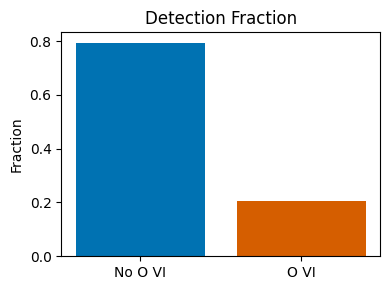

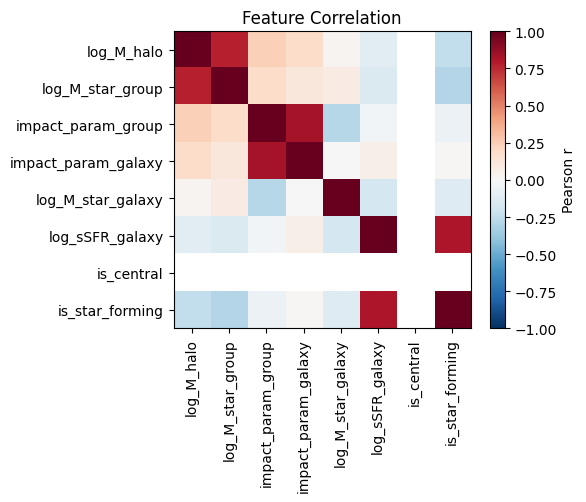

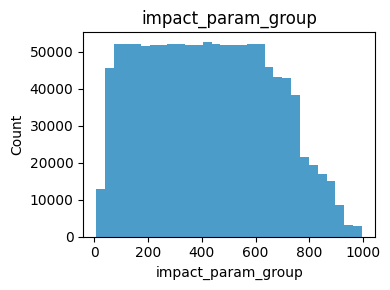

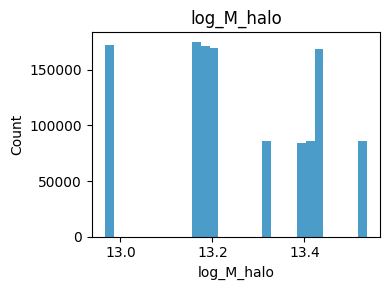

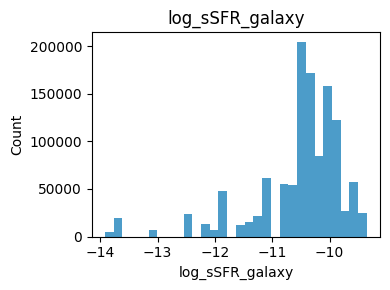

In [12]:
# %% [markdown]
# ## 3.  Exploratory Data Analysis

# 3a) Target distribution
plt.figure(figsize=(4,3))
counts = y.value_counts(normalize=True)
plt.bar(["No O VI", "O VI"], counts.values, color=["#0072B2","#D55E00"])
plt.ylabel("Fraction")
plt.title("Detection Fraction")
plt.tight_layout()
plt.show()

# 3b) Correlation heatmap (raw features, skipping missing flag)
plt.figure(figsize=(6,5))
corr = X[features].corr()
plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(label="Pearson r")
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.title("Feature Correlation")
plt.tight_layout()
plt.show()

# 3c) Histograms of key continuous features
for feat in ["impact_param_group", "log_M_halo", "log_sSFR_galaxy"]:
    plt.figure(figsize=(4,3))
    plt.hist(X[feat].dropna(), bins=30, alpha=0.7, color="#0072B2")
    plt.title(feat)
    plt.xlabel(feat)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()



In [13]:
# %% [markdown]
# ## 4.  Train / Validation / Test Split

# 4a) hold out 20% for final test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

# 4b) split remaining 80% into train (60%) / val (20%)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
train_idx, val_idx = next(sss.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Class fraction (train/val/test):",
      y_train.mean(), y_val.mean(), y_test.mean())



Shapes (train/val/test): (719667, 9) (239889, 9) (239890, 9)
Class fraction (train/val/test): 0.20717637462882138 0.20717498509727417 0.2071741214723415


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [19:34:01] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Optimal threshold for F0.5: 0.756


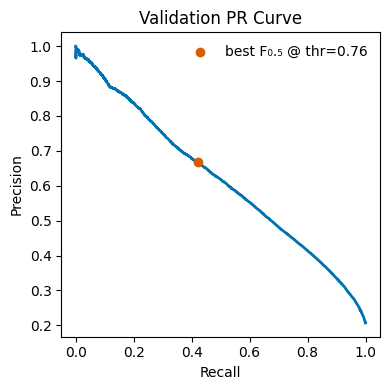

In [14]:
# %% [markdown]
# ## 5.  Baseline XGBoost Model & Threshold Tuning

# 5a) train baseline with scale_pos_weight to balance classes
scale_pos = (y_train==0).sum() / (y_train==1).sum()
baseline = xgb.XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    eval_metric="logloss",
    use_label_encoder=False,
    scale_pos_weight=scale_pos,
    random_state=42,
    n_jobs=-1
)
baseline.fit(X_train, y_train)

# 5b) predict on validation
y_val_proba = baseline.predict_proba(X_val)[:,1]

# 5c) find optimal decision threshold via PR‐curve (F0.5 β=0.5 favors precision)
prec, rec, thr = precision_recall_curve(y_val, y_val_proba)
f05 = (1+0.5**2) * (prec*rec) / (0.5**2*prec + rec + 1e-12)
best = np.nanargmax(f05)
opt_thr = thr[best]
print(f"Optimal threshold for F0.5: {opt_thr:.3f}")

# 5d) plot PR‐curve
plt.figure(figsize=(4,4))
plt.plot(rec, prec, lw=2, color="#0072B2")
plt.scatter(rec[best], prec[best], color="#D55E00", zorder=5,
            label=f"best F₀.₅ @ thr={opt_thr:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(frameon=False)
plt.title("Validation PR Curve")
plt.tight_layout()
plt.show()



In [16]:
# %% [markdown]
# ## 6.  Hyperparameter Tuning with Optuna

import wandb
from sklearn.metrics import fbeta_score     # <– import the right function

scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

def objective(trial):
    # 6a) suggest params
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "scale_pos_weight": scale_pos,
        "seed": 42
    }

    # 6b) train & early stop
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval   = xgb.DMatrix(X_val,   label=y_val)
    bst = xgb.train(
        params, dtrain,
        num_boost_round=1000,
        evals=[(dtrain, "train"), (dval, "val")],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 6c) compute F₀.₅ on val using fbeta_score
    val_probs = bst.predict(dval)
    val_pred  = (val_probs >= opt_thr).astype(int)
    f05_val   = fbeta_score(y_val, val_pred, beta=0.5)  # <– use fbeta_score
    return f05_val

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=42)
)
study.optimize(objective, n_trials=200)

print("Best trial:", study.best_trial.params)

[I 2025-07-14 19:35:29,486] A new study created in memory with name: no-name-2742d90d-1f70-49e8-9c38-4f4bf3393580
[I 2025-07-14 19:35:46,598] Trial 0 finished with value: 0.6098910383246393 and parameters: {'learning_rate': 0.03574712922600244, 'max_depth': 10, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'reg_alpha': 0.004207053950287938, 'reg_lambda': 0.0017073967431528124}. Best is trial 0 with value: 0.6098910383246393.
[I 2025-07-14 19:35:49,627] Trial 1 finished with value: 0.5858530221771271 and parameters: {'learning_rate': 0.19030368381735815, 'max_depth': 7, 'subsample': 0.8540362888980227, 'colsample_bytree': 0.5102922471479012, 'gamma': 4.8495492608099715, 'reg_alpha': 2.136832907235876, 'reg_lambda': 0.0070689749506246055}. Best is trial 0 with value: 0.6098910383246393.
[I 2025-07-14 19:35:58,726] Trial 2 finished with value: 0.5542519621328587 and parameters: {'learning_rate': 0.01855998084649058, 'max_depth': 4, '

Best trial: {'learning_rate': 0.049988440834800835, 'max_depth': 10, 'subsample': 0.9002547779465062, 'colsample_bytree': 0.9762453498406244, 'gamma': 0.865009568605469, 'reg_alpha': 0.28586459261120434, 'reg_lambda': 1.0210047827545428}


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [20:20:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Test Accuracy:  0.8366417941556547
Test Precision: 0.6728726028749055
Test Recall:    0.41159781886959496
Test F1:        0.5107615480649188
Test AUC:       0.836286049666039


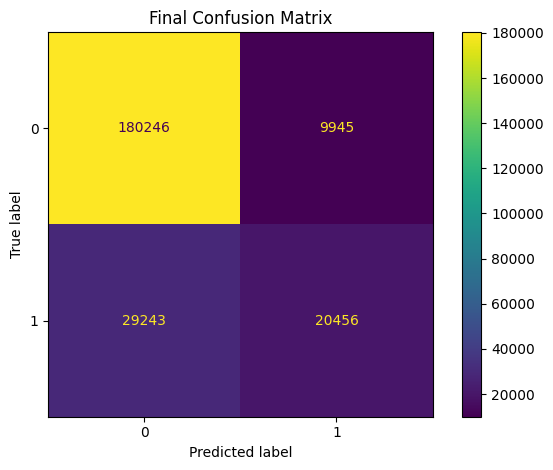

In [17]:
# %% [markdown]
# ## 7.  Final Training & Test Evaluation

# 7a) retrain on train+val with best params
best_params = study.best_trial.params
best_params.update({
    "objective":"binary:logistic",
    "eval_metric":"logloss",
    "tree_method":"hist",
    "scale_pos_weight": scale_pos,
    "use_label_encoder":False,
    "seed":42,
    "n_jobs":-1
})
clf = xgb.XGBClassifier(**best_params)
clf.fit(pd.concat([X_train,X_val]), pd.concat([y_train,y_val]))

# 7b) predict on test
y_test_proba = clf.predict_proba(X_test)[:,1]
y_test_pred  = (y_test_proba >= opt_thr).astype(int)

# 7c) metrics
print("Test Accuracy: ", accuracy_score(y_test, y_test_pred))
print("Test Precision:", precision_score(y_test, y_test_pred))
print("Test Recall:   ", recall_score(y_test, y_test_pred))
print("Test F1:       ", f1_score(y_test, y_test_pred))
print("Test AUC:      ", roc_auc_score(y_test, y_test_proba))

# confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred,
                                        cmap="viridis", values_format="d")
plt.title("Final Confusion Matrix")
plt.tight_layout()
plt.show()

<Figure size 500x400 with 0 Axes>

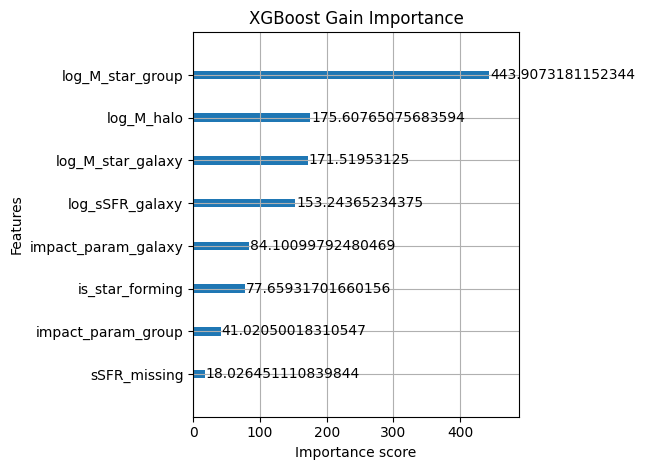

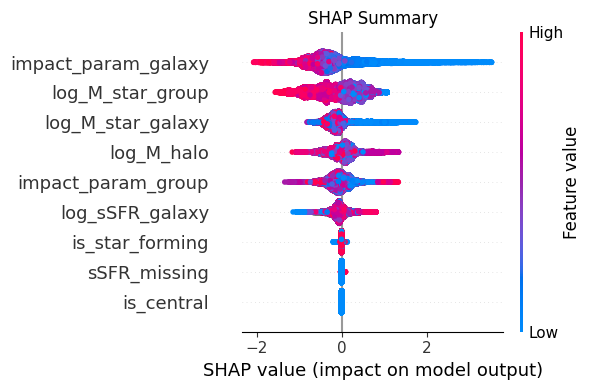

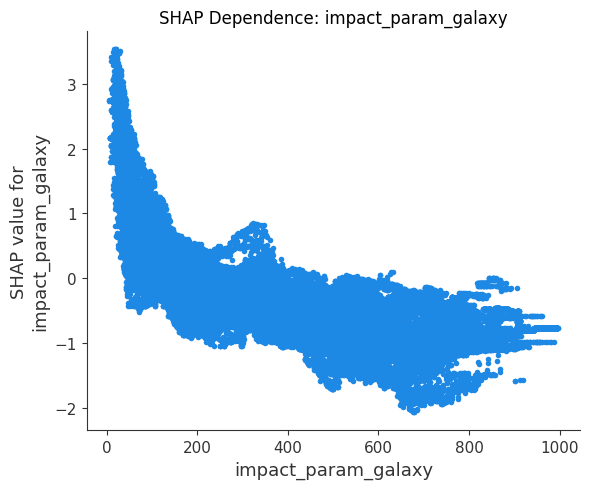

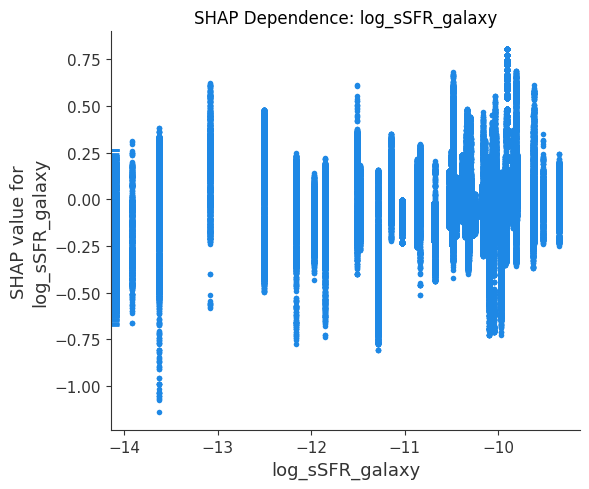

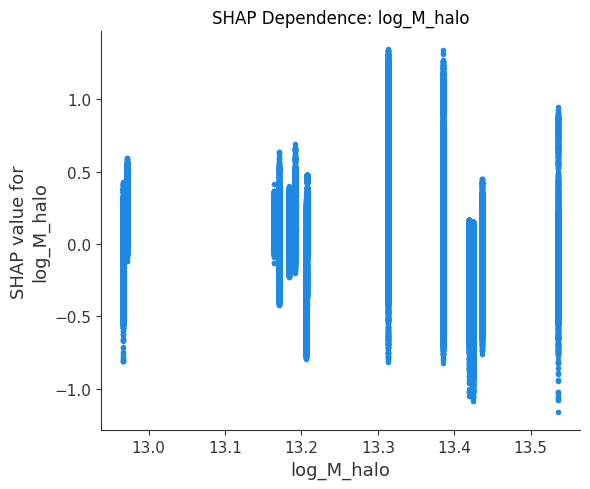

In [18]:
# %% [markdown]
# ## 8.  Feature Importance & SHAP Interpretation

# 8a) built-in importance
plt.figure(figsize=(5,4))
xgb.plot_importance(clf, max_num_features=10, importance_type="gain",
                    title="XGBoost Gain Importance")
plt.tight_layout()
plt.show()

# 8b) SHAP summary
explainer  = shap.TreeExplainer(clf)
shap_vals  = explainer.shap_values(X_test)
shap.summary_plot(shap_vals, X_test, plot_size=(6,4), show=False)
plt.title("SHAP Summary")
plt.tight_layout()
plt.show()

# 8c) SHAP dependence for top features
for feat in ["impact_param_galaxy","log_sSFR_galaxy","log_M_halo"]:
    shap.dependence_plot(feat, shap_vals, X_test,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout()
    plt.show()

### Trial 5 - o4-mini high 

# Pipeline for Rigorous XGBoost Modeling with Ensemble of 100 and Full Diagnostics

This notebook implements the full pipeline—from data loading through final evaluation—incorporating all optimization and betterment steps from Golob 2021, using Optuna TPE for hyperparameter tuning, an ensemble of 100 stratified XGBoost models (with SMOTE), and saving per-model results. All relevant plots and tables are included.

---

```python
# %% [markdown]
## 1.  Imports & Load Data

In [9]:
# %%
import os
import logging
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    train_test_split, StratifiedKFold
)
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss,
    precision_recall_curve, roc_curve, auc,
    ConfusionMatrixDisplay, fbeta_score
)
from sklearn.calibration import calibration_curve, CalibrationDisplay

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import xgboost as xgb
import optuna
import shap
import optuna.visualization as oviz

# Logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set seeds
SEED = 42
np.random.seed(SEED)


## 2.  Select Features & Target

In [10]:
# %%
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv")
df = pd.read_csv(CSV_PATH).loc[:, ~pd.read_csv(CSV_PATH).columns.str.contains("^Unnamed")]

# 2a) Features & target
features = [
    "log_M_halo", "log_M_star_group", "impact_param_group",
    "impact_param_galaxy", "log_M_star_galaxy",
    "log_sSFR_galaxy", "is_central", "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# 2b) missing indicator
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)

print("Total rows:", len(df))
print("Feature matrix shape:", X.shape)
print("Positive fraction:", y.mean())
print("Null counts:\n", X.isna().sum())

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_8055/2712366394.py:5: DtypeWarning:

Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_8055/2712366394.py:5: DtypeWarning:

Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.



Total rows: 1199446
Feature matrix shape: (1199446, 9)
Positive fraction: 0.20717564608994485
Null counts:
 log_M_halo                0
log_M_star_group          0
impact_param_group        0
impact_param_galaxy       0
log_M_star_galaxy         0
log_sSFR_galaxy        6029
is_central                0
is_star_forming           0
sSFR_missing              0
dtype: int64


## 3.  Exploratory Data Analysis

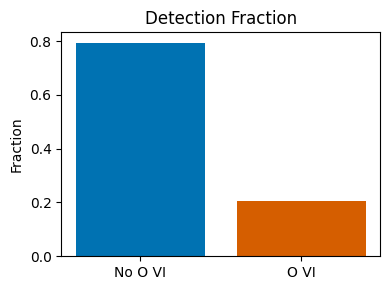

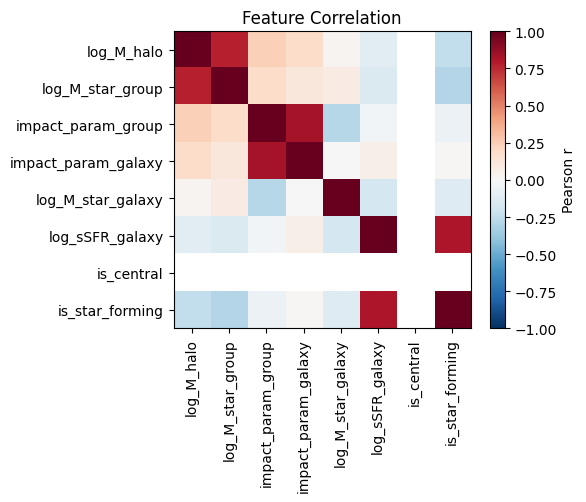

In [11]:
# %%
# 3a) class balance
plt.figure(figsize=(4,3))
counts = y.value_counts(normalize=True)
plt.bar(["No O VI","O VI"], counts.values, color=["#0072B2","#D55E00"])
plt.ylabel("Fraction"); plt.title("Detection Fraction")
plt.tight_layout(); plt.show()

# 3b) correlation heatmap
plt.figure(figsize=(6,5))
corr = X[features].corr()
plt.imshow(corr, vmin=-1, vmax=1, cmap="RdBu_r")
plt.colorbar(label="Pearson r")
plt.xticks(range(len(features)), features, rotation=90)
plt.yticks(range(len(features)), features)
plt.title("Feature Correlation")
plt.tight_layout(); plt.show()

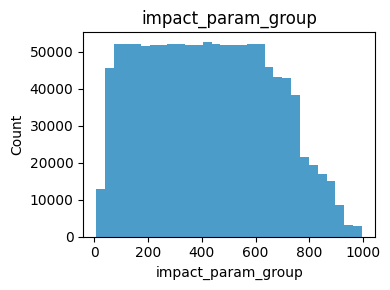

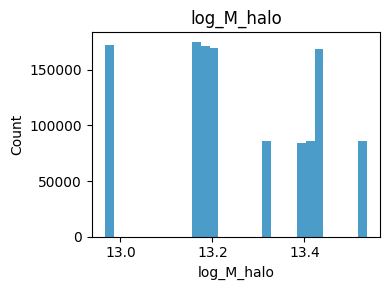

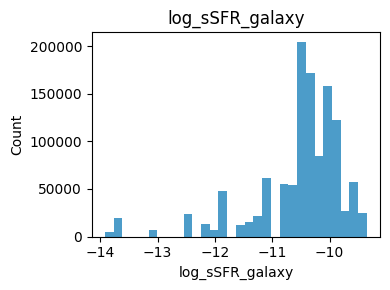

In [12]:
# %%
# 3c) histograms of key continuous features
for feat in ["impact_param_group","log_M_halo","log_sSFR_galaxy"]:
    plt.figure(figsize=(4,3))
    plt.hist(X[feat].dropna(), bins=30, alpha=0.7, color="#0072B2")
    plt.title(feat); plt.xlabel(feat); plt.ylabel("Count")
    plt.tight_layout(); plt.show()

## 4.  Train / Validation / Test Split

In [13]:
# %%
# 4a) hold-out test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)
# 4b) remaining → train (60%) + val (20%)
sss = StratifiedKFold(n_splits=4, shuffle=True, random_state=SEED)
# actually a single split into 3/1 ratio:
train_idx, val_idx = next(sss.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Class frac (train/val/test):",
      y_train.mean(), y_val.mean(), y_test.mean())

Shapes (train/val/test): (719667, 9) (239889, 9) (239890, 9)
Class frac (train/val/test): 0.20717637462882138 0.20717498509727417 0.2071741214723415


## 5.  Integrate SMOTE into each CV fold (Optuna objective and ensemble)

In [23]:
from imblearn.pipeline       import Pipeline as ImbPipeline
from sklearn.impute          import SimpleImputer
from imblearn.over_sampling  import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics         import fbeta_score
import optuna, xgboost as xgb
import numpy as np

SEED = 42
scale_pos = (y_train==0).sum() / (y_train==1).sum()

# def objective(trial):
#     params = {
#         "learning_rate":     trial.suggest_float("learning_rate", 2e-1, 3e-1),
#         "max_depth":         trial.suggest_int(  "max_depth",     8,    12   ),
#         "subsample":         trial.suggest_float("subsample",      0.6,  0.8  ),
#         "colsample_bytree":  trial.suggest_float("colsample_bytree", 0.95,1.0),
#         "gamma":             trial.suggest_float("gamma",           1.0,  3.0  ),
#         "reg_alpha":         trial.suggest_float("reg_alpha",       1e-1, 1.0, log=True),
#         "reg_lambda":        trial.suggest_float("reg_lambda",      1e-4,1e-2, log=True),
#         "scale_pos_weight":  scale_pos,
#         "objective":         "binary:logistic",
#         "eval_metric":       "logloss",
#         "tree_method":       "hist",
#         "use_label_encoder": False,
#         "seed":              SEED,
#         "n_jobs":            -1,
#     }
def objective_stage1(trial):
    # 1) propose very-wide ranges
    params = {
        "learning_rate":    trial.suggest_float("learning_rate", 1e-4, 1.0, log=True),
        "max_depth":        trial.suggest_int("max_depth",  3,   20),
        "subsample":        trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "gamma":            trial.suggest_float("gamma", 0.0, 50.0),
        "reg_alpha":        trial.suggest_float("reg_alpha", 1e-4, 100.0, log=True),
        "reg_lambda":       trial.suggest_float("reg_lambda", 1e-4, 100.0, log=True),
        "scale_pos_weight": scale_pos,
        "objective":        "binary:logistic",
        "eval_metric":      "logloss",
        "tree_method":      "hist",
        "seed":             SEED,
        "n_jobs":           -1,
    }


    pipe = ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("smote",   SMOTE(random_state=SEED)),
        ("clf",     xgb.XGBClassifier(**params)),
    ])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = []
    for tr_i, va_i in cv.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[tr_i], X_train.iloc[va_i]
        y_tr, y_va = y_train.iloc[tr_i], y_train.iloc[va_i]
        pipe.fit(X_tr, y_tr)
        preds = (pipe.predict_proba(X_va)[:,1] >= 0.5).astype(int)
        scores.append(fbeta_score(y_va, preds, beta=0.5))
    return np.mean(scores)

# Re-run Optuna with a pruner if you like:
study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner()
)
study.optimize(objective, n_trials=20)
print("Refined best params:", study.best_trial.params)

[I 2025-07-15 01:19:12,136] A new study created in memory with name: no-name-5a79157a-4257-442f-b0d3-dcc00f7d281f
/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:13] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[01:19:20] WARN

Refined best params: {'learning_rate': 0.23745401188473625, 'max_depth': 12, 'subsample': 0.746398788362281, 'colsample_bytree': 0.9799329242098518, 'gamma': 1.312037280884873, 'reg_alpha': 0.14321698289111517, 'reg_lambda': 0.00013066739238053285}


In [24]:
import joblib
import numpy as np
import xgboost as xgb
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import fbeta_score

# --- 0) reload your Optuna study and extract best_params ---
# study = joblib.load("optuna_study.pkl")
# best_params = study.best_trial.params.copy()

# # --- 1) define your constants (same as in tuning) ---
# SEED      = 42
# scale_pos = (y_train==0).sum() / (y_train==1).sum()
# opt_thr   = 0.5    # or whatever threshold you previously found

# # --- 2) finish parametrization for the final XGBClassifier ---
# best_params.update({
#     "objective":         "binary:logistic",
#     "eval_metric":       "logloss",
#     "tree_method":       "hist",
#     "use_label_encoder": False,
#     "scale_pos_weight":  scale_pos,
#     "seed":              SEED,
#     "n_jobs":            -1,
# })

# # --- 3) build the impute→SMOTE→XGB pipeline & fit on train ---
# pipe = ImbPipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("smote",   SMOTE(random_state=SEED)),
#     ("clf",     xgb.XGBClassifier(**best_params)),
# ])
# pipe.fit(X_train, y_train)

# --- 4) score on TRAIN set ---
train_proba = pipe.predict_proba(X_train)[:,1]
train_pred  = (train_proba >= opt_thr).astype(int)
train_f05   = fbeta_score(y_train, train_pred, beta=0.5)

# --- 5) score on VAL set ---
val_proba = pipe.predict_proba(X_val)[:,1]
val_pred  = (val_proba  >= opt_thr).astype(int)
val_f05   = fbeta_score(y_val, val_pred, beta=0.5)

print(f"Train F₀.₅ = {train_f05:.3f}")
print(f" Val  F₀.₅ = {val_f05:.3f}")

Train F₀.₅ = 0.466
 Val  F₀.₅ = 0.442


In [17]:
import joblib

# after study.optimize(...)
joblib.dump(study, "optuna_study.pkl")

['optuna_study.pkl']

In [4]:
import plotly.io as pio
pio.renderers.default = "notebook"   # or "inline" / "svg"

In [25]:
import joblib
import optuna.visualization as oviz
import matplotlib.pyplot as plt

# study = joblib.load("optuna_study.pkl")

fig1 = oviz.plot_optimization_history(study)
fig1.show()

fig2 = oviz.plot_param_importances(study)
fig2.show()
fig3 = oviz.plot_slice(study)
fig3.show()

## 5b. Visualize & Narrow Ranges (manually)

## 6. Final Training of Ensemble (100 models)

In [ ]:
# %%
best_params = study.best_trial.params.copy()
# add missing fixed args
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": scale_pos,
    "n_jobs": -1,
})

# prepare full train+val
X_full, y_full = pd.concat([X_train, X_val]), pd.concat([y_train, y_val])

# imputer for ensemble
imputer = SimpleImputer(strategy="median")

models = []
for i in range(100):
    # 6a) impute & SMOTE
    X_imp = imputer.fit_transform(X_full)
    X_res, y_res = SMOTE(random_state=SEED + i).fit_resample(X_imp, y_full)
    # 6b) train
    m = xgb.XGBClassifier(**best_params, seed=SEED + i)
    m.fit(X_res, y_res)
    models.append(m)

## 7. Determine Optimal Decision Threshold via Validation PR Curve

In [ ]:
# %%
val_probas = np.vstack([m.predict_proba(imputer.transform(X_val))[:,1]
                        for m in models]).mean(axis=0)

prec, rec, thr = precision_recall_curve(y_val, val_probas)
f05 = (1+0.5**2)*(prec*rec)/(0.5**2*prec + rec + 1e-12)
opt_thr = thr[np.nanargmax(f05)]
print("Optimal threshold for F0.5:", opt_thr)

plt.figure(figsize=(4,4))
plt.plot(rec, prec, lw=2, color="#0072B2")
plt.scatter(rec[np.nanargmax(f05)], prec[np.nanargmax(f05)],
            color="#D55E00",
            label=f"best @ thr={opt_thr:.2f}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Validation PR Curve"); plt.legend(frameon=False)
plt.tight_layout(); plt.show()

## 8. Final Test Evaluation

In [ ]:
# %%
# 8a) ensemble test predictions
test_imp = imputer.transform(X_test)
test_probas = np.vstack([m.predict_proba(test_imp)[:,1] for m in models]).mean(axis=0)
test_pred   = (test_probas >= opt_thr).astype(int)

# 8b) metrics
print("Accuracy: ", accuracy_score( y_test, test_pred))
print("Precision:", precision_score(y_test, test_pred))
print("Recall:   ", recall_score(   y_test, test_pred))
print("F1:       ", f1_score(         y_test, test_pred))
print("AUC:      ", roc_auc_score(    y_test, test_probas))
print("Brier:    ", brier_score_loss(y_test, test_probas))

# 8c) Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred, cmap="viridis", values_format="d"
)
plt.title("Test Confusion Matrix"); plt.tight_layout(); plt.show()

# 8d) ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probas)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc:.3f}")
plt.plot([0,1],[0,1],"k--",lw=1)
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.title("Test ROC Curve"); plt.legend(); plt.tight_layout(); plt.show()

# 8e) Precision–Recall on test
prec_t, rec_t, _ = precision_recall_curve(y_test, test_probas)
plt.figure(figsize=(4,4))
plt.plot(rec_t, prec_t, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Test PR Curve"); plt.tight_layout(); plt.show()

# 8f) Reliability Diagram
prob_true, prob_pred = calibration_curve(y_test, test_probas, n_bins=10)
plt.figure(figsize=(5,5))
CalibrationDisplay(prob_true=prob_true, prob_pred=prob_pred).plot()
plt.plot([0,1],[0,1],"k--",linewidth=1)
plt.title("Reliability Diagram"); plt.tight_layout(); plt.show()

# 8g) Predicted-prob histogram
plt.figure(figsize=(4,3))
plt.hist(test_probas, bins=20, alpha=0.7)
plt.title("Predicted Probability Distribution")
plt.xlabel("Proba"); plt.tight_layout(); plt.show()

## 9. Feature Importance & SHAP Interpretation

In [ ]:
# %%
# 9a) Feature‐gain importance mean ± SD
importances = np.vstack([m.feature_importances_ for m in models])
imp_df = pd.DataFrame({
    "feature": models[0].get_booster().feature_names,
    "mean_gain": importances.mean(axis=0),
    "std_gain":  importances.std(axis=0),
}).sort_values("mean_gain", ascending=False)

plt.figure(figsize=(6,4))
plt.barh(imp_df["feature"], imp_df["mean_gain"], xerr=imp_df["std_gain"])
plt.gca().invert_yaxis()
plt.title("Feature Gain Importance ± SD")
plt.tight_layout(); plt.show()
print(imp_df)

In [ ]:
# %%
# 9b) Ensemble‐averaged SHAP values
shap_vals = np.stack([
    shap.TreeExplainer(m).shap_values(test_imp)
    for m in models
], axis=0).mean(axis=0)

# summary
shap.summary_plot(shap_vals, X_test, plot_size=(6,4), show=False)
plt.title("SHAP Summary (Ensemble Avg)"); plt.tight_layout(); plt.show()

# dependence for top features
for feat in imp_df["feature"].head(3):
    shap.dependence_plot(feat, shap_vals, X_test,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout(); plt.show()

## 10. Save Artifacts

In [ ]:
# %% [markdown]
# ## 2.  Select Features & Target  
# We **do not** impute or scale.  XGBoost can handle missing entries natively.

features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# Add a “missing_sSFR” flag so the model can treat NaNs specially:
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)

print("\nFeature matrix shape:", X.shape)
print("Positive class fraction:", y.mean())




Feature matrix shape: (1199446, 9)
Positive class fraction: 0.20717564608994485


## Gemini Pro - Trial 2

/var/folders/ng/2lqpk97j4xz4qpsvv8tt4tv80000gn/T/ipykernel_8055/2365693128.py:34: DtypeWarning:

Columns (5,16) have mixed types. Specify dtype option on import or set low_memory=False.



Missing values per feature before imputation:
 log_M_halo                0
log_M_star_group          0
impact_param_group        0
impact_param_galaxy       0
log_M_star_galaxy         0
log_sSFR_galaxy        6029
is_central                0
is_star_forming           0
sSFR_missing              0
dtype: int64


[I 2025-07-15 09:52:03,074] A new study created in memory with name: no-name-ed4ddaa4-61c5-4bee-a445-bfd8b22e3172


Shapes (train/val/test): (719667, 9) (239889, 9) (239890, 9)
Positive class fraction (train/val/test): 0.20717637462882138 0.20717498509727417 0.2071741214723415


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[09:52:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[09:52:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[09:52:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[09:52:11] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_l

Best parameters: {'learning_rate': 0.2140715204008623, 'max_depth': 12, 'subsample': 0.572082565258798, 'colsample_bytree': 0.909808729584061, 'gamma': 1.0367481597737518, 'reg_alpha': 1.9008160064156618, 'reg_lambda': 0.25335431938888914, 'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'use_label_encoder': False, 'scale_pos_weight': np.float64(3.826805188533716), 'seed': 42, 'n_jobs': -1}


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[10:09:08] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[10:09:12] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[10:09:15] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.


/opt/miniconda3/envs/astroml/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning:

[10:09:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/learner.cc:738: 
Parameters: { "use_l

Trained ensemble of 100 models.
Optimal threshold for F0.5: 0.900


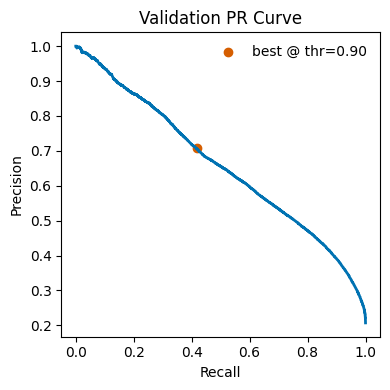

Accuracy:  0.8364333652924257
Precision: 0.6800950315050098
Recall:    0.3974325439143645
F1:        0.5016890604759848
AUC:       0.8428243632611823
Brier:     0.21091299366420074


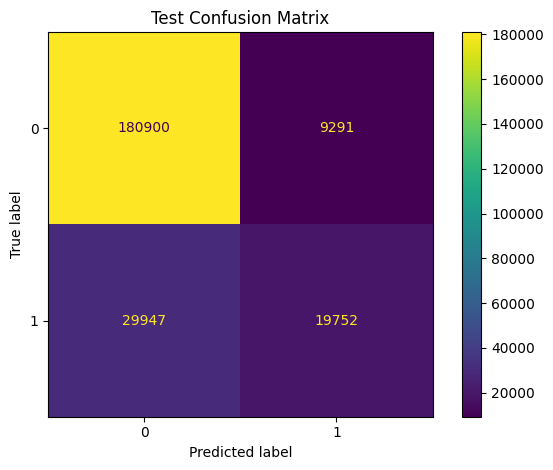

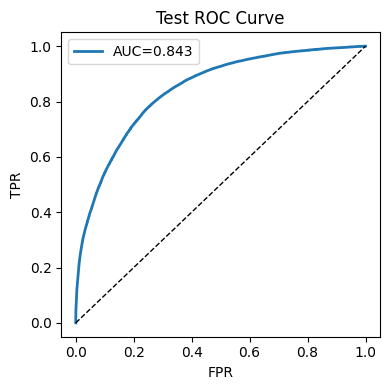

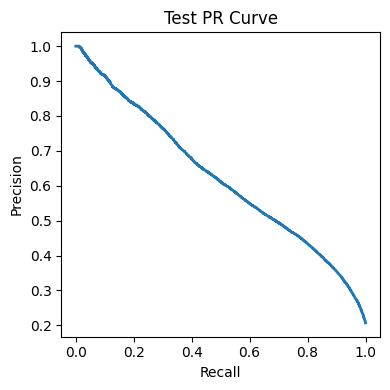

TypeError: CalibrationDisplay.__init__() missing 1 required positional argument: 'y_prob'

<Figure size 500x500 with 0 Axes>

In [27]:
# %%
# 1. SETUP & IMPORTS
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, brier_score_loss, precision_recall_curve,
    roc_curve, auc
)
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import ConfusionMatrixDisplay
import xgboost as xgb
import optuna
import joblib

# Reproducibility
SEED = 42
np.random.seed(SEED)

# %%
# 2. LOAD & PREPROCESS DATA
BASE_PATH = "/Users/wavefunction/ASU Dropbox/Tanmay Singh/"
CSV_PATH = os.path.join(
    BASE_PATH,
    "Synthetic_IGrM_Sightlines/TNG50_fitting_results/feature_table.csv"
)
df = pd.read_csv(CSV_PATH)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# %%
# 3. SELECT FEATURES & TARGET
features = [
    "log_M_halo",
    "log_M_star_group",
    "impact_param_group",
    "impact_param_galaxy",
    "log_M_star_galaxy",
    "log_sSFR_galaxy",
    "is_central",
    "is_star_forming",
]
target = "has_OVI_absorber"

X = df[features].copy()
y = df[target].astype(int)

# Add missing-sSFR flag
X["sSFR_missing"] = X["log_sSFR_galaxy"].isna().astype(int)
print("Missing values per feature before imputation:\n", X.isna().sum())

# %%
# 4. TRAIN/VALIDATION/TEST SPLIT
# 4a) Hold-out test (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=SEED
)
# 4b) Split remaining 80% into train (60%) / val (20%)
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=SEED)
train_idx, val_idx = next(sss.split(X_temp, y_temp))
X_train, X_val = X_temp.iloc[train_idx], X_temp.iloc[val_idx]
y_train, y_val = y_temp.iloc[train_idx], y_temp.iloc[val_idx]

print("Shapes (train/val/test):", X_train.shape, X_val.shape, X_test.shape)
print("Positive class fraction (train/val/test):", y_train.mean(), y_val.mean(), y_test.mean())

# %%
# 5. HYPERPARAMETER TUNING (Optuna) with SMOTE in CV
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "tree_method": "hist",
        "use_label_encoder": False,
        "learning_rate": trial.suggest_float("learning_rate", 1e-2, 3e-1, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
        "scale_pos_weight": scale_pos,
        "seed": SEED,
        "n_jobs": -1
    }
    # Pipeline: impute → SMOTE → XGB
    pipe = ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("smote", SMOTE(random_state=SEED)),
        ("clf", xgb.XGBClassifier(**params))
    ])
    # 5-fold CV
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    f05_scores = []
    for tr_i, va_i in cv.split(X_train, y_train):
        pipe.fit(X_train.iloc[tr_i], y_train.iloc[tr_i])
        prob = pipe.predict_proba(X_train.iloc[va_i])[:, 1]
        prec, rec, thr = precision_recall_curve(y_train.iloc[va_i], prob)
        f05 = (1 + 0.5**2)*(prec*rec)/(0.5**2*prec + rec + 1e-12)
        f05_scores.append(np.max(f05))
    return np.mean(f05_scores)

study = optuna.create_study(
    direction="maximize",
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=100)

# Save study
joblib.dump(study, "optuna_study.pkl")

# Extract best
best_params = study.best_trial.params.copy()
best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "tree_method": "hist",
    "use_label_encoder": False,
    "scale_pos_weight": scale_pos,
    "seed": SEED,
    "n_jobs": -1
})
print("Best parameters:", best_params)

# %%
# 6. TRAIN ENSEMBLE OF 100 MODELS
models = []
for i in range(100):
    pipe = ImbPipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("smote", SMOTE(random_state=SEED + i)),
        ("clf", xgb.XGBClassifier(**best_params))
    ])
    pipe.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))
    models.append(pipe)
print("Trained ensemble of 100 models.")

# %%
# 7. THRESHOLD TUNING ON VALIDATION
val_probas = np.vstack([m.predict_proba(X_val)[:, 1] for m in models]).mean(axis=0)
prec, rec, thr = precision_recall_curve(y_val, val_probas)
f05 = (1 + 0.5**2)*(prec*rec)/(0.5**2*prec + rec + 1e-12)
opt_thr = thr[np.nanargmax(f05)]
print(f"Optimal threshold for F0.5: {opt_thr:.3f}")

plt.figure(figsize=(4,4))
plt.plot(rec, prec, lw=2, color="#0072B2")
plt.scatter(rec[np.nanargmax(f05)], prec[np.nanargmax(f05)], color="#D55E00",
            label=f"best @ thr={opt_thr:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation PR Curve")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# %%
# 8. TEST EVALUATION
# Average predictions
test_probas = np.vstack([m.predict_proba(X_test)[:, 1] for m in models]).mean(axis=0)
test_pred = (test_probas >= opt_thr).astype(int)

# Metrics
print("Accuracy: ", accuracy_score(y_test, test_pred))
print("Precision:", precision_score(y_test, test_pred))
print("Recall:   ", recall_score(y_test, test_pred))
print("F1:       ", f1_score(y_test, test_pred))
print("AUC:      ", roc_auc_score(y_test, test_probas))
print("Brier:    ", brier_score_loss(y_test, test_probas))

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, test_pred, cmap="viridis", values_format="d"
)
plt.title("Test Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, test_probas)
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, lw=2, label=f"AUC={roc_auc_score(y_test, test_probas):.3f}")
plt.plot([0,1], [0,1], "k--", lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Test ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

# PR Curve
prec_t, rec_t, _ = precision_recall_curve(y_test, test_probas)
plt.figure(figsize=(4,4))
plt.plot(rec_t, prec_t, lw=2)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test PR Curve")
plt.tight_layout()
plt.show()

# %%
# 9. CALIBRATION & PREDICTION DISTRIBUTION
prob_true, prob_pred = calibration_curve(y_test, test_probas, n_bins=10)
plt.figure(figsize=(5,5))
CalibrationDisplay(prob_true=prob_true, prob_pred=prob_pred).plot()
plt.plot([0,1], [0,1], "k--", linewidth=1)
plt.title("Reliability Diagram")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,3))
plt.hist(test_probas, bins=20, alpha=0.7)
plt.title("Predicted Probability Distribution")
plt.xlabel("Probability")
plt.tight_layout()
plt.show()

# %%
# 10. FEATURE IMPORTANCE (MEAN ± SD OF GAIN)
imp = np.vstack([m.named_steps['clf'].feature_importances_ for m in models])
features_names = models[0].named_steps['clf'].get_booster().feature_names
imp_df = pd.DataFrame({
    'feature': features_names,
    'mean_gain': imp.mean(axis=0),
    'std_gain': imp.std(axis=0)
}).sort_values('mean_gain', ascending=False)
print(imp_df)
plt.figure(figsize=(6,4))
plt.barh(imp_df['feature'], imp_df['mean_gain'], xerr=imp_df['std_gain'])
plt.gca().invert_yaxis()
plt.title("Feature Gain Importance ± SD")
plt.tight_layout()
plt.show()

# %%
# 11. SHAP INTERPRETATION (ENSEMBLE-AVERAGED)
# Compute and average SHAP values across ensemble
shap_vals = np.stack([
    shap.TreeExplainer(m.named_steps['clf']).shap_values(X_test)
    for m in models
], axis=0).mean(axis=0)

# SHAP summary
shap.summary_plot(shap_vals, X_test, plot_size=(6,4), show=False)
plt.title("SHAP Summary (Ensemble Avg)")
plt.tight_layout()
plt.show()

# SHAP dependence plots for top features
for feat in ["impact_param_galaxy", "log_sSFR_galaxy", "log_M_halo"]:
    shap.dependence_plot(feat, shap_vals, X_test,
                         interaction_index=None, show=False)
    plt.title(f"SHAP Dependence: {feat}")
    plt.tight_layout()
    plt.show()
